# 2. Portfolio Optimization with Mean–Variance Models

This notebook builds and backtests long-only portfolios under a realistic workflow:

1. **Pick a tradable universe** using liquidity (average dollar volume) and “seasoning” (minimum history).
2. Estimate **expected returns** $\mu_t$ (a simple momentum model).
3. Estimate **risk** with a covariance matrix $\Sigma_t$ (multiple estimators).
4. Compute portfolio weights by solving **constrained optimization** problems (min-var, mean–variance, max-Sharpe via frontier grid).
5. Apply **transaction costs** based on turnover and simulate realistic portfolio wealth over time.

---


## 1) Introduction

In this project we have a dataset for all the stocks in Nasdaq from 1970 to 2026. we want to pick 100 stocks from them and see how we can weight them to reach a stable positive return that would be considered a better investment decision than just investing in all the stocks in equal weights.
 
 For comparing the strategies and different models we can use return and risk. we always want higher return and lower risk. lower risk decreases the probability of negative or too negative return and higher return is basiacally what we get on our money. there is a trade off between wanting higher return and lower risk. we can't minimize risk and reach the highest return. if we want lower risk we have to accept lower return.
  
  In this project we use some of the models for weighting assets so we can reach the best portfolios in the risk-return trade off. we use other models and approaches in future projects


We trade $N$ stocks, indexed by $i \in \{1,\dots,N\}$, at daily dates $t$.

**Market data**
- Close price: $P_{t,i}$
- Volume (shares): $V_{t,i}$
- Dollar volume (we use these to identify the most liquid stocks in each rebalance period):
 $DV_{t,i} = P_{t,i} V_{t,i}$

**Returns**
- Simple return: $r_{t,i} = \frac{P_{t,i}}{P_{t-1,i}} - 1$
- Log return: $r_{t,i} = \log(P_{t,i}) - \log(P_{t-1,i})$
(we use simple here)

We stack daily returns into a vector $r_t \in \mathbb{R}^N$ and an estimation matrix $R_t \in \mathbb{R}^{T \times N}$ using the last $T$ days before a rebalance.

**Portfolio**
- Portfolio weights (held through each period $t$): $w_t \in \mathbb{R}^N$
- Budget constraint (sum of all the weights should be 1. we don't use leverage for this project): 
$\mathbf{1}^\top w_t = 1$

- Long-only constraint: $w_t \ge 0$
- Optional cap (for making models diverse more and don't overfit on some assets, we define a $w_{\max}$ which is the max weight an asset can get in the portfolio): 
$w_{t,i} \le w_{\max}$

**Risk-free rate** is used for calculation of Sharpe Ratio
- Annual: $r_f^{(ann)}$
- Daily (compounded): $r_f^{(d)} = (1+r_f^{(ann)})^{1/252} - 1$

**Annualization**
- If $\mu^{(d)}$ is a daily mean return vector, then $\mu^{(ann)} = 252\,\mu^{(d)}$
- If $\Sigma^{(d)}$ is a daily covariance matrix, then $\Sigma^{(ann)} = 252\,\Sigma^{(d)}$

---

### Imports and plotting style


In [58]:
import warnings
warnings.filterwarnings("ignore")

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter
from scipy.optimize import minimize
from sklearn.covariance import LedoitWolf, OAS
from cycler import cycler

colors = ["#069AF3","#FE420F", "#00008B", "#008080", "#800080",
          "#7BC8F6", "#0072B2","#04D8B2", "#CC79A7", "#DC143C", "#9614fa", "#76FF7B", "#FF8072"]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)
plt.rcParams.update({
    "figure.figsize": (6, 3),
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "axes.grid": True,
    "grid.alpha": 0.20,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 10,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
})

def make_color_map(names, palette=colors):
    names = list(names)
    return {name: palette[i % len(palette)] for i, name in enumerate(names)}


### initializing the parameters and data

In [ ]:
rf = 0.04

blend = {
    "MV (SampleCov)": 0.15,
    "MV (LedoitWolf)": 0.15,
    "MV (OAS)": 0.15,
    "MV (EWMA)": 0.15,
    "Ridge MV": 0.15,

    "MaxSharpe": 0.10,                 # keep your SLSQP baseline
    "MaxSharpe (MV Sweep)": 0.10,      # NEW
    "MaxSharpe (FrontierGrid)": 0.10,  # NEW

    "MinVar (SampleCov)": 0.20,
    "MinVar (LedoitWolf)": 0.20,
    "MinVar (OAS)": 0.20,
    "MinVar (EWMA)": 0.20,
}

strategy_cov_key = {
    "EW": "LedoitWolf",

    "MinVar (SampleCov)": "SampleCov",
    "MinVar (LedoitWolf)": "LedoitWolf",
    "MinVar (OAS)": "OAS",
    "MinVar (EWMA)": "EWMA",

    "MV (SampleCov)": "SampleCov",
    "MV (LedoitWolf)": "LedoitWolf",
    "MV (OAS)": "OAS",
    "MV (EWMA)": "EWMA",

    "Ridge MV": "LedoitWolf",

    "MaxSharpe": "LedoitWolf",                 # baseline SLSQP
    "MaxSharpe (MV Sweep)": "LedoitWolf",      # NEW
    "MaxSharpe (FrontierGrid)": "LedoitWolf",  # NEW
}
strategy_names = list(strategy_cov_key.keys())
strategy_colors = make_color_map(strategy_names)


def print_warn(msg):
    print(f"[WARN] {msg}")

## 3) Helper functions

### 3.1 PSD repair
Some estimated covariances can be numerically indefinite. We enforce PSD by clipping eigenvalues:
- Symmetrize: $\Sigma \leftarrow (\Sigma+\Sigma^T)/2$
- Eigen-decompose: $\Sigma = V\Lambda V^T$
- Clip: $\Lambda_{ii} \leftarrow \max(\Lambda_{ii}, \epsilon)$
- Reconstruct: $\Sigma \leftarrow V\Lambda V^T$

### 3.2 Weight normalization under bounds
We clip and renormalize to enforce:
- long-only: $w_i \ge 0$
- bounds: $w_{min} \le w_i \le w_{max}$
- sum-to-1: $\sum_i w_i = 1$

### 3.3 Blending
$$w^{blend} = (1-\eta)\,w^* + \eta\,w^{pre}$$

### 3.4 Costs and penalties
- Cost rate: $c = \text{bps}\cdot \sum_i |\Delta w_i|$
- Optimizer L1 penalty coefficient is annualized via the rebalance frequency.

### CVXPY solver fallback
- OSQP uses `max_iter`.
- ECOS/SCS use `max_iters`.
We validate solutions (no NaNs) before accepting.


## 5) Load data and compute returns


the data used in this project can be downloaded from here ([Stooq US (nasdaq) daily market data])


[Stooq US (nasdaq) daily market data]: https://stooq.com/db/h/

In [60]:
df = pd.read_parquet(r"..\data\nasdaq_all_close_volume.parquet")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date")

close_map, vol_map = {}, {}
for c in df.columns:
    c = str(c)
    if c == "Date" or "__" not in c:
        continue
    t, f = c.rsplit("__", 1)
    f = f.lower()
    if f == "close":
        close_map[t] = c
    elif f == "volume":
        vol_map[t] = c

common = sorted(set(close_map).intersection(vol_map))

close_prices = df[[close_map[t] for t in common]].copy(); close_prices.columns = common
volumes = df[[vol_map[t] for t in common]].copy(); volumes.columns = common
close_prices.index = df["Date"]
volumes.index = df["Date"]

close_prices = close_prices.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan).astype(np.float32)
volumes = volumes.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan).astype(np.float32)

start = pd.Timestamp("2016-01-01")
close_prices = close_prices.loc[close_prices.index >= start]
volumes = volumes.loc[volumes.index >= start]
end = close_prices.index.max()
close_prices = close_prices.loc[close_prices.index <= end]
volumes = volumes.loc[volumes.index <= end]

idx = close_prices.index.intersection(volumes.index)
cols = close_prices.columns.intersection(volumes.columns)
close_prices = close_prices.loc[idx, cols]
volumes = volumes.loc[idx, cols]
first_close = close_prices.apply(pd.Series.first_valid_index)
first_vol   = volumes.apply(pd.Series.first_valid_index)

first_date = pd.concat([first_close, first_vol], axis=1).max(axis=1)

returns = close_prices.pct_change(fill_method=None)
returns = returns.replace([np.inf, -np.inf], np.nan).astype(np.float32)

print("close_prices:", close_prices.shape, "volumes:", volumes.shape, "returns:", returns.shape)
print("Date range:", returns.index.min().date(), "to", returns.index.max().date())


close_prices: (2532, 4382) volumes: (2532, 4382) returns: (2532, 4382)
Date range: 2016-01-04 to 2026-01-28


## 6) Rebalance dates

for optimizing a portfolio we have to use past data (like mu and cov estimation) to optimize the model on past and use the optimal weights in future and expect to get same results as what we got from past. we will never get the same results unless market exactly repeats itself. so we have to test our model out of sample to see the real performance.
Also we have to use **rebalancing**. for example if we want to test a model in one year, we can optimize the model on the past 5 years and test it on this year, but in one year markets can change a lot and estimations of model become irrelevant. so we can use rebalancing and for each month of that year, take the past year of that month as our in-sample and test the optimal weights on that month and then go to the next month and repeat this process every month. in this way we include up to date data in our model and update the weights faster and adapt to market regimes faster.

In this project we use monthly rebalancing with 1 year lookback window for each month.

We rebalance at the last available trading day of each period



In [61]:
rebal_dates_raw = (
    returns.groupby(pd.Grouper(freq="M"))
           .apply(lambda x: x.index[-1])
           .dropna()
)
rebal_dates = pd.DatetimeIndex(rebal_dates_raw.values)


print("Candidate rebalance dates:", len(rebal_dates))
print("First 3:", [d.date() for d in rebal_dates[:3]])
print("Last 3:", [d.date() for d in rebal_dates[-3:]])


Candidate rebalance dates: 121
First 3: [datetime.date(2016, 1, 29), datetime.date(2016, 2, 29), datetime.date(2016, 3, 31)]
Last 3: [datetime.date(2025, 11, 28), datetime.date(2025, 12, 31), datetime.date(2026, 1, 28)]


## 3) Liquidity-filtered stock selection

Right now our dataset contains hundreds of stocks. At each rebalance date $t \in \mathcal{T}$, we want to include some of the stocks that have the most liquidity and certain data in that date. So we want to build a tradable combination of stocks ${U}_t$.

### 3.1 Minimum history
A ticker is included only if it has at least $D$ valid daily observations before $t$. The asset must exist long enough that estimates are meaningful.

We set $D$ as 252 days or 1 year

### 3.2 Average Dollar Volume (ADV)
We define daily dollar volume as Volume multiplied by Prices:
$$
DV_{\tau,i} = P_{\tau,i} V_{\tau,i}
$$

Compute average dollar volume over a window of length $L$ (using only $\tau < t$):
$$
ADV_{t,i} = \frac{1}{L} \sum_{\tau=t-L}^{t-1} DV_{\tau,i}
$$

We set $L$ as 1 year to capture the stocks with most $ADV$ in the past year of that month.

### 3.3 Selection rule (Top-K liquidity)
Let $K$ be the target universe size (We use 100).  
We select:
$$
{U}_t = \operatorname{TopK}\big(ADV_{t,i}\big)
$$

in this way we don't have survivorship bias and we only use big stocks of that time, not the stocks that we already know are big now but were not back then.


In [62]:
def select_liquid_universe(dt, close_prices, volumes, top_n, liq_lookback, min_listing_days, min_obs):
    idx = close_prices.index
    if dt not in idx:
        return [], pd.Series(dtype=np.float32)

    pos = idx.get_loc(dt)
    if isinstance(pos, slice):
        pos = pos.stop - 1

    need = max(min_listing_days, liq_lookback)
    if pos < need:
        return [], pd.Series(dtype=np.float32)

    cutoff_date = idx[pos - min_listing_days]
    seasoned = (first_date.notna()) & (first_date <= cutoff_date)
    cols = close_prices.columns[seasoned.reindex(close_prices.columns).fillna(False).values]
    
    start = pos - liq_lookback
    end = pos
    c = close_prices.iloc[start:end][cols]
    v = volumes.iloc[start:end][cols]
    dv = c * v

    obs_ok = dv.notna().sum(axis=0) >= min_obs
    pos_ok = (dv > 0).sum(axis=0) >= min_obs

    selected = dv.columns[obs_ok & pos_ok]

    adv = dv[selected].mean(axis=0, skipna=True).replace([np.inf, -np.inf], np.nan).dropna()
    if len(adv) == 0:
        return [], pd.Series(dtype=np.float32)

    top = adv.nlargest(min(int(top_n), len(adv)))
    return top.index.tolist(), top.astype(np.float32)

## 4) Expected return model: momentum signal for $\mu_t$

Min-Var models only try to optimize based on risk (Covariance) but Mean-Var and Max-Sharpe models need an expected-return vector $\mu_t$. if we use an average of returns in a period, it can be noisy and the model will not generalize based on that. so we need a clear and stable estimation of $\mu$ in each period and rebalance.

We use a simple **momentum model** that is:

- easy to compute
- consistent across universes
- uses only past returns

### 4.1 Lookback cumulative return
We pick a momentum lookback length $H$ (like 6 months or 126 trading days) and then Define cumulative simple return for asset $i$:
$$
m_{t,i} = \prod_{\tau=t-H}^{t-1} (1+r_{\tau,i}) - 1
$$

(If you use log returns, you can equivalently use a sum of log returns.)

### 4.2 Cross-sectional standardization (z-score)
Momentum values are not comparable across time unless we standardize.  
We compute a cross-sectional z-score within the selected universe $\mathcal{U}_t$:

If $\bar{m}_t$ is the mean of $m_{t,i}$ across $i \in \mathcal{U}_t$, and $s_t$ is the cross-sectional standard deviation. Define:
$$
z_{t,i} = \frac{m_{t,i} - \bar{m}_t}{s_t}
$$

This makes $z_{t,i}$ dimensionless and stable across different regimes.

### 4.3 Mapping the signal to expected returns
A common simple mapping is:
$$
\mu_{t,i}^{(d)} = \kappa\, z_{t,i}
$$

Here $\kappa$ is a scaling constant that controls the magnitude of expected returns.

Two main ways to calculate $\kappa$:

**(A) Target cross-sectional dispersion**
Choose a target daily standard deviation of expected returns, call it $\sigma_\mu^{(d)}$, and set:
$$
\kappa = \frac{\sigma_\mu^{(d)}}{\operatorname{std}(z_t)}
$$

**(B) Target annual expected-return range**
If you want a typical annual spread of, say, $\sigma_\mu^{(ann)}$, use:
$$
\sigma_\mu^{(d)} = \frac{\sigma_\mu^{(ann)}}{252}
$$
then we apply option (A) on $\sigma_\mu^{(d)}$ to get to $\kappa$.

This model is deliberately simple: it gives the optimizer a stable ranking signal without overfitting.


In [63]:
def momentum_score_from_returns(ret_window, mode="6-1"):
    R = ret_window.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    T = len(R)
    if T < 80:
        return R.mean().values.astype(np.float64)
    if mode == "12-1":
        lookback, skip = 252, 21
    elif mode == "6-1":
        lookback, skip = 126, 21
    elif mode == "3-0":
        lookback, skip = 63, 0
    else:
        raise ValueError("Unknown momentum mode")
    if T < lookback + skip + 5:
        lookback = min(lookback, max(63, T - skip - 1))
    R_use = R.iloc[-(lookback + skip):]
    R_mom = R_use.iloc[:-skip] if skip > 0 else R_use
    return ((1.0 + R_mom).prod(axis=0) - 1.0).values.astype(np.float64)



def winsorize_and_zscore(x, p_lo=0.05, p_hi=0.95):
    x = np.asarray(x, dtype=np.float64)
    lo, hi = np.quantile(x, [p_lo, p_hi])
    x = np.clip(x, lo, hi)
    x = x - x.mean()
    return x / (x.std() + 1e-12)


def scale_mu_to_target_sharpe(mu_dir, cov_ann, target_sharpe_ann, mu_cap_ann):
    mu = np.asarray(mu_dir, dtype=np.float64).flatten()
    if np.all(np.abs(mu) < 1e-12):
        return np.zeros_like(mu)
    A = cov_ann + 1e-8 * np.eye(cov_ann.shape[0])
    try:
        x = np.linalg.solve(A, mu)
    except np.linalg.LinAlgError:
        x = np.linalg.lstsq(A, mu, rcond=None)[0]
    q = float(mu @ x)
    if (not np.isfinite(q)) or q <= 1e-18:
        return np.zeros_like(mu)
    s = float(target_sharpe_ann) / np.sqrt(q)
    return np.clip(s * mu, -mu_cap_ann, mu_cap_ann)

## 5) Covariance estimation: building $\Sigma_t$

Risk is represented by the covariance matrix $\Sigma_t$ of returns for the current set of stocks $\mathcal{S}_t$.

If $R_t \in \mathbb{R}^{T \times N}$ is the matrix of past returns (columns are assets), in the estimation window $[t-T,\,t)$.

We set $\bar{r}$ as the sample mean vector in the window.the demeaned matrix will be:
$$
\tilde{R}_t = R_t - \mathbf{1}\bar{r}^\top
$$

$$
\tilde{R}_t \;=\;
\begin{bmatrix}
r_{t-T,1}-\bar r_1 & r_{t-T,2}-\bar r_2 & \cdots & r_{t-T,N}-\bar r_N\\
r_{t-T+1,1}-\bar r_1 & r_{t-T+1,2}-\bar r_2 & \cdots & r_{t-T+1,N}-\bar r_N\\
\vdots & \vdots & \ddots & \vdots\\
r_{t-1,1}-\bar r_1 & r_{t-1,2}-\bar r_2 & \cdots & r_{t-1,N}-\bar r_N
\end{bmatrix}
$$


### 5.1 Sample covariance
The classic estimator is:
$$
S_t = \frac{1}{T-1}\tilde{R}_t^\top \tilde{R}_t
$$

This is unbiased under ideal assumptions, but $S_t$ can be noisy when $T$ is not much larger than $N$.

$$
\Sigma =
\begin{bmatrix}
\operatorname{Var}(r_1) & \operatorname{Cov}(r_1,r_2) & \cdots & \operatorname{Cov}(r_1,r_N)\\
\operatorname{Cov}(r_2,r_1) & \operatorname{Var}(r_2) & \cdots & \operatorname{Cov}(r_2,r_N)\\
\vdots & \vdots & \ddots & \vdots\\
\operatorname{Cov}(r_N,r_1) & \operatorname{Cov}(r_N,r_2) & \cdots & \operatorname{Var}(r_N)
\end{bmatrix}
\qquad
\operatorname{Cov}(r_i,r_j)=s_{ij}=\frac{1}{T-1}\sum_{k=1}^{T}\tilde r_{k,i}\tilde r_{k,j}
$$



### 5.2 Diagonal covariance (no correlations)
A “failsafe” stable model sets correlations to zero:
$$
\Sigma_t = \operatorname{diag}(S_t)
$$

From $S_t=[s_{ij}]$, the diagonal-only covariance is

$$
\Sigma_{\text{diag}} =
\begin{bmatrix}
\operatorname{Var}(r_1) & 0 & \cdots & 0\\
0 & \operatorname{Var}(r_2) & \cdots & 0\\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & \operatorname{Var}(r_N)
\end{bmatrix}
$$
This reduces estimation error but the cost is ignoring diversification effects.

### 5.3 Shrinkage estimators (Ledoit–Wolf / OAS intuition)
Shrinkage stabilizes covariance by mixing the noisy sample estimate with a structured target:
$$
\Sigma_t = (1-\delta)S_t + \delta F_t
$$

Typical target choices are:
- scaled identity: $F_t = \bar{\sigma}^2 I$ where $\bar{\sigma}^2$ is average variance
- diagonal target: $F_t = \operatorname{diag}(S_t)$

The shrinkage intensity $\delta \in [0,1]$ is chosen automatically by the estimator (Ledoit–Wolf or OAS).  
Interpretation: when data is noisy, we can increase $\delta$ to reduce extreme correlations.

### 5.4 EWMA covariance (time-decayed risk)
EWMA weights recent returns more, capturing volatility clustering.

we set $\lambda \in (0,1)$ as the decay (example: 0.94).  
Define demeaned return vector $\tilde{r}_{t-1} = r_{t-1} - \bar{r}$ and update:
$$
\Sigma_t = \lambda \Sigma_{t-1} + (1-\lambda)\tilde{r}_{t-1}\tilde{r}_{t-1}^\top
$$

EWMA is popular because it reacts faster to regime changes than the sample covariance.

In [ ]:
ewma_lambda = 0.94
jitter, psd_eps = 1e-10, 1e-10

def make_psd(sigma, eps=1e-10):
    sigma = 0.5 * (sigma + sigma.T)
    vals, vecs = np.linalg.eigh(sigma)
    vals = np.maximum(vals, eps)
    out = (vecs * vals) @ vecs.T
    return 0.5 * (out + out.T)


def ewma_covariance(x, lam=0.94):
    x = x - x.mean(axis=0, keepdims=True)
    T, N = x.shape
    S = np.zeros((N, N), dtype=np.float64)
    a = 1.0 - lam
    for t in range(T):
        xt = x[t][:, None]
        S = lam * S + a * (xt @ xt.T)
    scale = 1.0 - (lam ** max(T, 1))
    if scale > 1e-12:
        S = S / scale
    return S

def estimate_covariance(window):
    x = window.values.astype(np.float64)
    nn = x.shape[1]

    cov_daily = {
        "SampleCov": np.cov(x, rowvar=False, ddof=1).astype(np.float64),
        "LedoitWolf": LedoitWolf().fit(x).covariance_.astype(np.float64),
        "OAS": OAS().fit(x).covariance_.astype(np.float64),
        "EWMA": ewma_covariance(x, lam=ewma_lambda).astype(np.float64),
    }

    out = {}
    for k, c in cov_daily.items():
        c = 0.5 * (c + c.T)
        c += jitter * np.eye(nn)
        out[k] = 252.0 * make_psd(c, psd_eps)
    return out


## Portfolio return and variance

Before we optimize anything, we need to know what:

1) expected return vector $\mu$  
2) covariance matrix $\Sigma$

is and we need to understand how they translate into **portfolio return** and **portfolio risk**.

---

### 1) Portfolio weights

We suppose the portfolio weights of all the stocks we picked are
$$
w =
\begin{bmatrix}
w_1\\
w_2\\
\vdots\\
w_N
\end{bmatrix},
\qquad
\mathbf{1}^\top w = 1
$$

- $w_i$ is the fraction of capital invested in asset $i$
- $\mathbf{1}^\top w = 1$ means all the investment which is 1 because we don't use leverage or short-selling.
- for long-only portfolios we also require $w \ge 0$

---

### 2) Portfolio return

all assets return vector for each period is
$$
r =
\begin{bmatrix}
r_1\\
r_2\\
\vdots\\
r_N
\end{bmatrix}
$$

Then the portfolio return is the weighted sum of these returns:
$$
r_p = w^\top r
$$

or
$$
r_p =
\begin{bmatrix}
w_1 & w_2 & \cdots & w_N
\end{bmatrix}
\begin{bmatrix}
r_1\\
r_2\\
\vdots\\
r_N
\end{bmatrix}
= \sum_{i=1}^{N} w_i r_i
$$

---

### 3) Expected portfolio return

This ia what the optimizer targets
We define the expected return vector for each period:
$$
r_p=
\begin{bmatrix}
r_{p,1}\\
r_{p,2}\\
\vdots\\
r_{p,T}
\end{bmatrix}=
\begin{bmatrix}
r_{1,1} & r_{1,2} & \cdots & r_{1,N}\\
r_{2,1} & r_{2,2} & \cdots & r_{2,N}\\
\vdots & \vdots & \ddots & \vdots\\
r_{T,1} & r_{T,2} & \cdots & r_{T,N}
\end{bmatrix}
\begin{bmatrix}
w_1\\
w_2\\
\vdots\\
w_N
\end{bmatrix}
$$

expectation of $r_p$ is:
$$
\mathbb{E}[r_p] = \mathbb{E}[w^\top r] = w^\top \mathbb{E}[r] = w^\top \mu
$$

Expanded:
$$
\mathbb{E}[r_p] = \sum_{i=1}^{N} w_i \mu_i
$$

This is what we optimize when we want to maximize the expected return of our portfolio

---

### 4) Portfolio variance (risk)

Risk in classical mean–variance is measured by **variance**.

The covariance matrix is:
$$
\Sigma=
\begin{bmatrix}
\sigma_{11} & \sigma_{12} & \cdots & \sigma_{1N}\\
\sigma_{21} & \sigma_{22} & \cdots & \sigma_{2N}\\
\vdots & \vdots & \ddots & \vdots\\
\sigma_{N1} & \sigma_{N2} & \cdots & \sigma_{NN}
\end{bmatrix},
$$

The portfolio variance is the quadratic form:
$$
\operatorname{Var}(r_p) = \operatorname{Var}(w^\top r) = w^\top \Sigma w
$$

Or in expanded form:

$$
w^\top \Sigma w =
\begin{bmatrix}
w_1 & w_2 & \cdots & w_N
\end{bmatrix}
\begin{bmatrix}
\sigma_{11} & \sigma_{12} & \cdots & \sigma_{1N}\\
\sigma_{21} & \sigma_{22} & \cdots & \sigma_{2N}\\
\vdots & \vdots & \ddots & \vdots\\
\sigma_{N1} & \sigma_{N2} & \cdots & \sigma_{NN}
\end{bmatrix}
\begin{bmatrix}
w_1\\
w_2\\
\vdots\\
w_N
\end{bmatrix}=
\sum_{i=1}^{N}\sum_{j=1}^{N} w_i\sigma_{ij}w_j
$$

- The **diagonal terms** $w_i^2 \sigma_{ii}$ are the **individual risk** contributions (variances).
- The **off-diagonal terms** $w_i w_j \sigma_{ij}$ capture **correlations** (diversification effects).

---

### 5) Portfolio volatility

Often we use volatility as standard deviation instead of variance for analyzing portfolio performance:
$$
\sigma_p = \sqrt{w^\top \Sigma w}
$$

Variance is mathematically convenient for optimization; volatility is easier to interpret.

---


## 10) Build estimation cache at rebalance dates

For each rebalance date we store:
- active tickers (liquidity-selected)
- return window
- covariance maps
- scaled annual excess returns $\mu$

This speeds up the backtest.


In [65]:
cache = {}

def rebalances_per_year(rebal_dates_index):
    idx = pd.DatetimeIndex(rebal_dates_index)
    if len(idx) < 2:
        return 1.0
    per_year = pd.Series(1, index=idx).resample("Y").sum()
    return float(per_year.median())


for dt in rebal_dates:
    pos = returns.index.get_loc(dt)
    if isinstance(pos, slice):
        pos = pos.stop - 1
    if pos < 252:
        continue


    liquid_tickers, avg_dollar_volume = select_liquid_universe(dt,close_prices, volumes, top_n=100, liq_lookback=252,
    min_listing_days=252, min_obs=252,)

    if len(liquid_tickers) < 2:
        continue

    close_for_model = close_prices[liquid_tickers].iloc[pos - 252:pos]
    if close_for_model.shape[0] < 252:
        continue

   
    window = close_for_model.pct_change(fill_method=None).iloc[1:]

    window = window.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    if window.shape[0] < 251 or window.shape[1] < 2:
        continue

    active_tickers = window.columns.tolist()
    window = window.astype(np.float32)

    cov_ann_map = estimate_covariance(window)
    cov_ann = cov_ann_map["LedoitWolf"]

    score = momentum_score_from_returns(window, mode="6-1")
    z = winsorize_and_zscore(score, 0.05, 0.95)
    mu_excess_ann = scale_mu_to_target_sharpe(z, cov_ann, 0.80, 0.30)

    cache[dt] = {
        "R": window,
        "mu_excess_ann": mu_excess_ann,
        "cov_ann_map": cov_ann_map,
        "tickers": active_tickers,
        "avg_dollar_volume": avg_dollar_volume.reindex(active_tickers).astype(np.float32),
    }

rebal_dates = [d for d in rebal_dates if d in cache]
if len(rebal_dates) == 0:
    raise ValueError("No rebalance dates")

universe_size = pd.Series({dt: len(cache[dt]["tickers"]) for dt in rebal_dates}, name="UniverseSize")
print(f"Universe size across rebalances: min={universe_size.min()}, max={universe_size.max()}, mean={universe_size.mean():.1f}")

rebal_per_year = rebalances_per_year(rebal_dates)
rf_daily = (1.0 + rf) ** (1.0 / 252.0) - 1.0
print("Rebalances per year (estimated):", round(rebal_per_year, 2))


Universe size across rebalances: min=100, max=100, mean=100.0
Rebalances per year (estimated): 12.0


## 6) Optimization problems (the math behind each model)

At each rebalance date $t$, we solve for target weights $w_t$ using $\mu_t$ and $\Sigma_t$ for the filtered set of stocks $U_t$.

constraints are:
$$
\mathbf{1}^\top w_t = 1, \quad w_t \ge 0,\quad w_{t,i} \le w_{\max}
$$

### 6.1 Minimum Variance (MinVar)
MinVar ignores expected returns and finds the lowest-risk portfolio:
$$
\min_{w} \; w^\top \Sigma_t w
$$

This is a convex quadratic program (QP) under $\Sigma_t \succeq 0$.


In [ ]:
cvx_cache = {}
ridge_mv_gamma = 12.0
cost_bps = 10
solver_order = ["OSQP", "ECOS", "SCS"]
turnover_penalty_bps = 10.0
long_only, w_min, w_max = True, 0.0, 0.25

ridge = 1e-4

def safe_normalize_weights(w, w_min, w_max, long_only):
    w = np.asarray(w, dtype=np.float64).flatten()
    if long_only:
        w = np.maximum(w, 0.0)
    if w_min is not None:
        w = np.maximum(w, w_min)
    if w_max is not None:
        w = np.minimum(w, w_max)
    s = w.sum()
    if (not np.isfinite(s)) or s <= 0:
        return None
    w = w / s
    for _ in range(2):
        if long_only:
            w = np.maximum(w, 0.0)
        if w_min is not None:
            w = np.maximum(w, w_min)
        if w_max is not None:
            w = np.minimum(w, w_max)
        s = w.sum()
        if s <= 0:
            return None
        w = w / s
    return w

def kappa_annual(rebals_per_year_value):
    k = 0.0
    k += cost_bps / 10000.0
    k += turnover_penalty_bps / 10000.0
    return float(rebals_per_year_value * k)


def solve_cvx(prob, var):
    for solver in solver_order:
        try:
            if solver == "OSQP":
                kwargs = {"max_iter": 8000}
            elif solver in ("ECOS", "SCS"):
                kwargs = {"max_iters": 10000}
            else:
                kwargs = {}
            prob.solve(solver=solver, warm_start=True, **kwargs)

            if var.value is not None:
                w = np.asarray(var.value, dtype=np.float64).flatten()
                if np.all(np.isfinite(w)):
                    return w
        except Exception:
            continue
    return None

def blend_weights(w_star, w_prev, eta):
    eta = float(np.clip(eta, 0.0, 1.0))
    return (1.0 - eta) * np.asarray(w_star, dtype=np.float64) + eta * np.asarray(w_prev, dtype=np.float64)

def constraints_feasible(nn, w_min, w_max, long_only):
    w_min_eff = 0.0 if long_only else (-np.inf if w_min is None else w_min)
    w_max_eff = np.inf if w_max is None else w_max
    if np.isfinite(w_max_eff) and w_max_eff * nn < 1.0 - 1e-9:
        return False
    if np.isfinite(w_min_eff) and w_min_eff * nn > 1.0 + 1e-9:
        return False
    return True

In [67]:
def get_minvar_solver(nn, ridge, kappa):
    key = ("minvar", nn, ridge, kappa, w_min, w_max, long_only)
    if key in cvx_cache:
        return cvx_cache[key]
    w = cp.Variable(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)
    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)
    obj = cp.Minimize(cp.quad_form(w, S) + kappa * 0.5 * cp.norm1(w - w_prev) + 0.5 * ridge * cp.sum_squares(w))
    problem = cp.Problem(obj, cons)
    cvx_cache[key] = (problem, w, S, w_prev)
    return problem, w, S, w_prev

def minvar_weights(cov_ann, w_prev, rpy):
    nn = cov_ann.shape[0]
    if not constraints_feasible(nn, w_min, w_max, long_only):
        return None
    prob, w_var, S_p, wprev_p = get_minvar_solver(nn, ridge, kappa_annual(rpy))
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)
    w = solve_cvx(prob, w_var)
    return None if w is None else safe_normalize_weights(w, w_min, w_max, long_only)


### 6.2 Mean–Variance Utility (MV)

In this model we use both return and risk and try to maximize this object with our weights:
$$
\max_{w}\; \mu_t^\top w - \frac{\gamma}{2} w^\top \Sigma_t w
$$

where:
- $\mu_t^\top w$ is for maximizing the return
- $w^\top \Sigma_t w$ is variance. we subtract it so the trade-off between risk and return happen and try to minimize risk for the cost of reducing return
- $\gamma > 0$ controls risk aversion. this parameter represents our importance of risk and how much we want to minimize it in respect to return.

### 6.3 Regularized Mean–Variance (Ridge MV)
When weights become unstable (high turnover, concentration),we can add an $L_2$ penalty:
$$
\max_{w}\; \mu_t^\top w - \frac{\gamma}{2} w^\top \Sigma_t w - \frac{\eta}{2}\lVert w\rVert_2^2
$$

This discourages extreme weight vectors and improves stability.
You can interpret ridge as adding a multiple of the identity to risk:
$$
w^\top \Sigma_t w + \frac{\eta}{\gamma}\lVert w\rVert_2^2 = w^\top\left(\Sigma_t + \frac{\eta}{\gamma}I\right)w
$$

### 6.4 Turnover-aware optimization (penalize trading)
If $w_{t^-}$ is the portfolio just before rebalancing, turnover is:
$$
\operatorname{TO}_t = \sum_{i=1}^{N}\lvert w_{t,i} - w_{t^-,i}\rvert
$$

It shows us how much weights have changed in rebalancing. the more the weights change, the more unstable the weights get and also the transaction cost would be huge.

A simple way to reduce churn is to penalize turnover in the objective:
$$
\max_{w}\; \mu_t^\top w - \frac{\gamma}{2} w^\top \Sigma_t w - \kappa \operatorname{TO}_t
$$

This is convex and works well with CVXPY.


In [68]:
mv_lambda = 6.0

def get_mv_solver(nn, mv_lambda, ridge, kappa):
    key = ("mv", nn, mv_lambda, ridge, kappa, w_min, w_max, long_only)
    if key in cvx_cache:
        return cvx_cache[key]
    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)
    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)
    obj = cp.Maximize(mu @ w - 0.5 * mv_lambda * cp.quad_form(w, S)
                      - kappa * 0.5 * cp.norm1(w - w_prev)
                      - 0.5 * ridge * cp.sum_squares(w))
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, mu, S, w_prev)
    return prob, w, mu, S, w_prev

def get_reg_mv_solver(nn, mv_lambda, ridge, kappa, gamma_l2):
    key = ("ridge_mv", nn, mv_lambda, ridge, kappa, gamma_l2, w_min, w_max, long_only)
    if key in cvx_cache:
        return cvx_cache[key]
    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)
    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)
    obj = cp.Maximize(mu @ w - 0.5 * mv_lambda * cp.quad_form(w, S) - kappa * 0.5 * cp.norm1(w - w_prev) - 0.5 * (ridge + gamma_l2) * cp.sum_squares(w))
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, mu, S, w_prev)
    return prob, w, mu, S, w_prev



def mv_weights(mu_excess_ann, cov_ann, w_prev, rpy):
    nn = len(mu_excess_ann)
    if not constraints_feasible(nn, w_min, w_max, long_only):
        return None
    prob, w_var, mu_p, S_p, wprev_p = get_mv_solver(nn, mv_lambda, ridge, kappa_annual(rpy))
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)
    w = solve_cvx(prob, w_var)
    return None if w is None else safe_normalize_weights(w, w_min, w_max, long_only)

def ridge_mv_weights(mu_excess_ann, cov_ann, w_prev, rpy):
    nn = len(mu_excess_ann)
    if not constraints_feasible(nn, w_min, w_max, long_only):
        return None
    g2 = ridge_mv_gamma / max(nn, 1)
    prob, w_var, mu_p, S_p, wprev_p = get_reg_mv_solver(nn, mv_lambda, ridge, kappa_annual(rpy), g2)
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)
    w = solve_cvx(prob, w_var)
    return None if w is None else safe_normalize_weights(w, w_min, w_max, long_only)

## 7) Max-Sharpe portfolios

The Sharpe ratio of a portfolio is the excess return on risk ratio of portfolio (comparing to risk free rate) and it's a main measure for comparing investments:
$$
\operatorname{SR}(w) = \frac{\mu_t^\top w - r_f^{(d)}}{\sqrt{w^\top \Sigma_t w}}
$$

Directly maximizing this fraction is not a simple QP and can be unstable. also we use SLSQP from scipy instead of considering convex optimization

### 8) Max Sharpe with Frontier grid
We pick a grid of target returns $m$ values and get min variance weights for each $m$ and solve:

$$
\min_{w}\; w^\top \Sigma_t w
$$

subject to:
$$
\mu_t^\top w \ge m,\quad \mathbf{1}^\top w = 1,\quad w \ge 0,\quad w \le w_{\max}
$$

For each solution $w(m)$ we compute its Sharpe:
$$
\operatorname{SR}(w(m)) = \frac{\mu_t^\top w(m) - r_f^{(d)}}{\sqrt{w(m)^\top \Sigma_t w(m)}}
$$

And choose the best:
$$
w^\star = \arg\max_{m} \operatorname{SR}(w(m))
$$

This is slow but stable and avoids fragile non-convex solvers.


In [ ]:
def max_sharpe_weights(mu_excess_ann, cov_ann, w_prev, rpy):
    nn = len(mu_excess_ann)
    if not constraints_feasible(nn, w_min, w_max, long_only):
        return None
    bounds = [(0.0 if long_only else (-1.0 if w_min is None else w_min), 1.0 if w_max is None else w_max) for _ in range(nn)]
    x0 = np.ones(nn, dtype=np.float64) / nn
    kappa = kappa_annual(rpy)
    mu_use = np.asarray(mu_excess_ann, dtype=np.float64)

    def neg_obj(w):
        w = np.asarray(w, dtype=np.float64)
        if np.any(~np.isfinite(w)):
            return 1e6
        ret = float(mu_use @ w)
        vol = float(np.sqrt(w @ cov_ann @ w))
        if vol < 1e-12:
            return 1e6
        return -(ret / vol) + kappa * 0.5 * np.sum(np.abs(w - w_prev)) + 0.5 * ridge * np.sum(w**2)

    result = minimize(neg_obj, x0, method="SLSQP", bounds=bounds,
                   constraints=({"type": "eq", "fun": lambda w: np.sum(w) - 1.0},),
                   options={"maxiter": 8000})
    if (not result.success) or np.any(~np.isfinite(result.x)):
        return None
    return safe_normalize_weights(result.x, w_min, w_max, long_only)


def sharpe_from_w(mu_excess_ann, cov_ann, w):
    w = np.asarray(w, dtype=np.float64).flatten()
    r = float(np.dot(mu_excess_ann, w))
    v = float(np.sqrt(max(w @ cov_ann @ w, 1e-18)))
    return r / v if v > 1e-12 else -np.inf



def get_frontier_solver(nn, ridge, kappa):
    key = ("frontier", nn, ridge, kappa, w_min, w_max, long_only)
    if key in cvx_cache:
        return cvx_cache[key]

    w = cp.Variable(nn)
    mu = cp.Parameter(nn)
    S = cp.Parameter((nn, nn), PSD=True)
    w_prev = cp.Parameter(nn)
    r_target = cp.Parameter(nonneg=False)

    cons = []
    if long_only:
        cons.append(w >= 0)
    if w_min is not None:
        cons.append(w >= w_min)
    if w_max is not None:
        cons.append(w <= w_max)
    cons.append(cp.sum(w) == 1)
    cons.append(mu @ w >= r_target)

    obj = cp.Minimize(cp.quad_form(w, S) + kappa * cp.norm1(w - w_prev) + 0.5 * ridge * cp.sum_squares(w))
    prob = cp.Problem(obj, cons)
    cvx_cache[key] = (prob, w, mu, S, w_prev, r_target)
    return prob, w, mu, S, w_prev, r_target


def greedy_max_return_weight(mu, w_max):
    mu = np.asarray(mu, dtype=np.float64).flatten()
    n = len(mu)
    order = np.argsort(mu)[::-1]
    w = np.zeros(n, dtype=np.float64)
    cap = np.inf if w_max is None else float(w_max)
    remaining = 1.0
    for i in order:
        if remaining <= 1e-12:
            break
        add = min(cap, remaining)
        w[i] = add
        remaining -= add
    if remaining > 1e-6:
        return None
    return w


def max_sharpe_frontier_grid_weights(mu_excess_ann, cov_ann, w_prev, rpy, grid_n=20):
    nn = len(mu_excess_ann)
    if not constraints_feasible(nn, w_min, w_max, long_only):
        return None

    w_minv = minvar_weights(cov_ann, w_prev, rpy)
    if w_minv is None:
        w_minv = np.ones(nn, dtype=np.float64) / nn

    w_maxr = greedy_max_return_weight(mu_excess_ann, w_max)
    if w_maxr is None:
        return None

    r_lo = float(np.dot(mu_excess_ann, w_minv))
    r_hi = float(np.dot(mu_excess_ann, w_maxr))
    if not np.isfinite(r_lo) or not np.isfinite(r_hi) or r_hi <= r_lo + 1e-12:
        return None

    targets = np.linspace(r_lo, r_hi, int(grid_n))

    prob, w_var, mu_p, S_p, wprev_p, r_p = get_frontier_solver(nn, ridge, kappa_annual(rpy))
    mu_p.value = np.asarray(mu_excess_ann, dtype=np.float64)
    S_p.value = np.asarray(cov_ann, dtype=np.float64)
    wprev_p.value = np.asarray(w_prev, dtype=np.float64)

    best_w, best_s = None, -np.inf
    for rt in targets:
        r_p.value = float(rt)
        w = solve_cvx(prob, w_var)
        if w is None:
            continue
        w = safe_normalize_weights(w, w_min, w_max, long_only)
        if w is None:
            continue
        s = sharpe_from_w(mu_excess_ann, cov_ann, w)
        if s > best_s:
            best_s, best_w = s, w

    return best_w



## 8) Trading, transaction costs, and real market simulation


We talked about turnover and how to add it to our optimization problem as a penalty. At a rebalance date, trading changes weights from $w_{t^-}$ to $w_t$.
Turnover:
$$
\operatorname{TO}_t = \sum_{i=1}^{N}\lvert w_{t,i} - w_{t^-,i}\rvert
$$

If costs are $c$ in decimal per unit turnover (for example 1 bps means $c=0.001$), then cost paid is:
$$
C_t = c\,\operatorname{TO}_t\,W_{t-1}
$$

which $W_{t-1}$ is the wealth in the last date

Net wealth right after rebalancing becomes:
$$
W_{t-1}^{(net)} = W_{t-1} - C_t
$$

Then apply the day-$t$ return:
$$
W_t = W_{t-1}^{(net)}(1 + r_{p,t})
$$

This model is simple but captures the key reality: higher turnover causes more costs and reduces long-run performance.


## 11) Backtest engine

Daily drift:
$$
\tilde{w}_{t,i} = \frac{w_{t-1,i}(1+r_{t,i})}{\sum_j w_{t-1,j}(1+r_{t,j})}
$$

In each rebalance we:
- compute `w_pre` (drifted weights in active set of selected stocks)
- compute `w_tar` from strategy
- blend, normalize, apply costs
- analyze performance


## 9) Performance metrics (what we report)

Assume we have daily portfolio returns $(r_{p,t})_{t=1}^T$ and wealth series $\{W_t\}$.

### 9.1 CAGR
if $T$ is the number of trading days. The compounded annual growth rate is:

$\operatorname{CAGR} = \left(\frac{W_T}{W_0}\right)^{252/T} - 1$

### 9.2 Annualized volatility
if $\sigma_d = \operatorname{std}(r_{p,t})$. Then:

$\sigma_{ann} = \sqrt{252}\,\sigma_d$

### 9.3 Sharpe ratio
We've already talked about this.
$\bar{r}_p$ is the mean daily portfolio return. Using daily risk-free $r_f^{(d)}$:

$\operatorname{SR} = \frac{\bar{r}_p - r_f^{(d)}}{\sigma_d}\sqrt{252}$

### 9.4 Drawdown and max drawdown
Define running peak (the highest point in our wealth):

$M_t = \max_{s \le t} W_s$

Drawdown (how much we go down after we hit the peak):

$DD_t = 1 - \frac{W_t}{M_t}$

Max drawdown:

$\operatorname{MaxDD} = \max_t DD_t$

### 9.5 Turnover diagnostics
Average turnover per rebalance:

$\overline{\operatorname{TO}} = \frac{1}{|\mathcal{T}|}\sum_{t \in \mathcal{T}}\operatorname{TO}_t$

Approximate annual turnover if rebalances occur $B$ times per year:

$\operatorname{TO}_{ann} \approx B\,\overline{\operatorname{TO}}$



In [70]:
fixed_fee = 0.0


def calc_drawdown(series):
    return series / series.cummax() - 1.0

def backtest_strategy(name, cov_key):
    all_dates = returns.loc[rebal_dates[0]:].index
    rebal_set = set(rebal_dates)

    w = pd.Series(dtype=np.float64)
    gross_value, net_value = 1.0, 1.0

    gross_values, net_values, gross_returns = [], [], []
    weights_rebal = {}
    turnover_list, cost_list = [], []
    fallback_count = 0

    for dt in all_dates:
        if dt in rebal_set:
            st = cache[dt]
            mu_excess_ann = st["mu_excess_ann"]
            cov_ann = st["cov_ann_map"][cov_key]
            active_tickers = st["tickers"]
            nn = len(active_tickers)
            if nn >= 2:

                w_pre = w.reindex(active_tickers).fillna(0.0).astype(np.float64)
                s = float(w_pre.sum())
                w_pre = (w_pre / s) if s > 0 else pd.Series(np.ones(nn, dtype=np.float64) / nn, index=active_tickers)

                if name == "EW":
                    w_tar = np.ones(nn, dtype=np.float64) / nn
                elif name.startswith("MinVar"):
                    w_tar = minvar_weights(cov_ann, w_pre.values, rebal_per_year)
                elif name.startswith("MV"):
                    w_tar = mv_weights(mu_excess_ann, cov_ann, w_pre.values, rebal_per_year)
                elif name == "Ridge MV":
                    w_tar = ridge_mv_weights(mu_excess_ann, cov_ann, w_pre.values, rebal_per_year)
                elif name == "MaxSharpe":
                    w_tar = max_sharpe_weights(mu_excess_ann, cov_ann, w_pre.values, rebal_per_year)
                elif name == "MaxSharpe (FrontierGrid)":
                    w_tar = max_sharpe_frontier_grid_weights(mu_excess_ann, cov_ann, w_pre.values, rebal_per_year)
                else:
                    w_tar = None

                if w_tar is None or np.any(~np.isfinite(w_tar)):
                    print_warn(f"{name} failed on {dt.date()}, fallback to EW")
                    w_tar = np.ones(nn, dtype=np.float64) / nn
                    fallback_count += 1

                w_tar = blend_weights(w_tar, w_pre.values, float(blend.get(name, 0.0)))
                w_tar = safe_normalize_weights(w_tar, w_min, w_max, long_only)
                if w_tar is None:
                    print_warn(f"{name} infeasible on {dt.date()}, fallback to EW")
                    w_tar = np.ones(nn, dtype=np.float64) / nn
                    fallback_count += 1

                delta = w_tar - w_pre.values
                turnover = 0.5 * np.sum(np.abs(delta))
                cost_value = 0.0
                cost_rate = float((cost_bps / 10000.0) * 0.5 * np.sum(np.abs(delta)))
                cost_value = net_value * cost_rate
                net_value = max(net_value - cost_value, 1e-12)
                if fixed_fee > 0:
                    fee = fixed_fee * np.count_nonzero(np.abs(delta) > 1e-12)
                    net_value = max(net_value - fee, 1e-12)
                    cost_value += fee

                turnover_list.append(turnover)
                cost_list.append(cost_value)

                weights_rebal[dt] = pd.Series(w_tar.astype(np.float32), index=active_tickers)
                w = pd.Series(w_tar, index=active_tickers, dtype=np.float64)

        if w.empty:
            port_ret = 0.0
            w_close = pd.Series(dtype=np.float64)
        else:
            r_today = returns.loc[dt].reindex(w.index).fillna(0.0).astype(np.float64)
            port_ret = float(np.dot(w.values, r_today.values))

            gross_value *= (1.0 + port_ret)
            net_value *= (1.0 + port_ret)

            grossed = w.values * (1.0 + r_today.values)
            gs = float(grossed.sum())
            w_close = pd.Series(grossed / gs, index=w.index, dtype=np.float64) if gs > 0 and np.isfinite(gs) else pd.Series(dtype=np.float64)

        gross_values.append(gross_value)
        net_values.append(net_value)
        gross_returns.append(port_ret)
        w = w_close

    gross_values = pd.Series(gross_values, index=all_dates, name=f"{name}_gross")
    net_values = pd.Series(net_values, index=all_dates, name=f"{name}_net")
    gross_returns = pd.Series(gross_returns, index=all_dates, name=f"{name}_gross_ret")
    net_returns = net_values.pct_change().fillna(0.0)

    wdf = pd.DataFrame.from_dict(weights_rebal, orient="index")
    if not wdf.empty:
        wdf = wdf.fillna(0.0)

    return {
        "gross_values": gross_values,
        "net_values": net_values,
        "gross_returns": gross_returns,
        "net_returns": net_returns,
        "weights": wdf,
        "turnover": pd.Series(turnover_list, index=wdf.index) if len(wdf) else pd.Series([], dtype=float),
        "costs": pd.Series(cost_list, index=wdf.index) if len(wdf) else pd.Series([], dtype=float),
        "fallbacks": fallback_count,
    }


## 11) Strategy dashboards

We report the performance of each model and top weights and top risk contribution (to volatility) at date $t$:
if portfolio variance $\sigma_p^2 = w^T\Sigma w$, and marginal risk is $m = \Sigma w$.
Contribution to variance: $RC^{var}_i = w_i m_i$.
Contribution to volatility: $RC^{vol}_i = RC^{var}_i / \sigma_p$.


In [71]:
def format_date_axis(ax):
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    ax.figure.autofmt_xdate()

def plot_strategy_dashboard(name, res, cov_key):
    if res["net_values"].empty:
        print_warn(f"{name}: empty results")
        return

    fig, axes = plt.subplots(2, 2, figsize=(9, 6))

    ax = axes[0, 0]
    ax.plot(res["net_values"].index, res["net_values"].values, color=strategy_colors[name])
    ax.set_title(f"{name} — Net Equity")
    ax.set_xlabel("Date"); ax.set_ylabel("Growth of $1")
    format_date_axis(ax)

    ax = axes[0, 1]
    dd = calc_drawdown(res["net_values"])
    ax.plot(dd.index, dd.values, color=strategy_colors[name])
    ax.set_title(f"{name} — Net Drawdown")
    ax.set_xlabel("Date"); ax.set_ylabel("Drawdown")
    format_date_axis(ax)

    wdf = res["weights"]
    if wdf.empty:
        axes[1, 0].set_axis_off()
        axes[1, 1].set_axis_off()
        plt.tight_layout()
        plt.show()
        return

    last_dt = wdf.index[-1]
    w_last = wdf.loc[last_dt].astype(float)
    w_last = w_last[w_last > 0].sort_values(ascending=False)

    ax = axes[1, 0]
    topw = w_last.head(10).sort_values()
    ax.barh(topw.index, topw.values, color=strategy_colors[name])
    ax.set_title(f"{name} — Top-10 Weights ({last_dt.date()})")
    ax.set_xlabel("Weight")

    ax = axes[1, 1]
    cov = cache[last_dt]["cov_ann_map"][cov_key]
    tickers = cache[last_dt]["tickers"]
    w_vec = wdf.loc[last_dt].reindex(tickers).fillna(0.0).values.astype(np.float64)
    Sigma_w = cov @ w_vec
    port_var = float(w_vec @ Sigma_w)
    port_vol = np.sqrt(max(port_var, 1e-18))
    rc_var = w_vec * Sigma_w
    rc_vol = rc_var / port_vol

    rc = pd.Series(rc_vol, index=tickers)
    top_rc = rc.abs().sort_values(ascending=False).head(10).index
    plot_rc = rc.loc[top_rc].sort_values()

    ax.barh(plot_rc.index, plot_rc.values, color=strategy_colors[name])
    ax.set_title(f"{name} — Top-10 Risk Contributions ({last_dt.date()})")
    ax.set_xlabel("Contribution to vol")

    plt.tight_layout()
    plt.show()


## 12) Running strategies


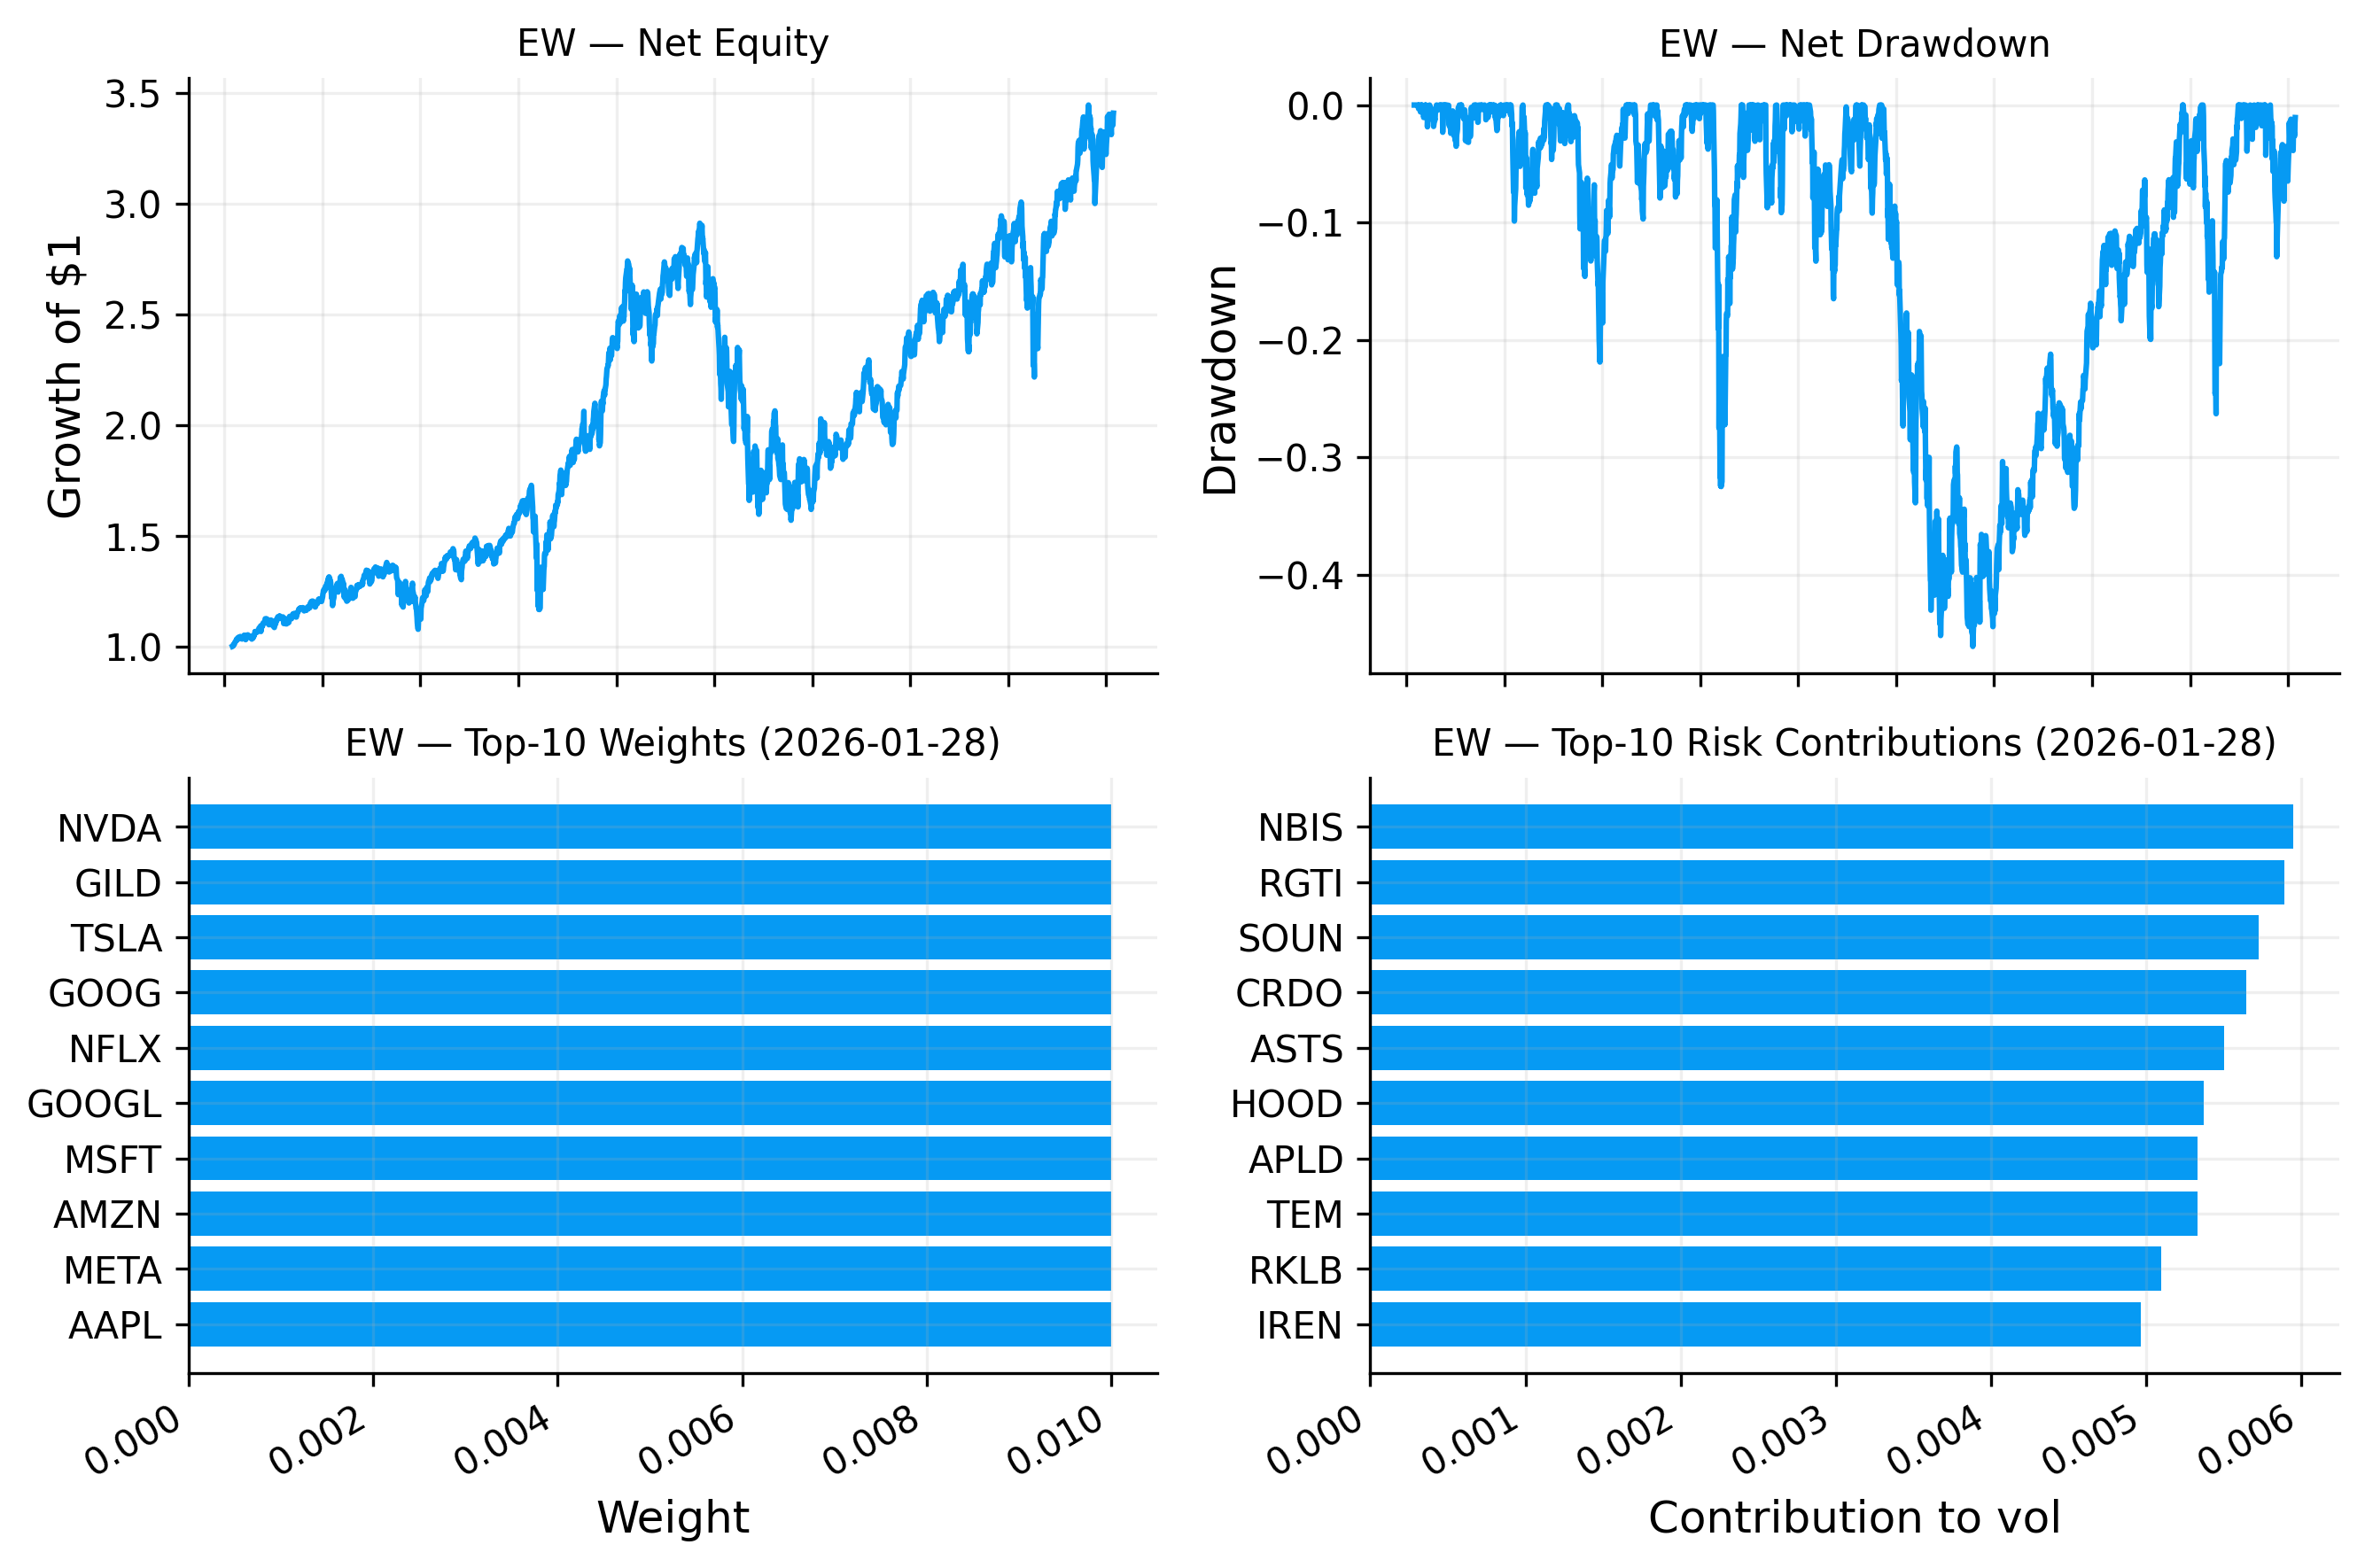

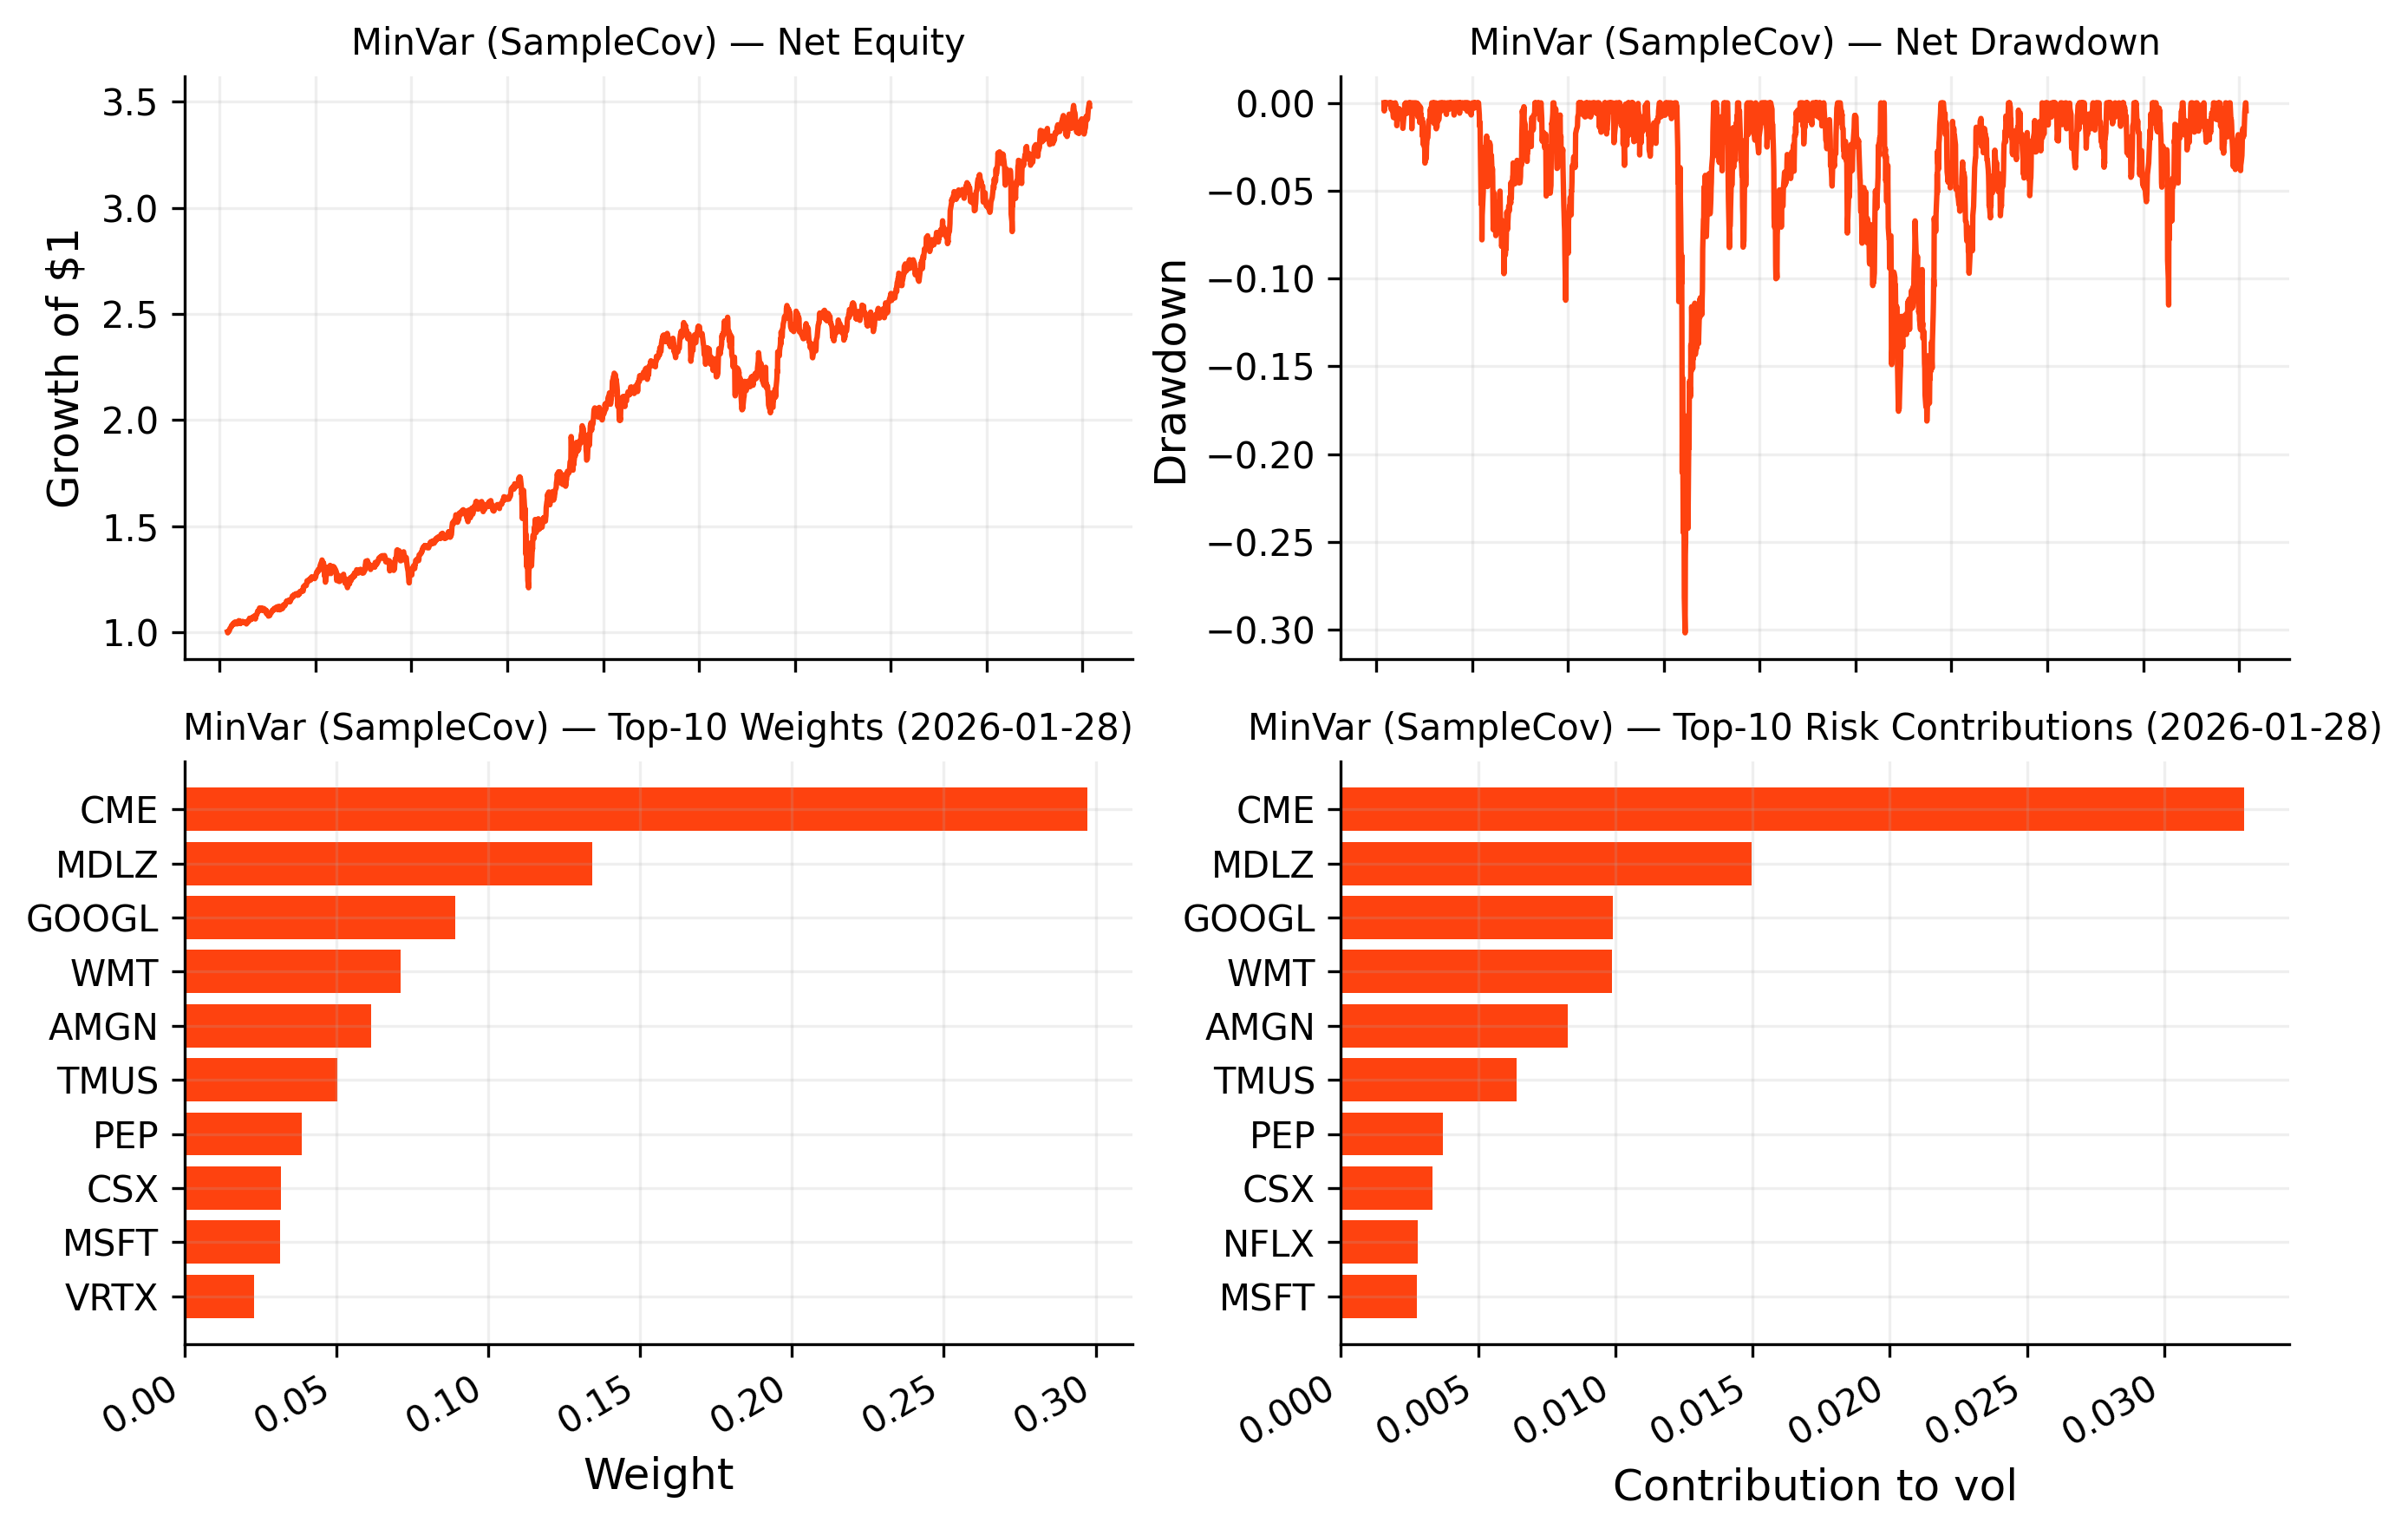

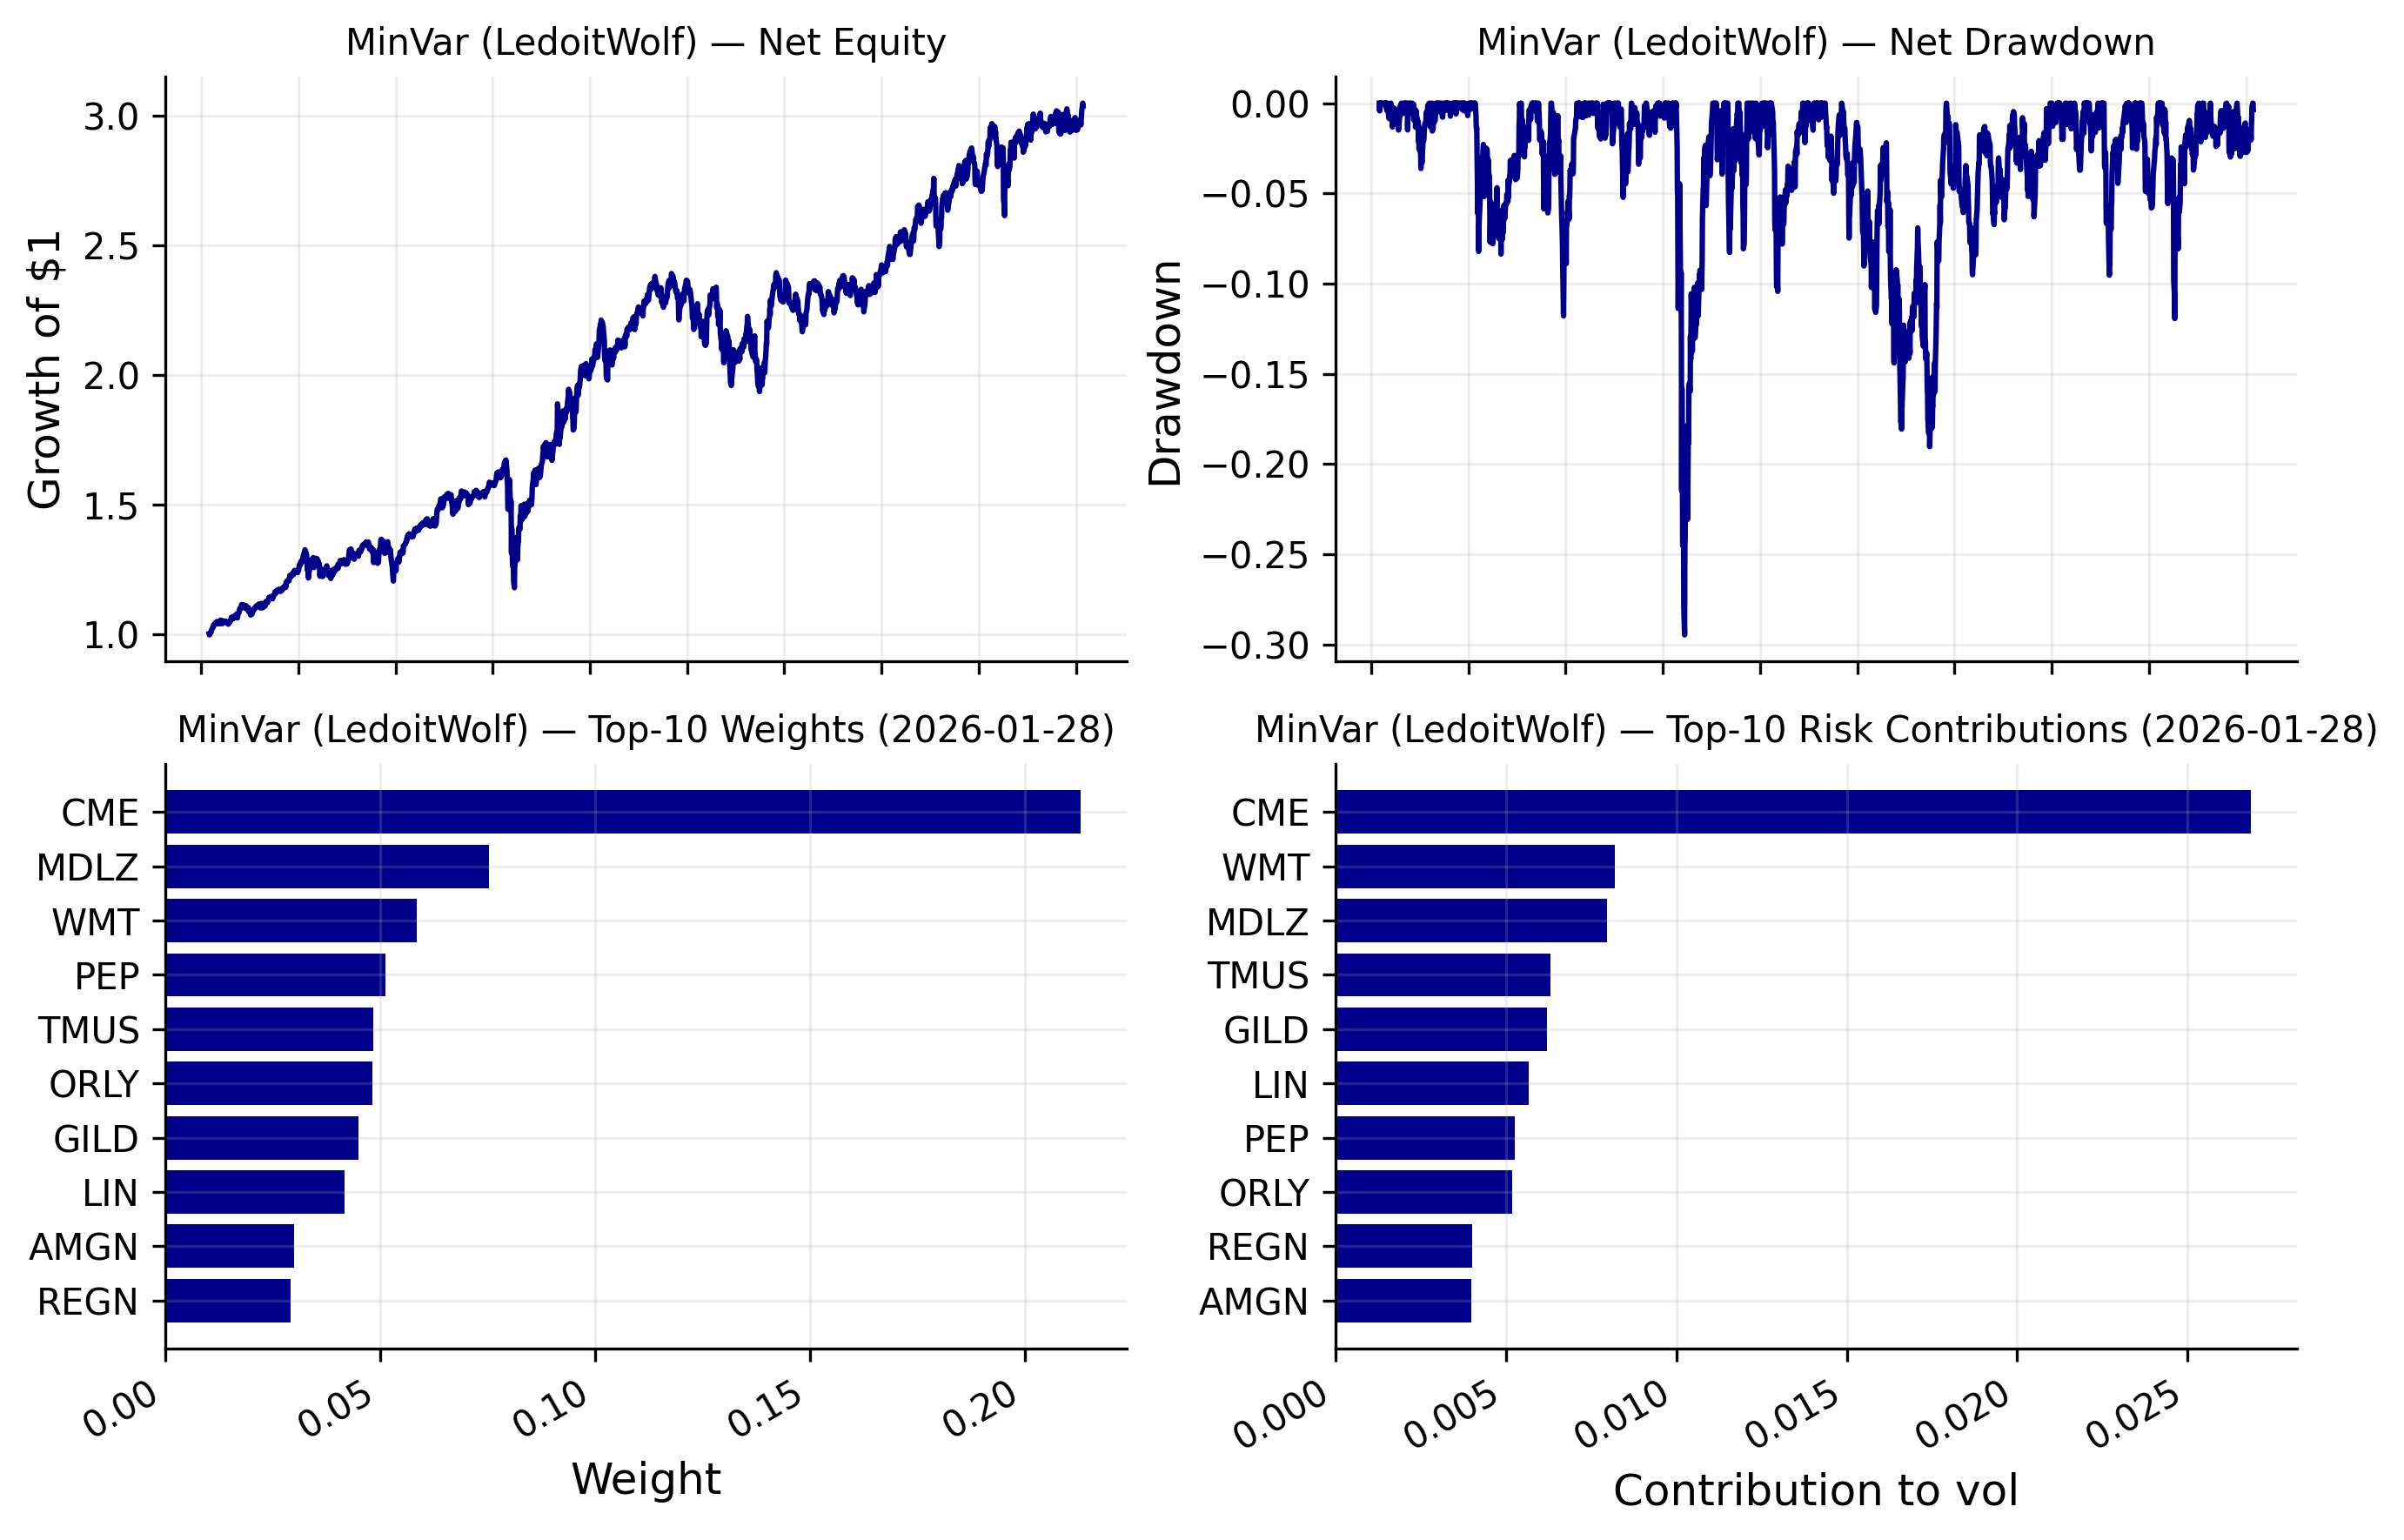

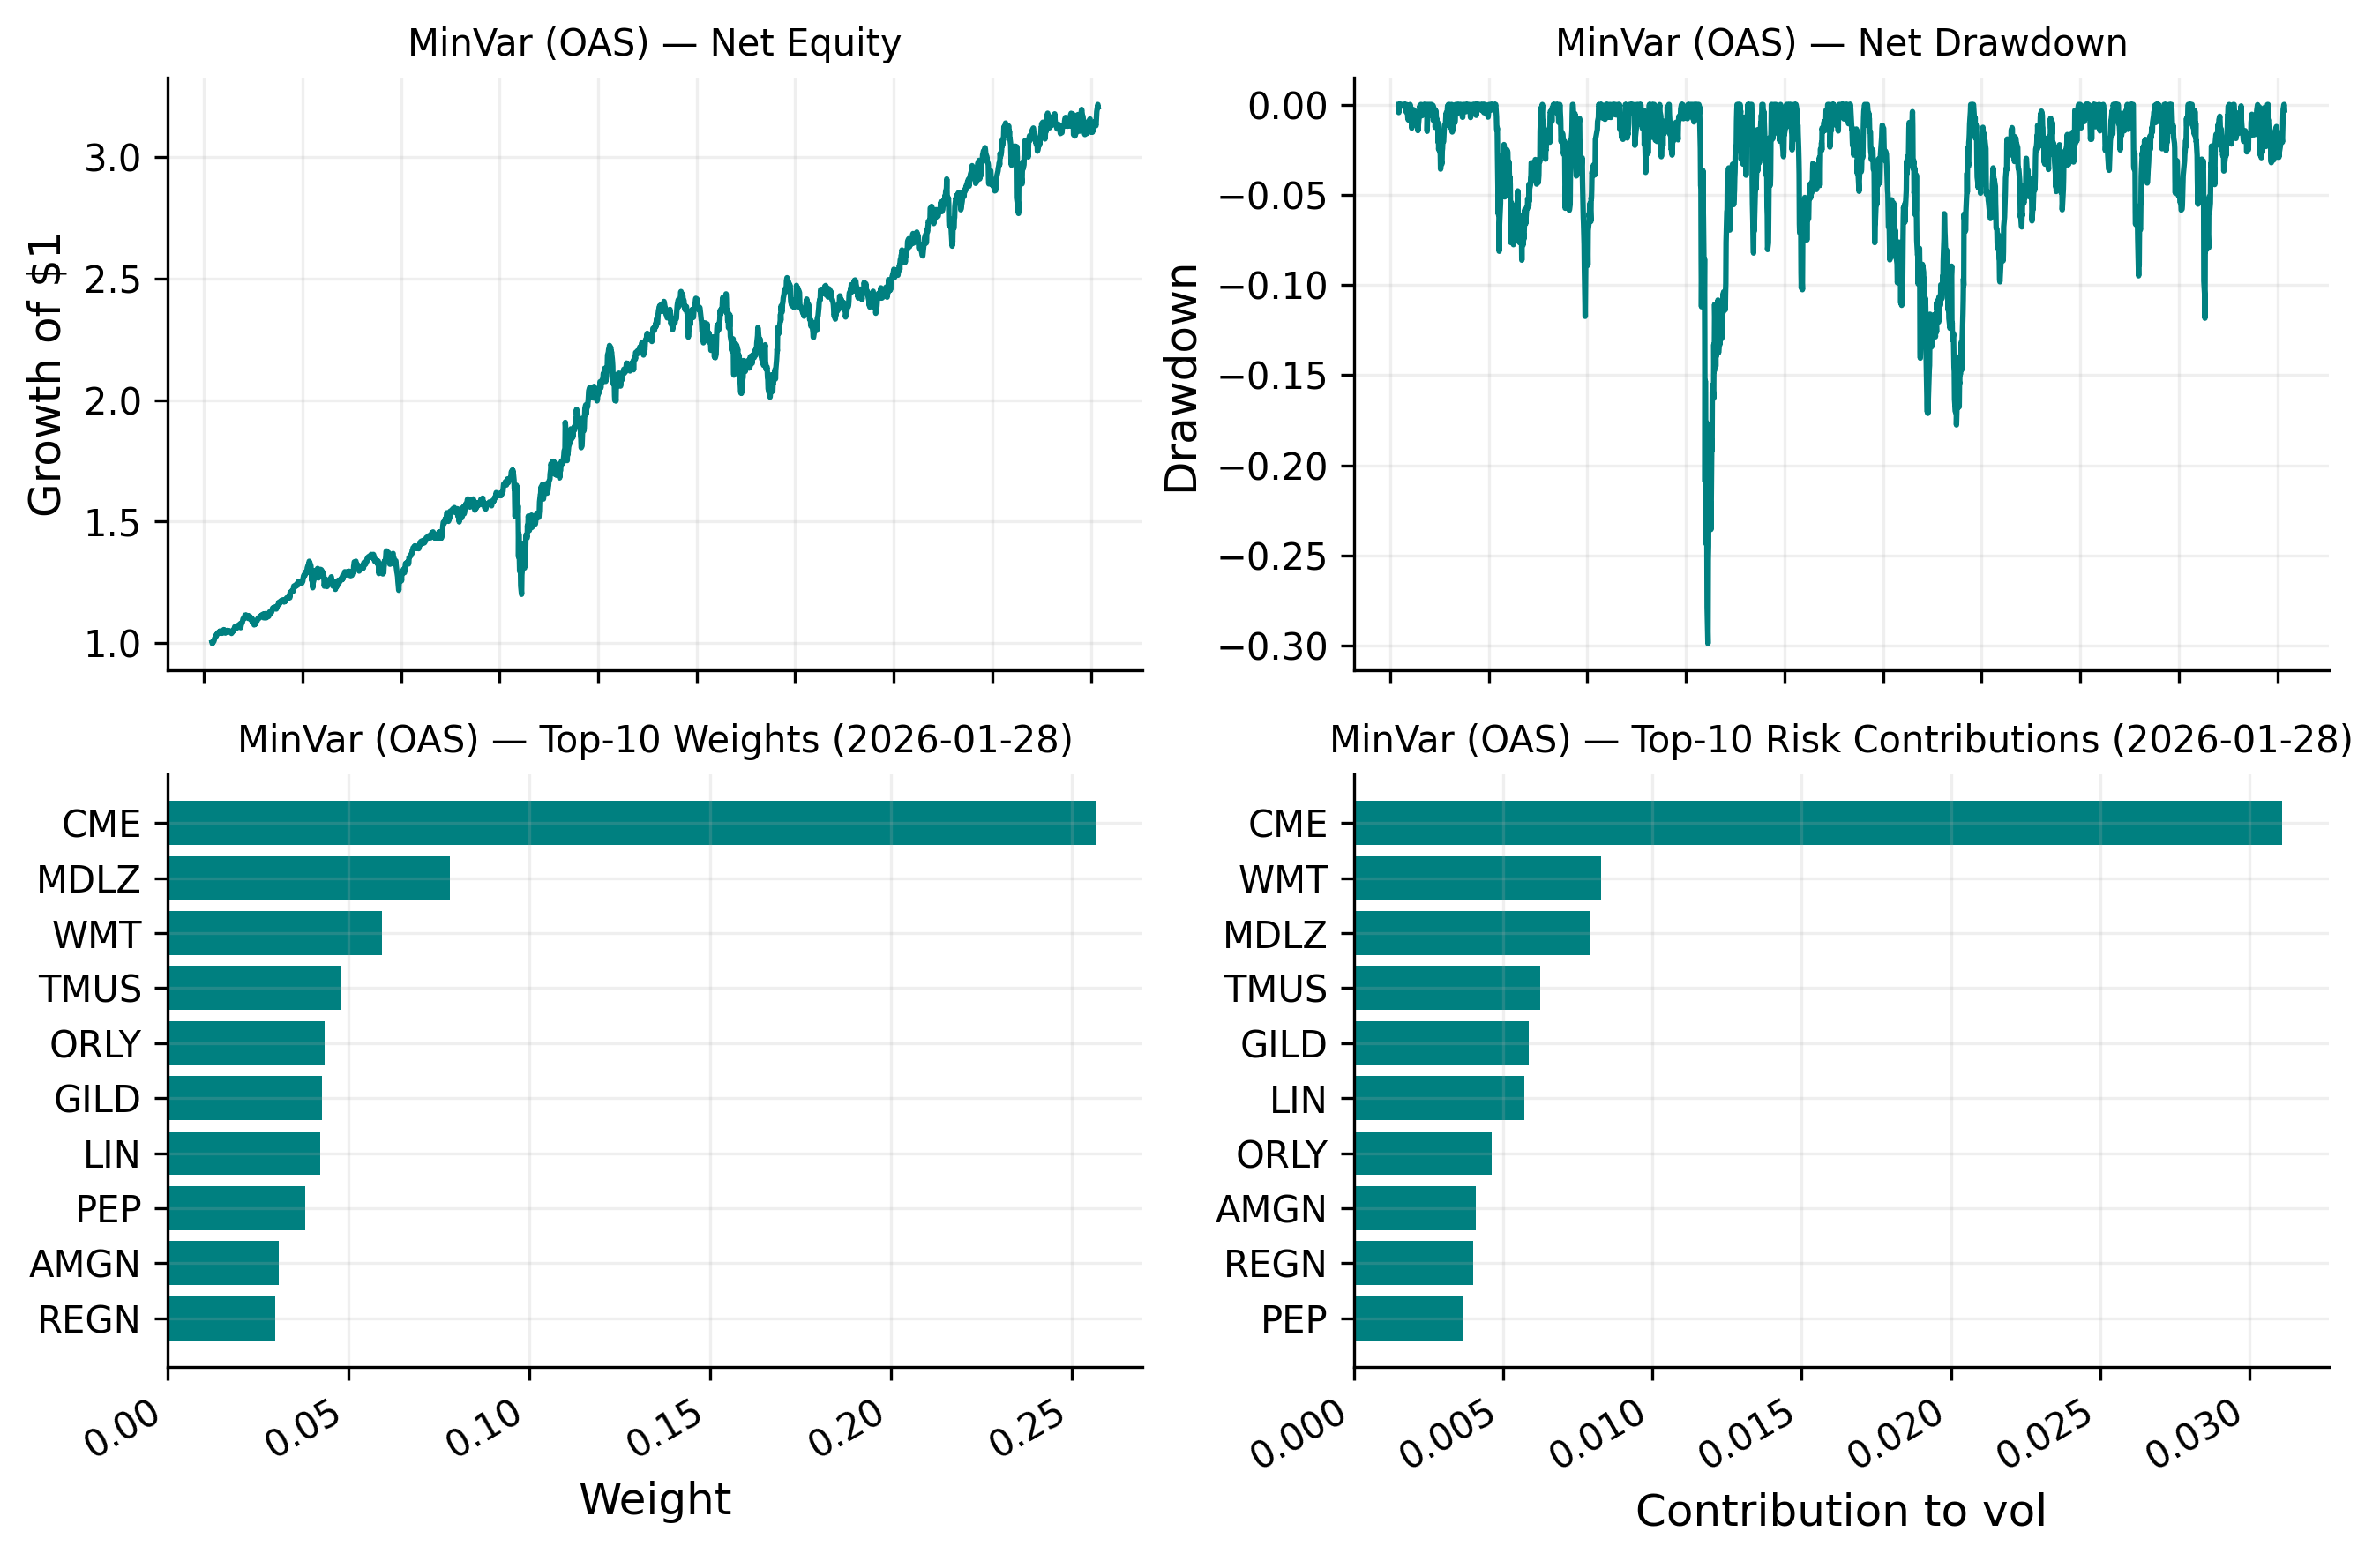

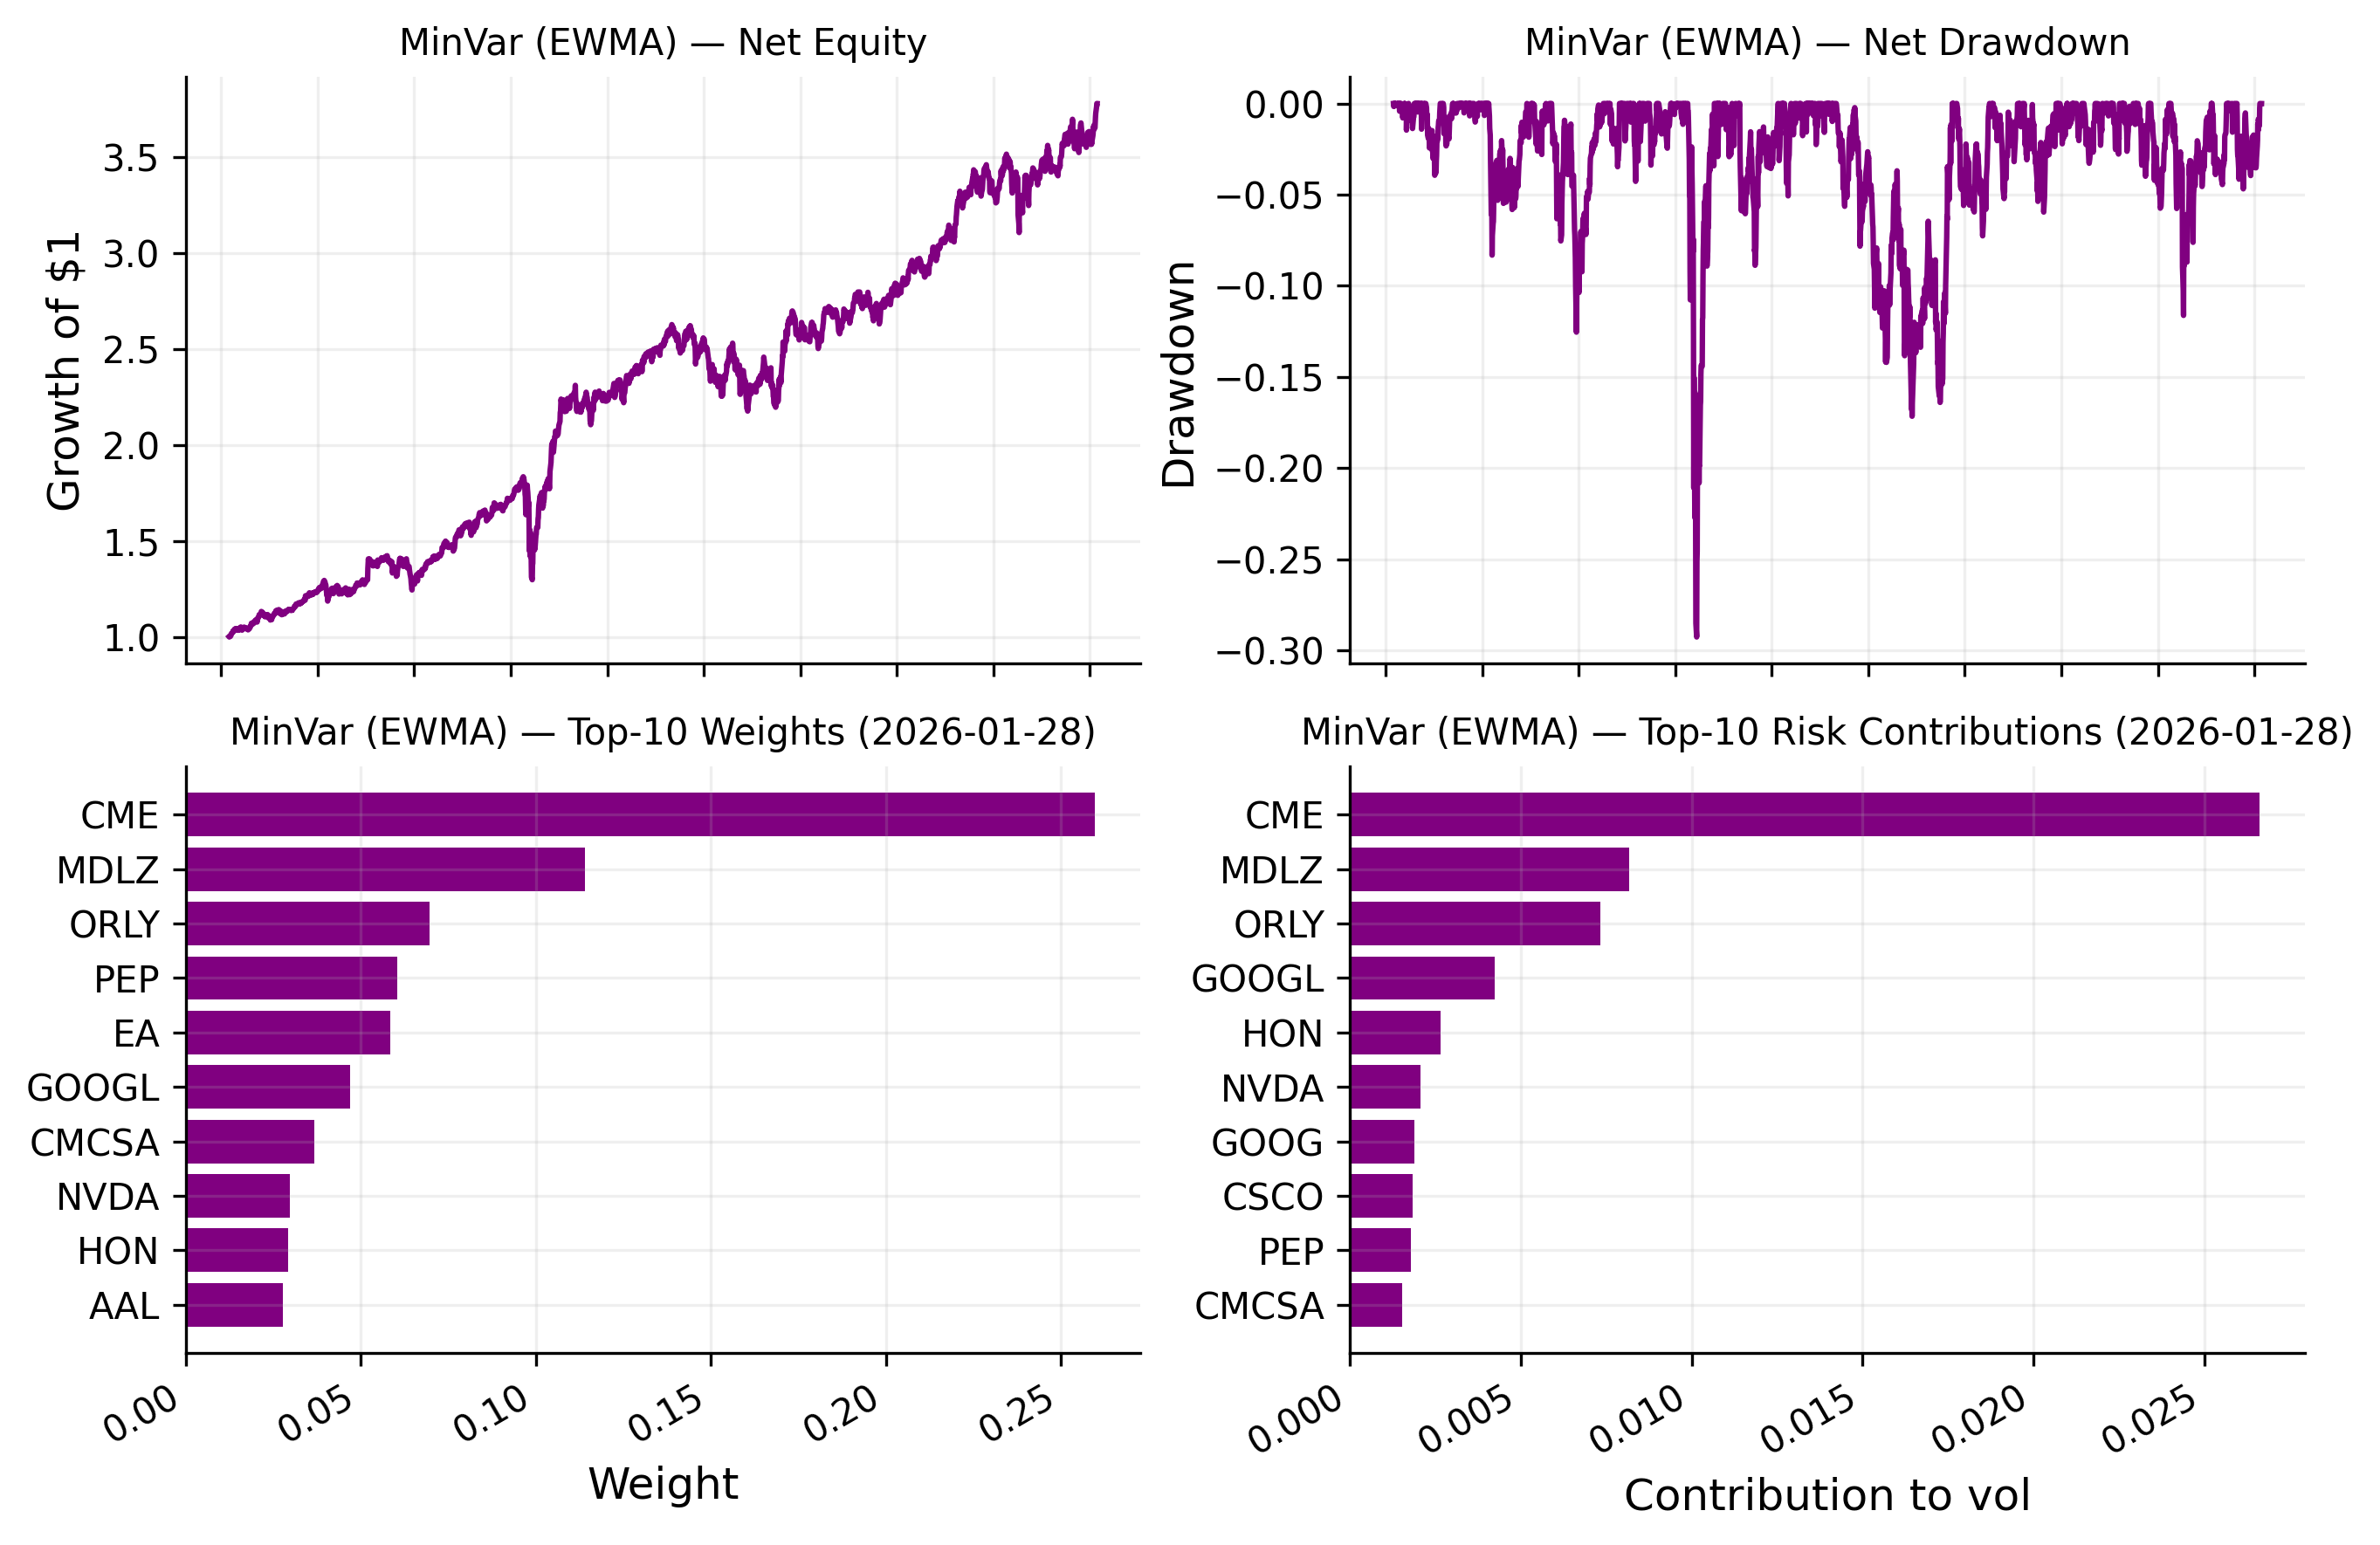

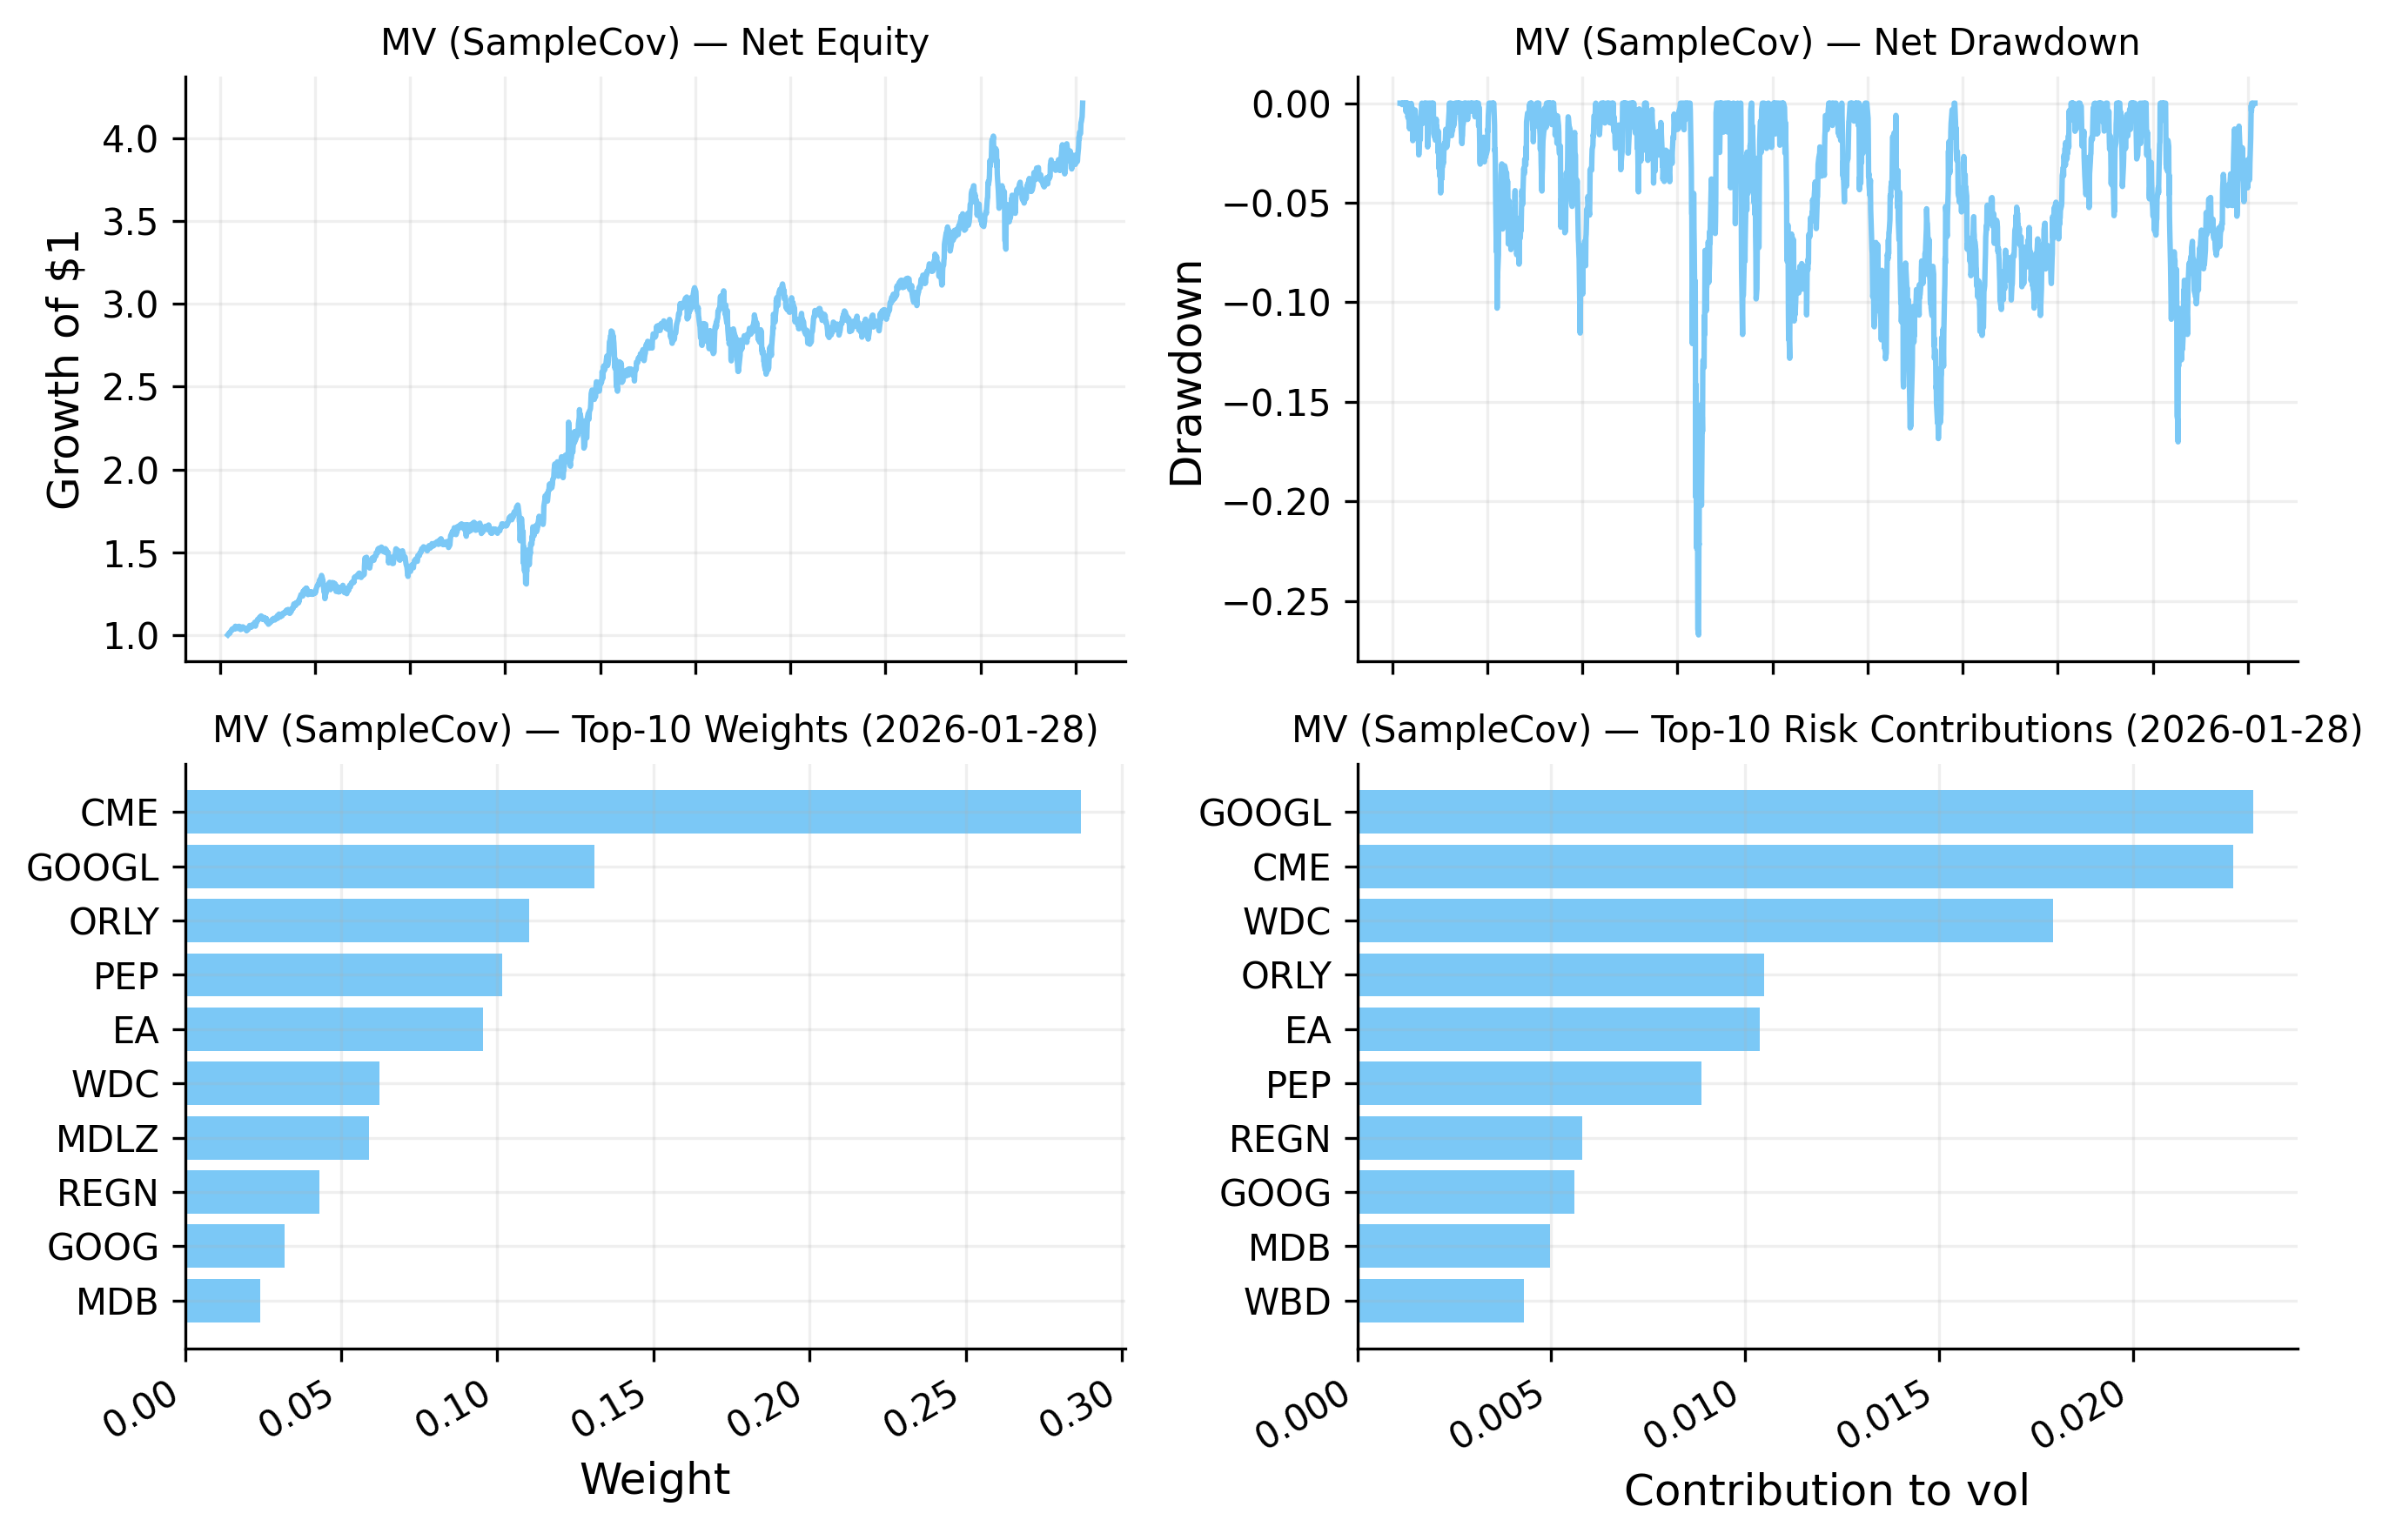

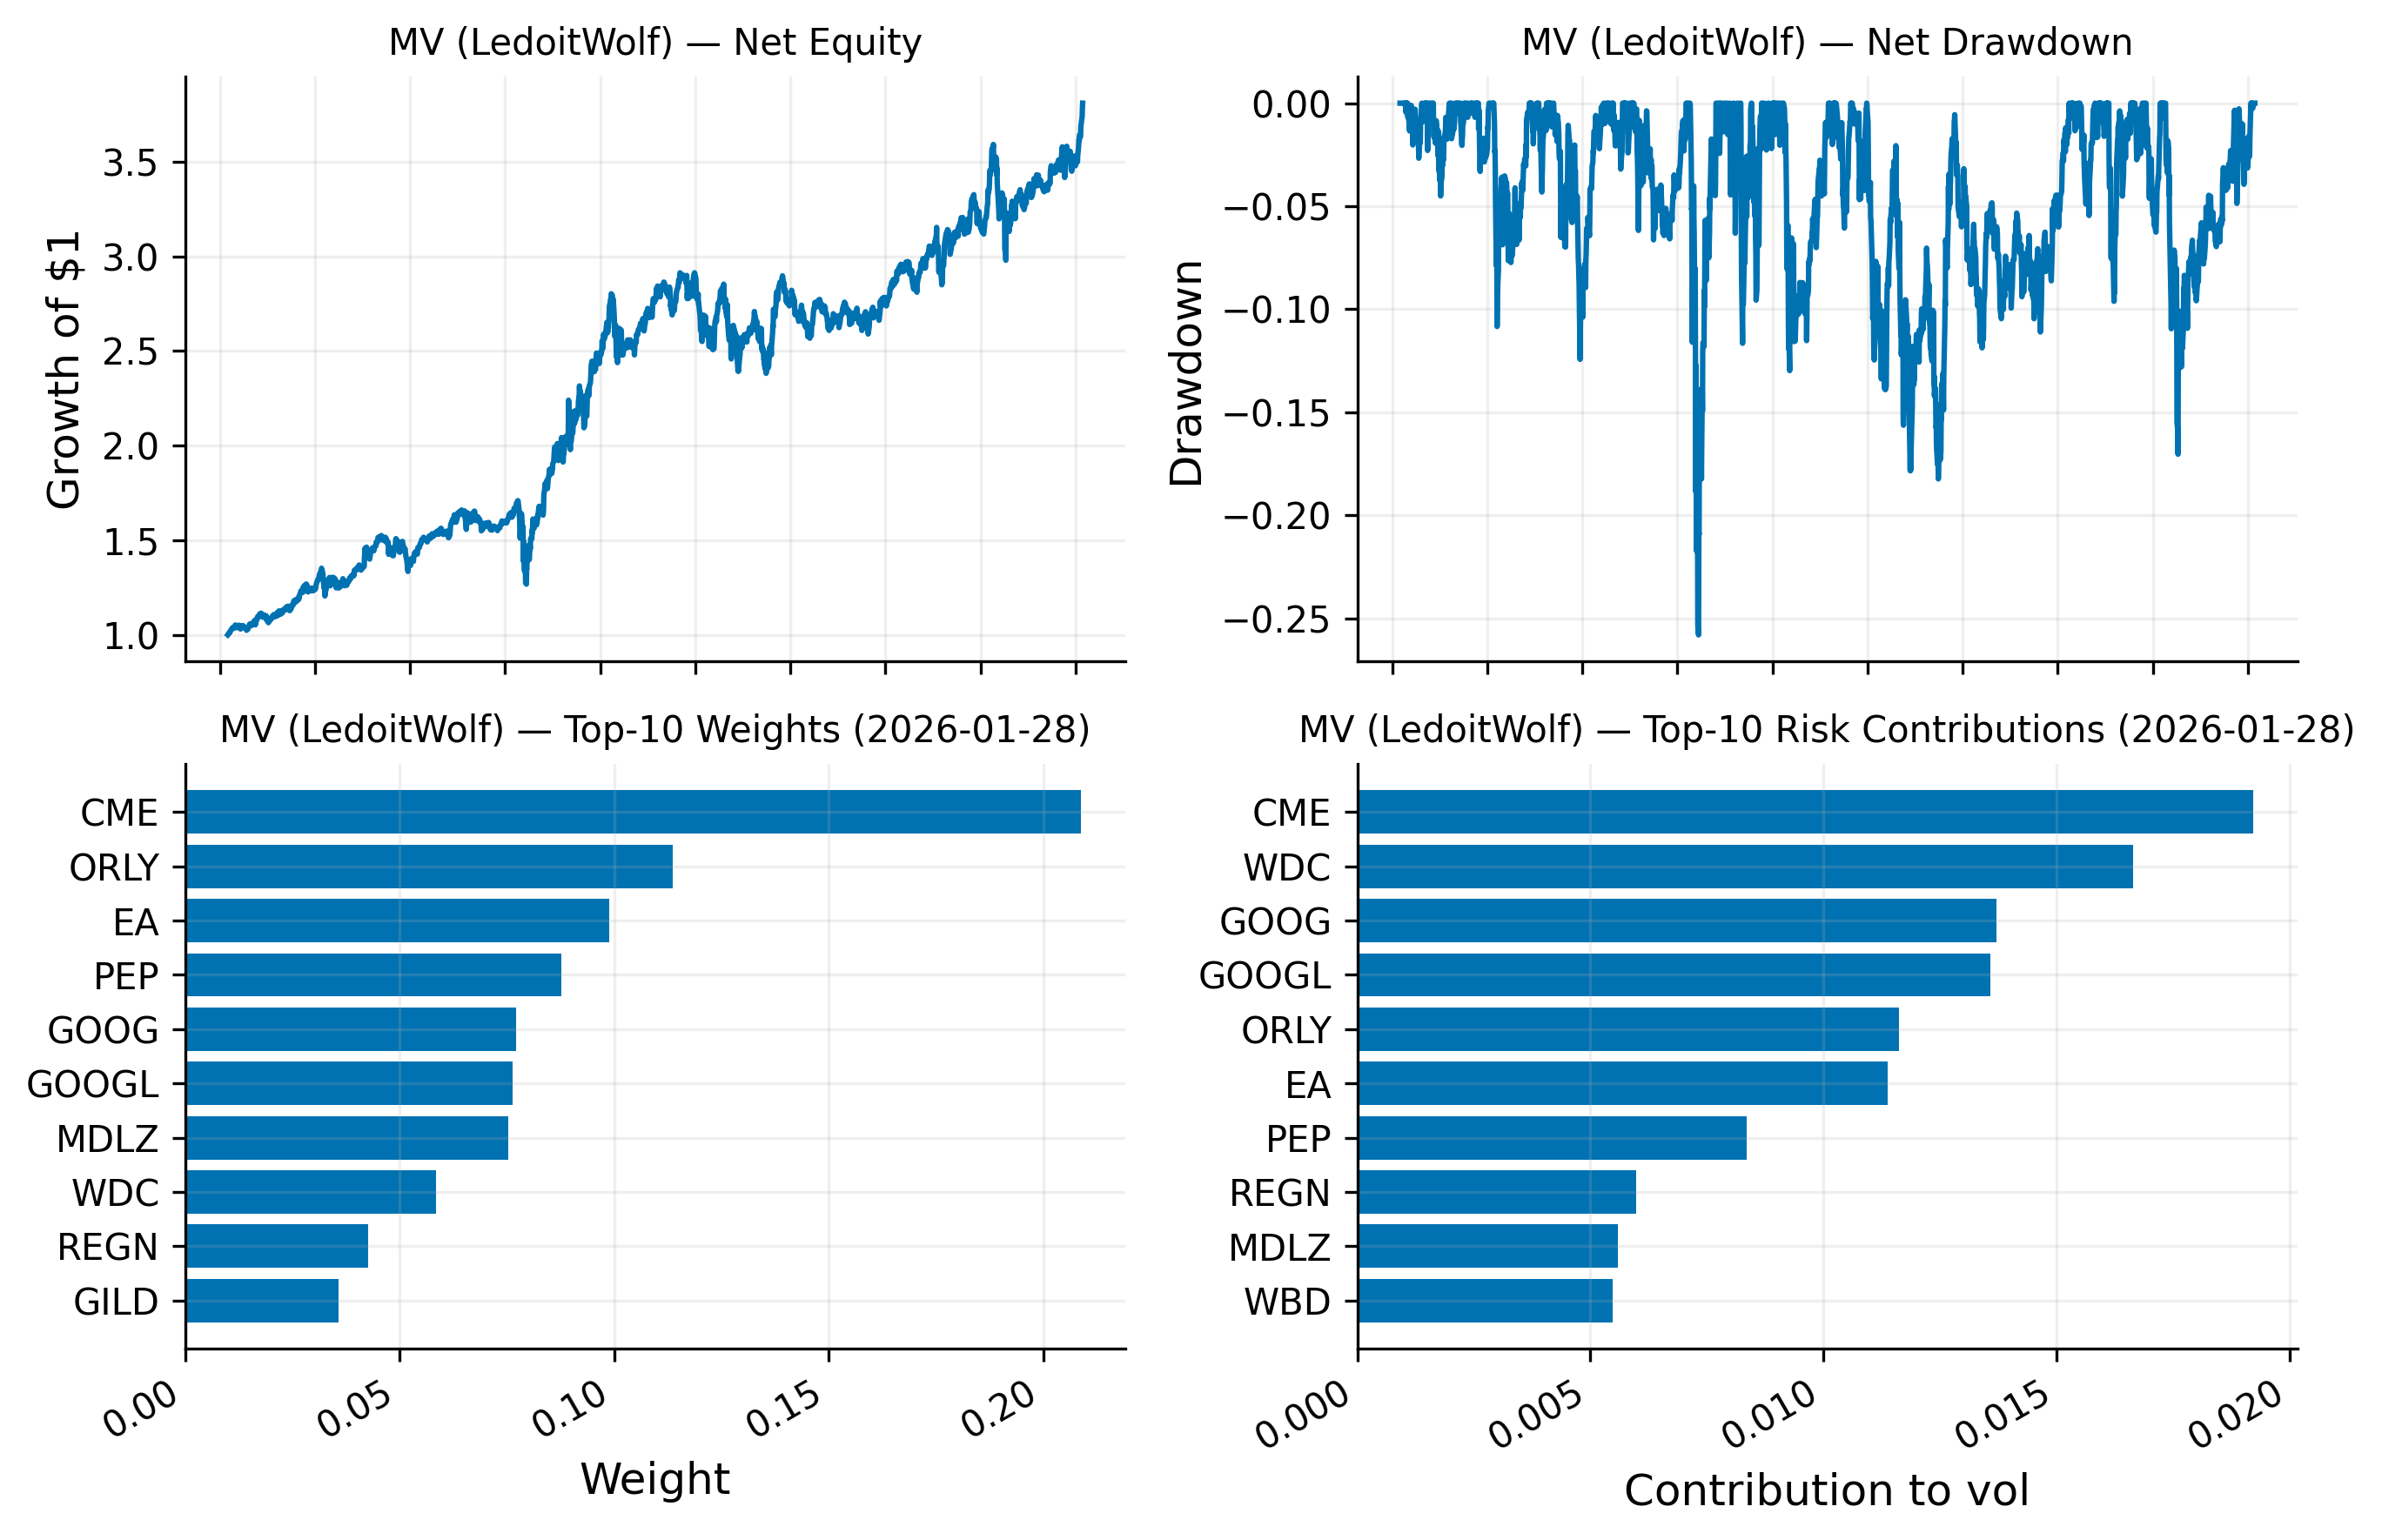

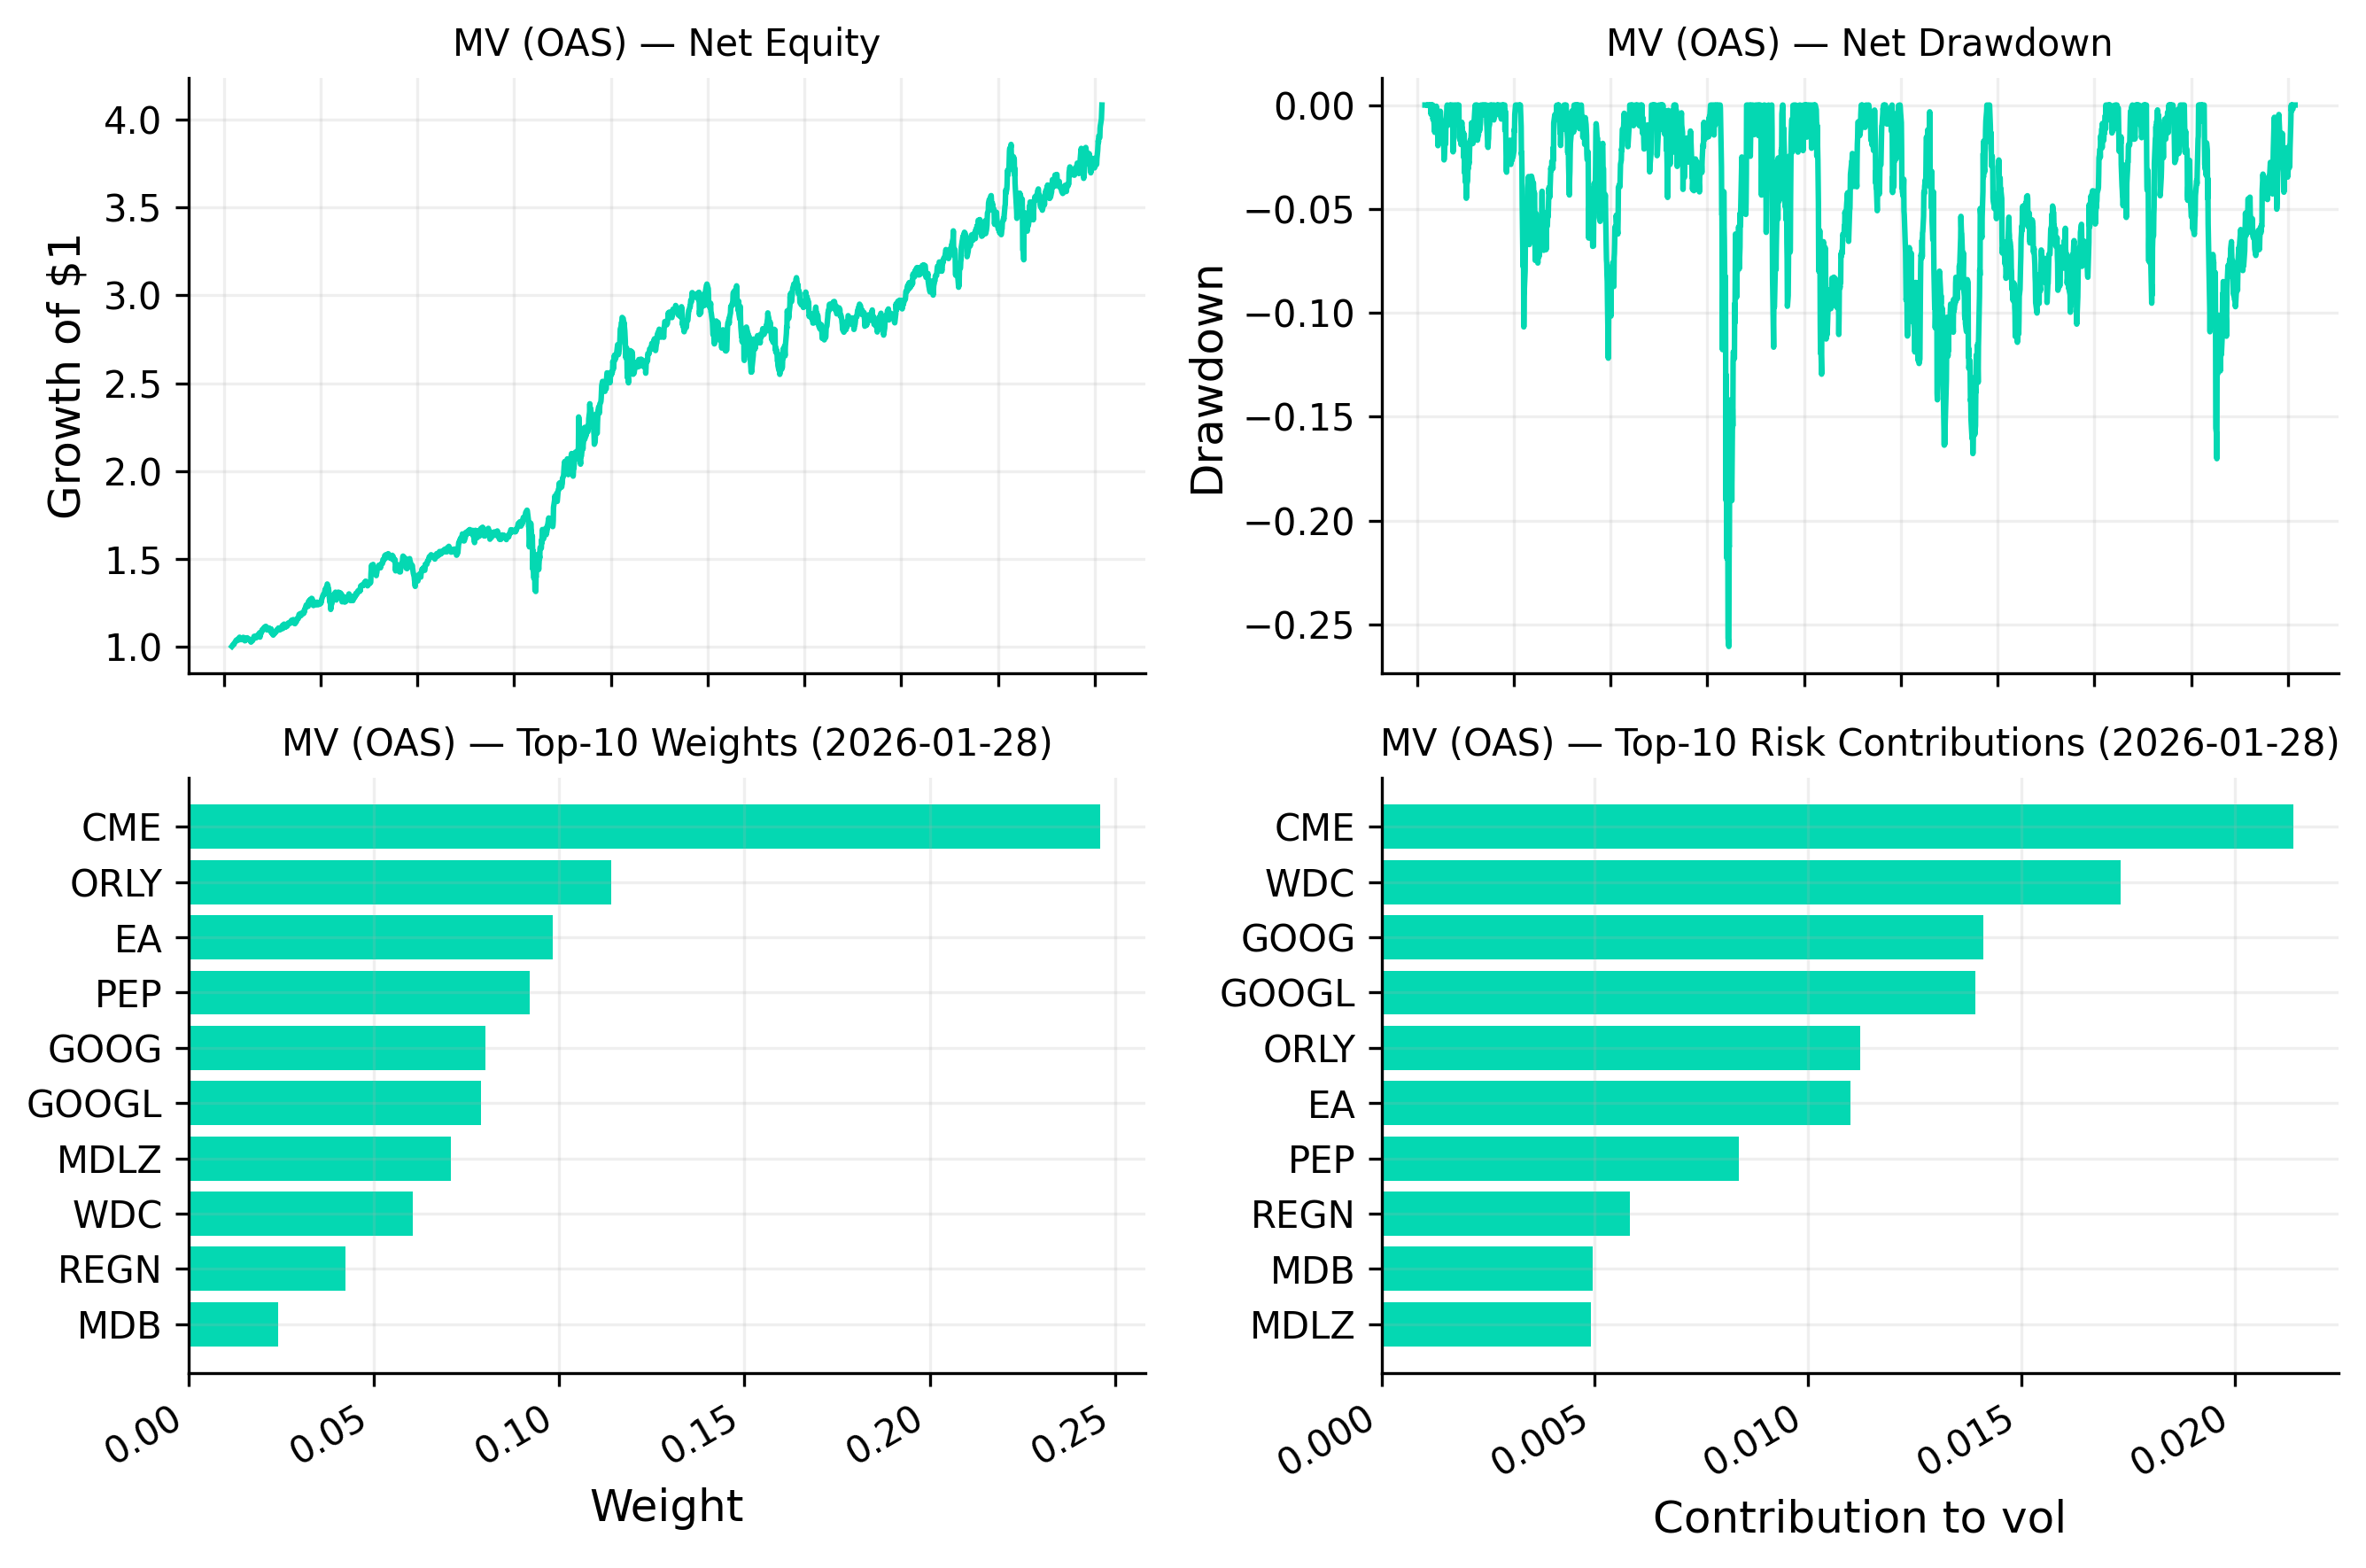

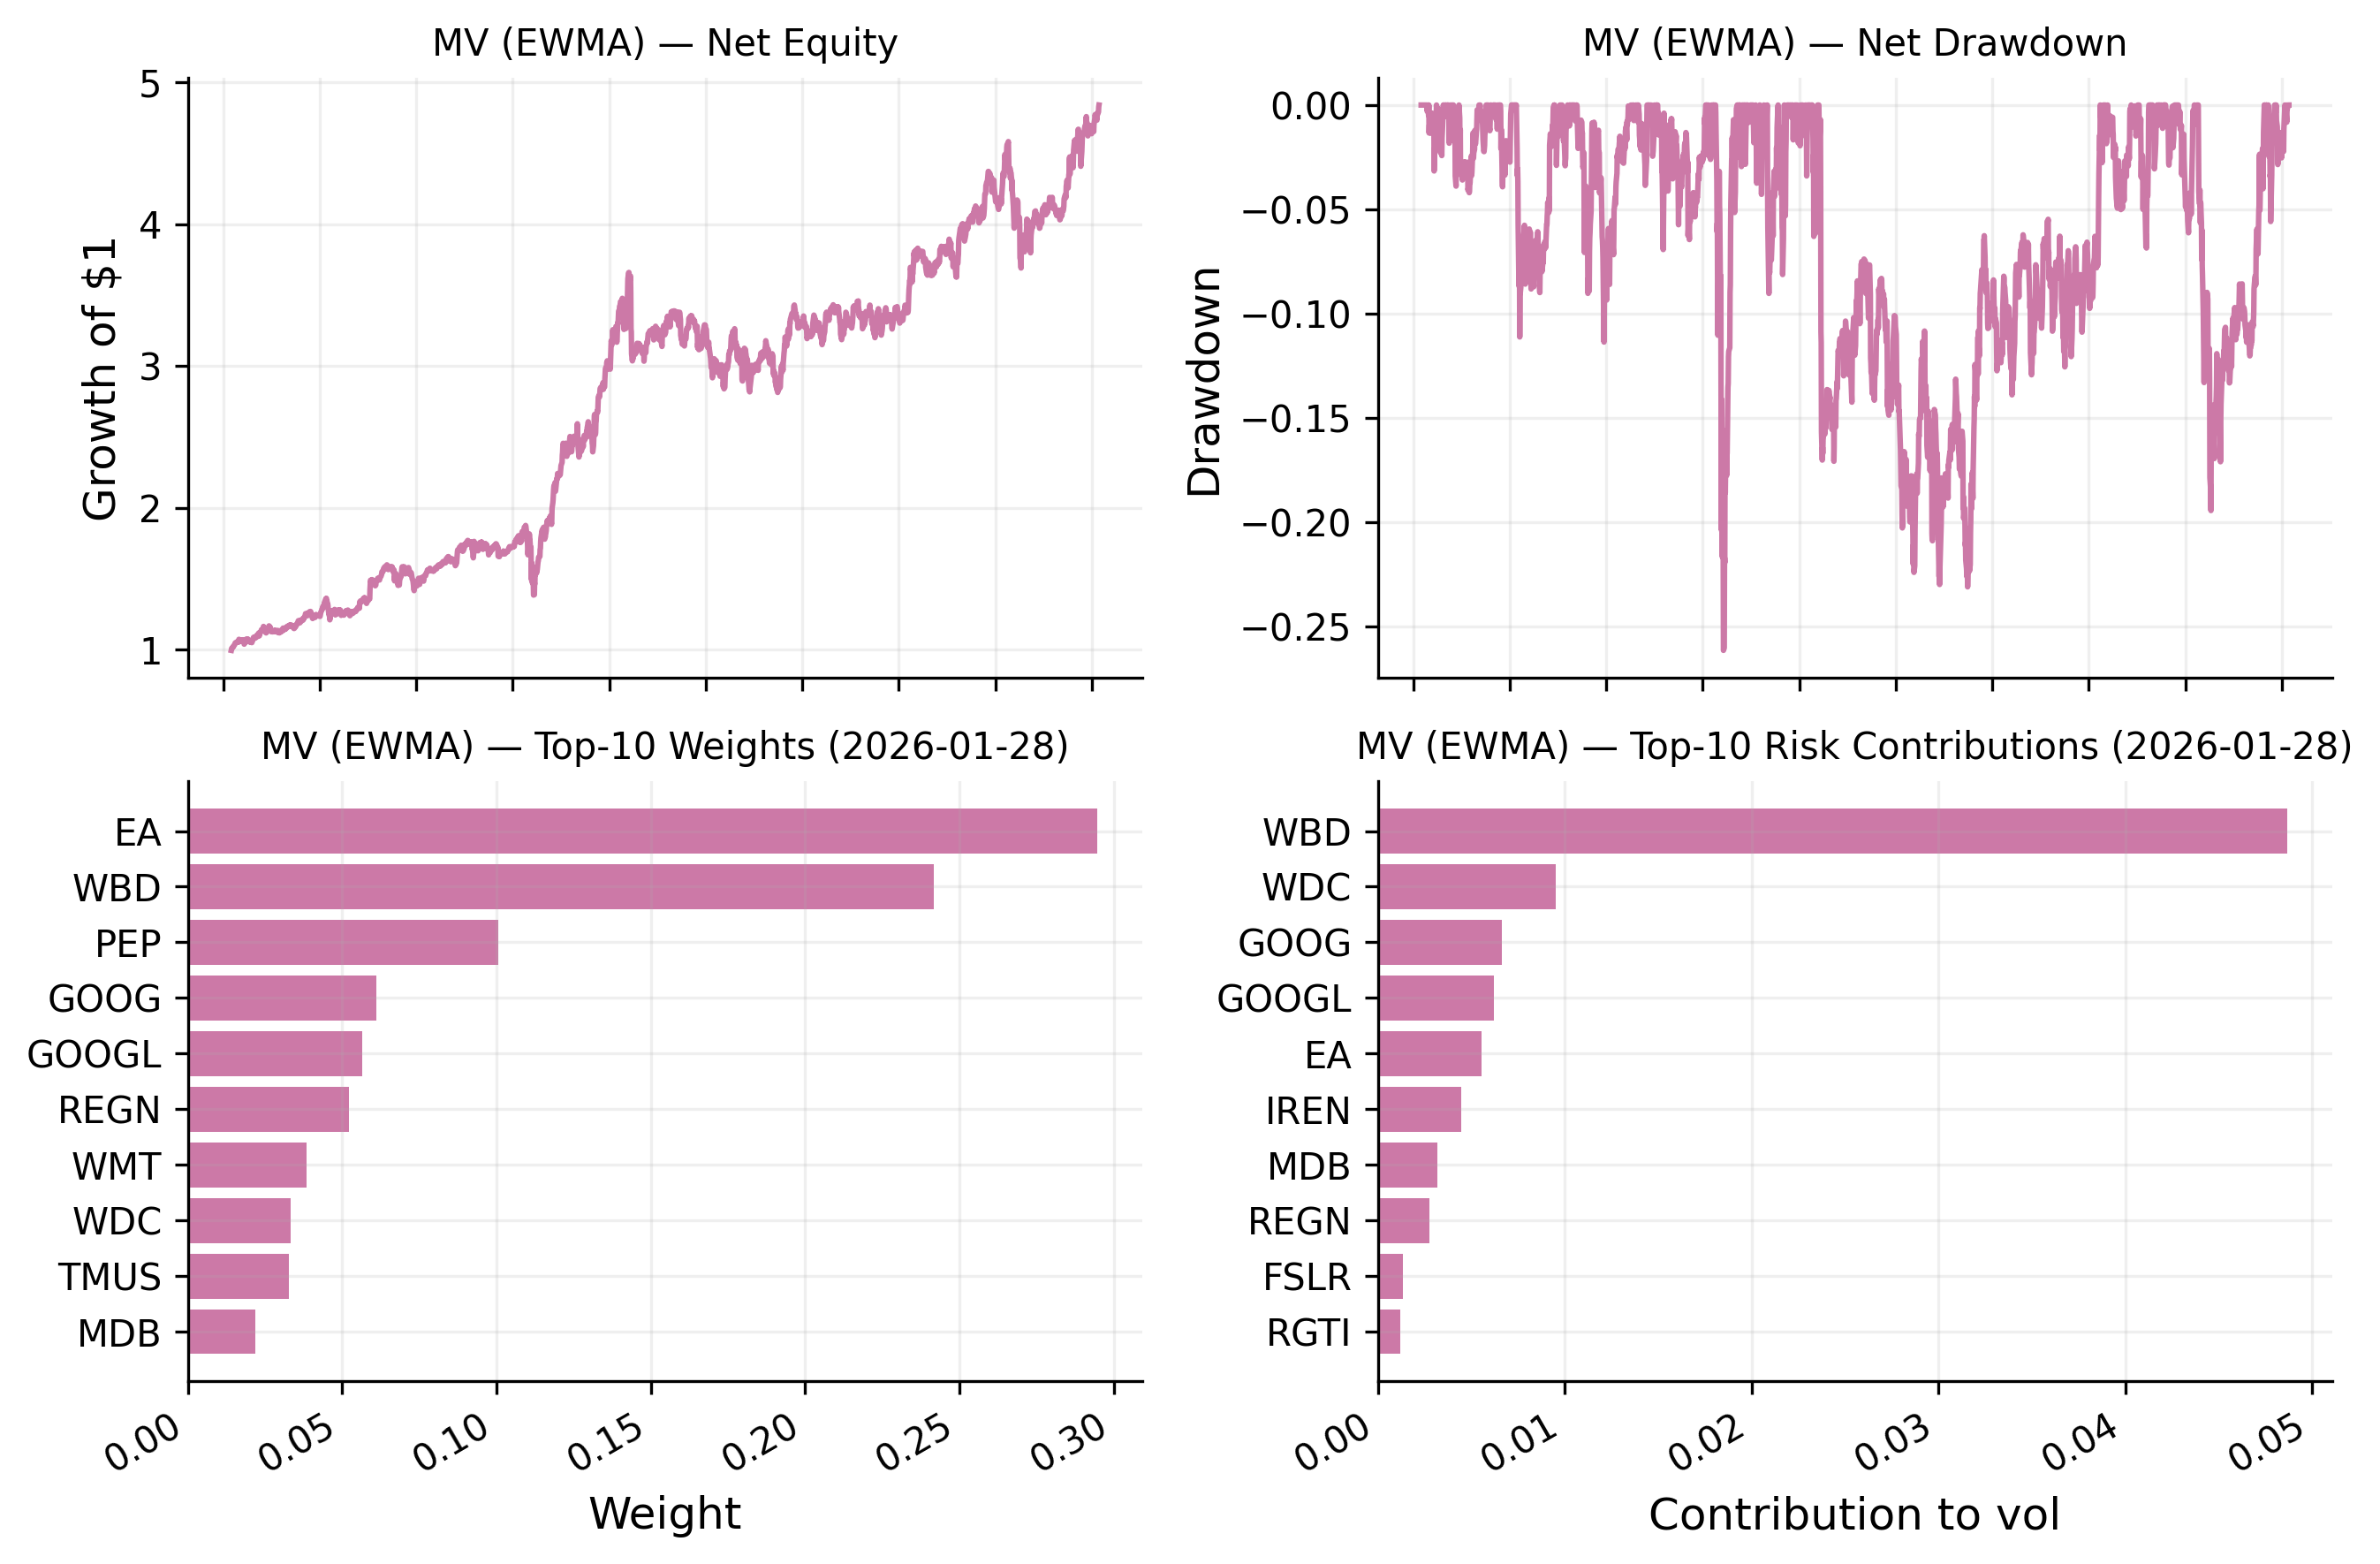

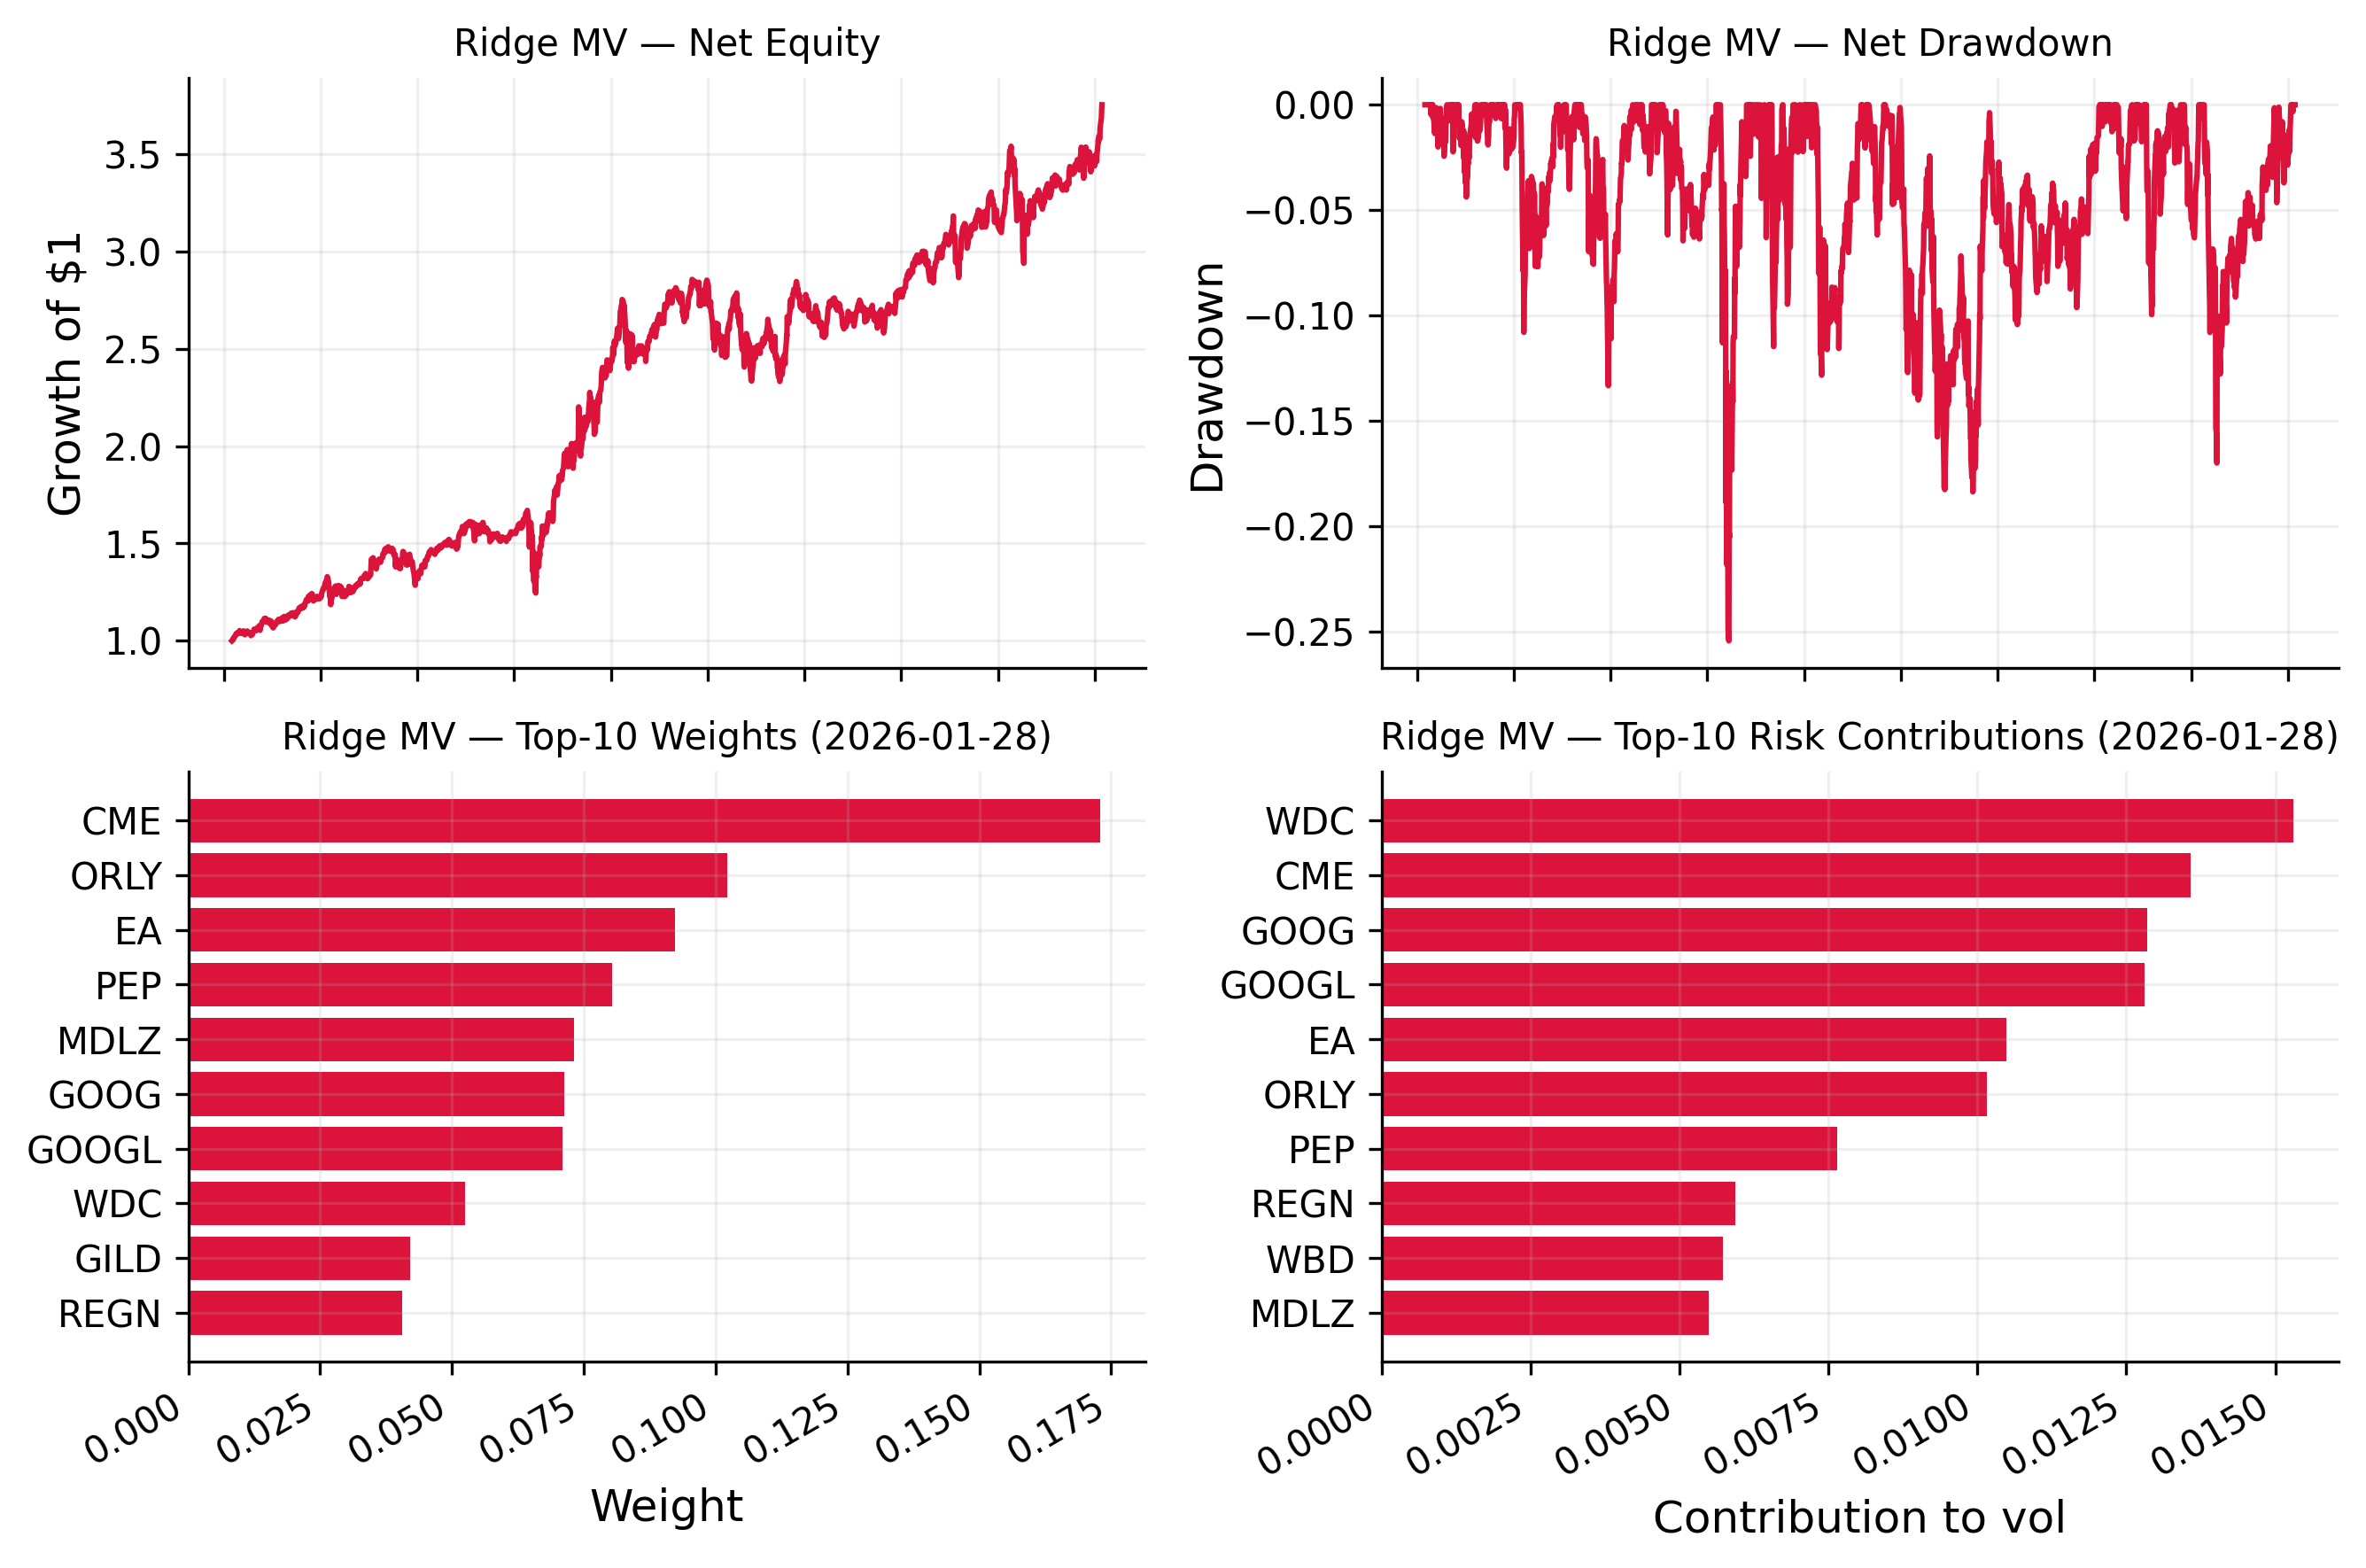

Computed strategies: ['EW', 'MinVar (SampleCov)', 'MinVar (LedoitWolf)', 'MinVar (OAS)', 'MinVar (EWMA)', 'MV (SampleCov)', 'MV (LedoitWolf)', 'MV (OAS)', 'MV (EWMA)', 'Ridge MV', 'MaxSharpe', 'MaxSharpe (FrontierGrid)']


In [72]:
results = {}

name = "EW"
results[name] = backtest_strategy(name, strategy_cov_key[name])
plot_strategy_dashboard(name, results[name], strategy_cov_key[name])

for name in ["MinVar (SampleCov)", "MinVar (LedoitWolf)", "MinVar (OAS)", "MinVar (EWMA)"]:
    results[name] = backtest_strategy(name, strategy_cov_key[name])
    plot_strategy_dashboard(name, results[name], strategy_cov_key[name])

for name in ["MV (SampleCov)", "MV (LedoitWolf)", "MV (OAS)", "MV (EWMA)"]:
    results[name] = backtest_strategy(name, strategy_cov_key[name])
    plot_strategy_dashboard(name, results[name], strategy_cov_key[name])

name = "Ridge MV"
results[name] = backtest_strategy(name, strategy_cov_key[name])
plot_strategy_dashboard(name, results[name], strategy_cov_key[name])

name = "MaxSharpe"
results[name] = backtest_strategy(name, strategy_cov_key[name])
plot_strategy_dashboard(name, results[name], strategy_cov_key[name])


name = "MaxSharpe (FrontierGrid)"
results[name] = backtest_strategy(name, strategy_cov_key[name])
plot_strategy_dashboard(name, results[name], strategy_cov_key[name])


strategy_names = list(results.keys())
print("Computed strategies:", strategy_names)


## 13) summary tables and overall plots (style preserved)

### Trading diagnostics (turnover, costs, concentration)

We compute:
- average turnover per rebalance
- total turnover
- total costs
- average HHI and effective number of holdings

$$
HHI_t = \sum_i w_{t,i}^2
\quad,\quad
N_{eff} = \frac{1}{E[HHI]}
$$


## 10) Practical notes and common failure modes

### 10.1 Missing data
Optimization and covariance estimation are sensitive to NaNs. A robust workflow is:
- drop tickers with insufficient history (seasoning)
- require enough valid points in the estimation window
- prefer shrinkage or diagonal covariance when $T$ is not large compared to $N$

### 10.2 Why long-only + caps matter
Unconstrained MV often produces extreme leverage and short positions because it tries to exploit tiny mean differences and noisy covariance inverses. Long-only and caps:
- reduce instability
- reduce turnover
- make backtests more realistic

### 10.3 Estimation error is the main enemy
Most “alpha” from MV models can disappear after costs because:
- $\mu_t$ is hard to estimate
- $\Sigma_t$ is noisy
- small changes in inputs can swing weights

That is why we include shrinkage, EWMA, ridge penalties, and turnover penalties as stabilizers.


Risk/Return Summary (Net)


CAGR    AnnVol    Sharpe     MaxDD    Calmar  \
Strategy                                                                     
EW                        0.146453  0.253005  0.511901 -0.460750  0.317857   
MinVar (SampleCov)        0.149080  0.156826  0.713440 -0.301659  0.494198   
MinVar (LedoitWolf)       0.131802  0.156436  0.618246 -0.294654  0.447311   
MinVar (OAS)              0.138715  0.157162  0.654807 -0.298865  0.464138   
MinVar (EWMA)             0.159730  0.149965  0.801608 -0.292644  0.545817   
MV (SampleCov)            0.173839  0.169259  0.799612 -0.267086  0.650872   
MV (LedoitWolf)           0.160719  0.171953  0.724792 -0.258015  0.622908   
MV (OAS)                  0.169801  0.170463  0.775180 -0.260653  0.651444   
MV (EWMA)                 0.192160  0.176197  0.866270 -0.261580  0.734613   
Ridge MV                  0.158871  0.171373  0.717786 -0.254235  0.624899   
MaxSharpe                 0.214685  0.294098  0.678921 -0.463620  0.463062   
MaxSharpe (FrontierGrid)  0.247819  0.306612  0.751453 -0.461558  0.536919   

                           Sortino  
Strategy                            
EW                        0.672864  
MinVar (SampleCov)        0.881298  
MinVar (LedoitWolf)       0.763086  
MinVar (OAS)              0.806813  
MinVar (EWMA)             0.990909  
MV (SampleCov)            1.035257  
MV (LedoitWolf)           0.931472  
MV (OAS)                  0.997092  
MV (EWMA)                 1.089714  
Ridge MV                  0.918202  
MaxSharpe                 0.873406  
MaxSharpe (FrontierGrid)  0.977310

Trading & Stability Summary


Avg Turnover  Total Turnover  Total Costs  \
Strategy                                                              
EW                            0.048705        5.308806     0.010946   
MinVar (SampleCov)            0.037319        4.067817     0.007705   
MinVar (LedoitWolf)           0.046199        5.035718     0.009848   
MinVar (OAS)                  0.043329        4.722860     0.009618   
MinVar (EWMA)                 0.132252       14.415466     0.032032   
MV (SampleCov)                0.180821       19.709533     0.046787   
MV (LedoitWolf)               0.179599       19.576275     0.043862   
MV (OAS)                      0.178560       19.463078     0.045991   
MV (EWMA)                     0.390754       42.592173     0.115800   
Ridge MV                      0.165821       18.074460     0.040207   
MaxSharpe                     0.425947       46.428214     0.128053   
MaxSharpe (FrontierGrid)      0.364269       39.705354     0.129777   

                          Cost % Final Value   Avg HHI  Effective N  
Strategy                                                             
EW                                  0.003211  0.010000   100.000004  
MinVar (SampleCov)                  0.002215  0.104591     9.561018  
MinVar (LedoitWolf)                 0.003243  0.064942    15.398272  
MinVar (OAS)                        0.002999  0.080609    12.405558  
MinVar (EWMA)                       0.008475  0.100932     9.907700  
MV (SampleCov)                      0.011107  0.119152     8.392617  
MV (LedoitWolf)                     0.011517  0.084989    11.766241  
MV (OAS)                            0.011261  0.095875    10.430238  
MV (EWMA)                           0.023923  0.130574     7.658491  
Ridge MV                            0.010709  0.066461    15.046381  
MaxSharpe                           0.022365  0.147180     6.794388  
MaxSharpe (FrontierGrid)            0.017803  0.154637     6.466742

Fallback counts per strategy:
EW: 0
MinVar (SampleCov): 0
MinVar (LedoitWolf): 0
MinVar (OAS): 0
MinVar (EWMA): 0
MV (SampleCov): 0
MV (LedoitWolf): 0
MV (OAS): 0
MV (EWMA): 0
Ridge MV: 0
MaxSharpe: 0
MaxSharpe (FrontierGrid): 0


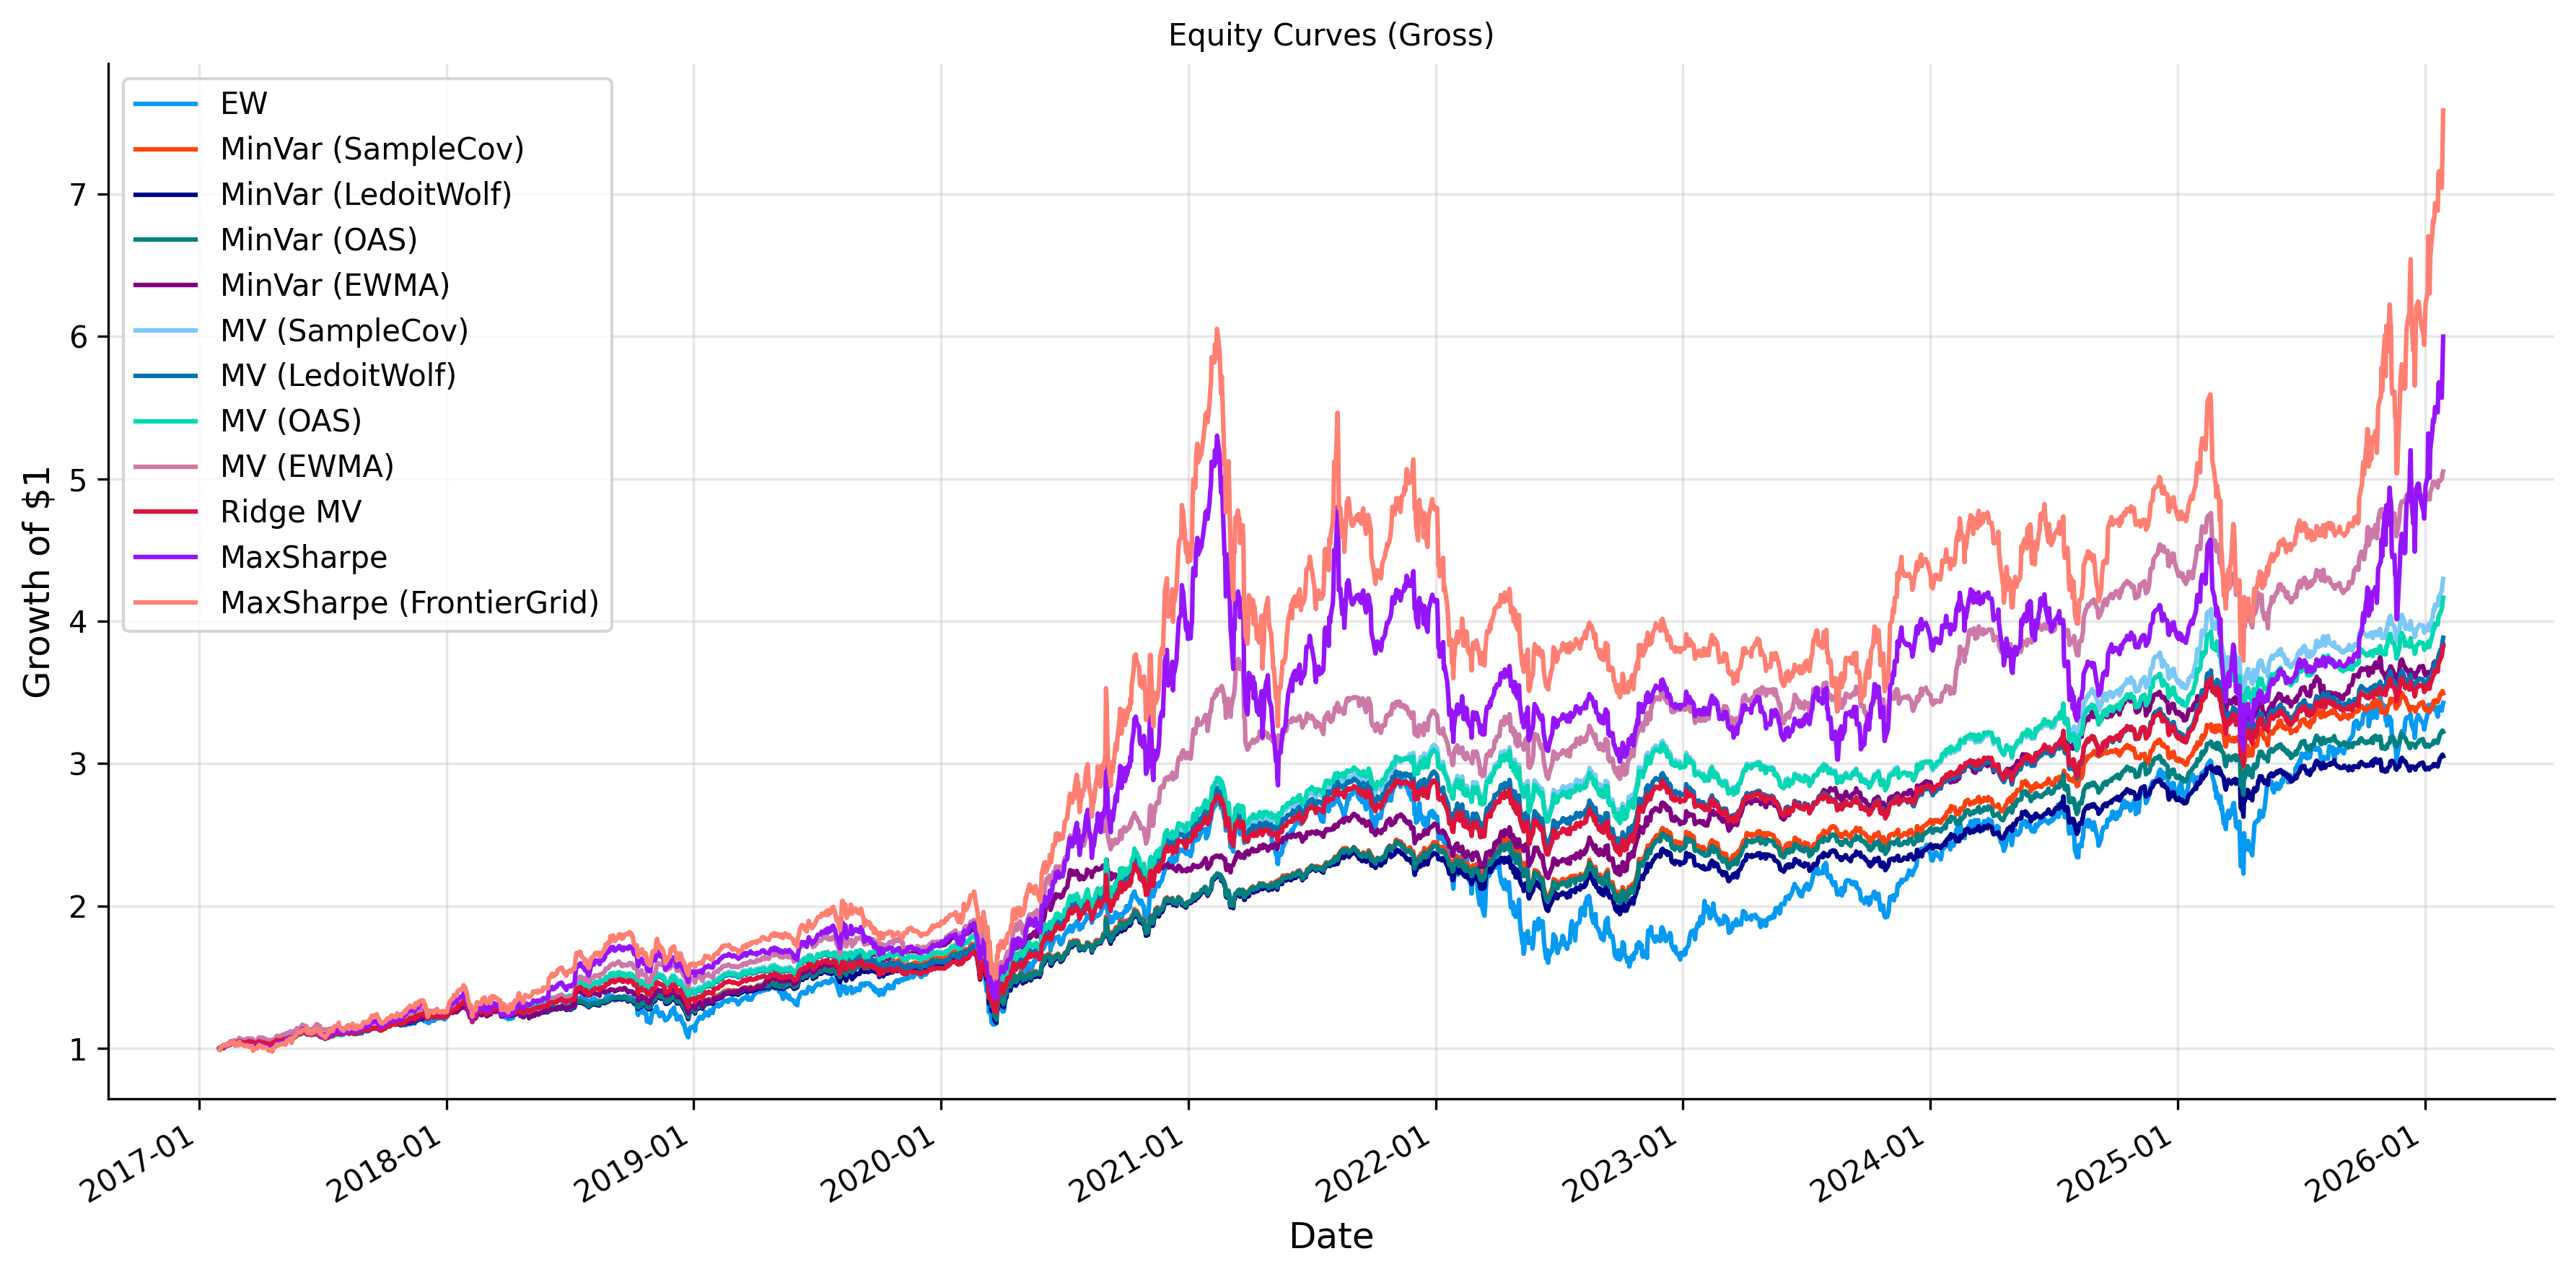

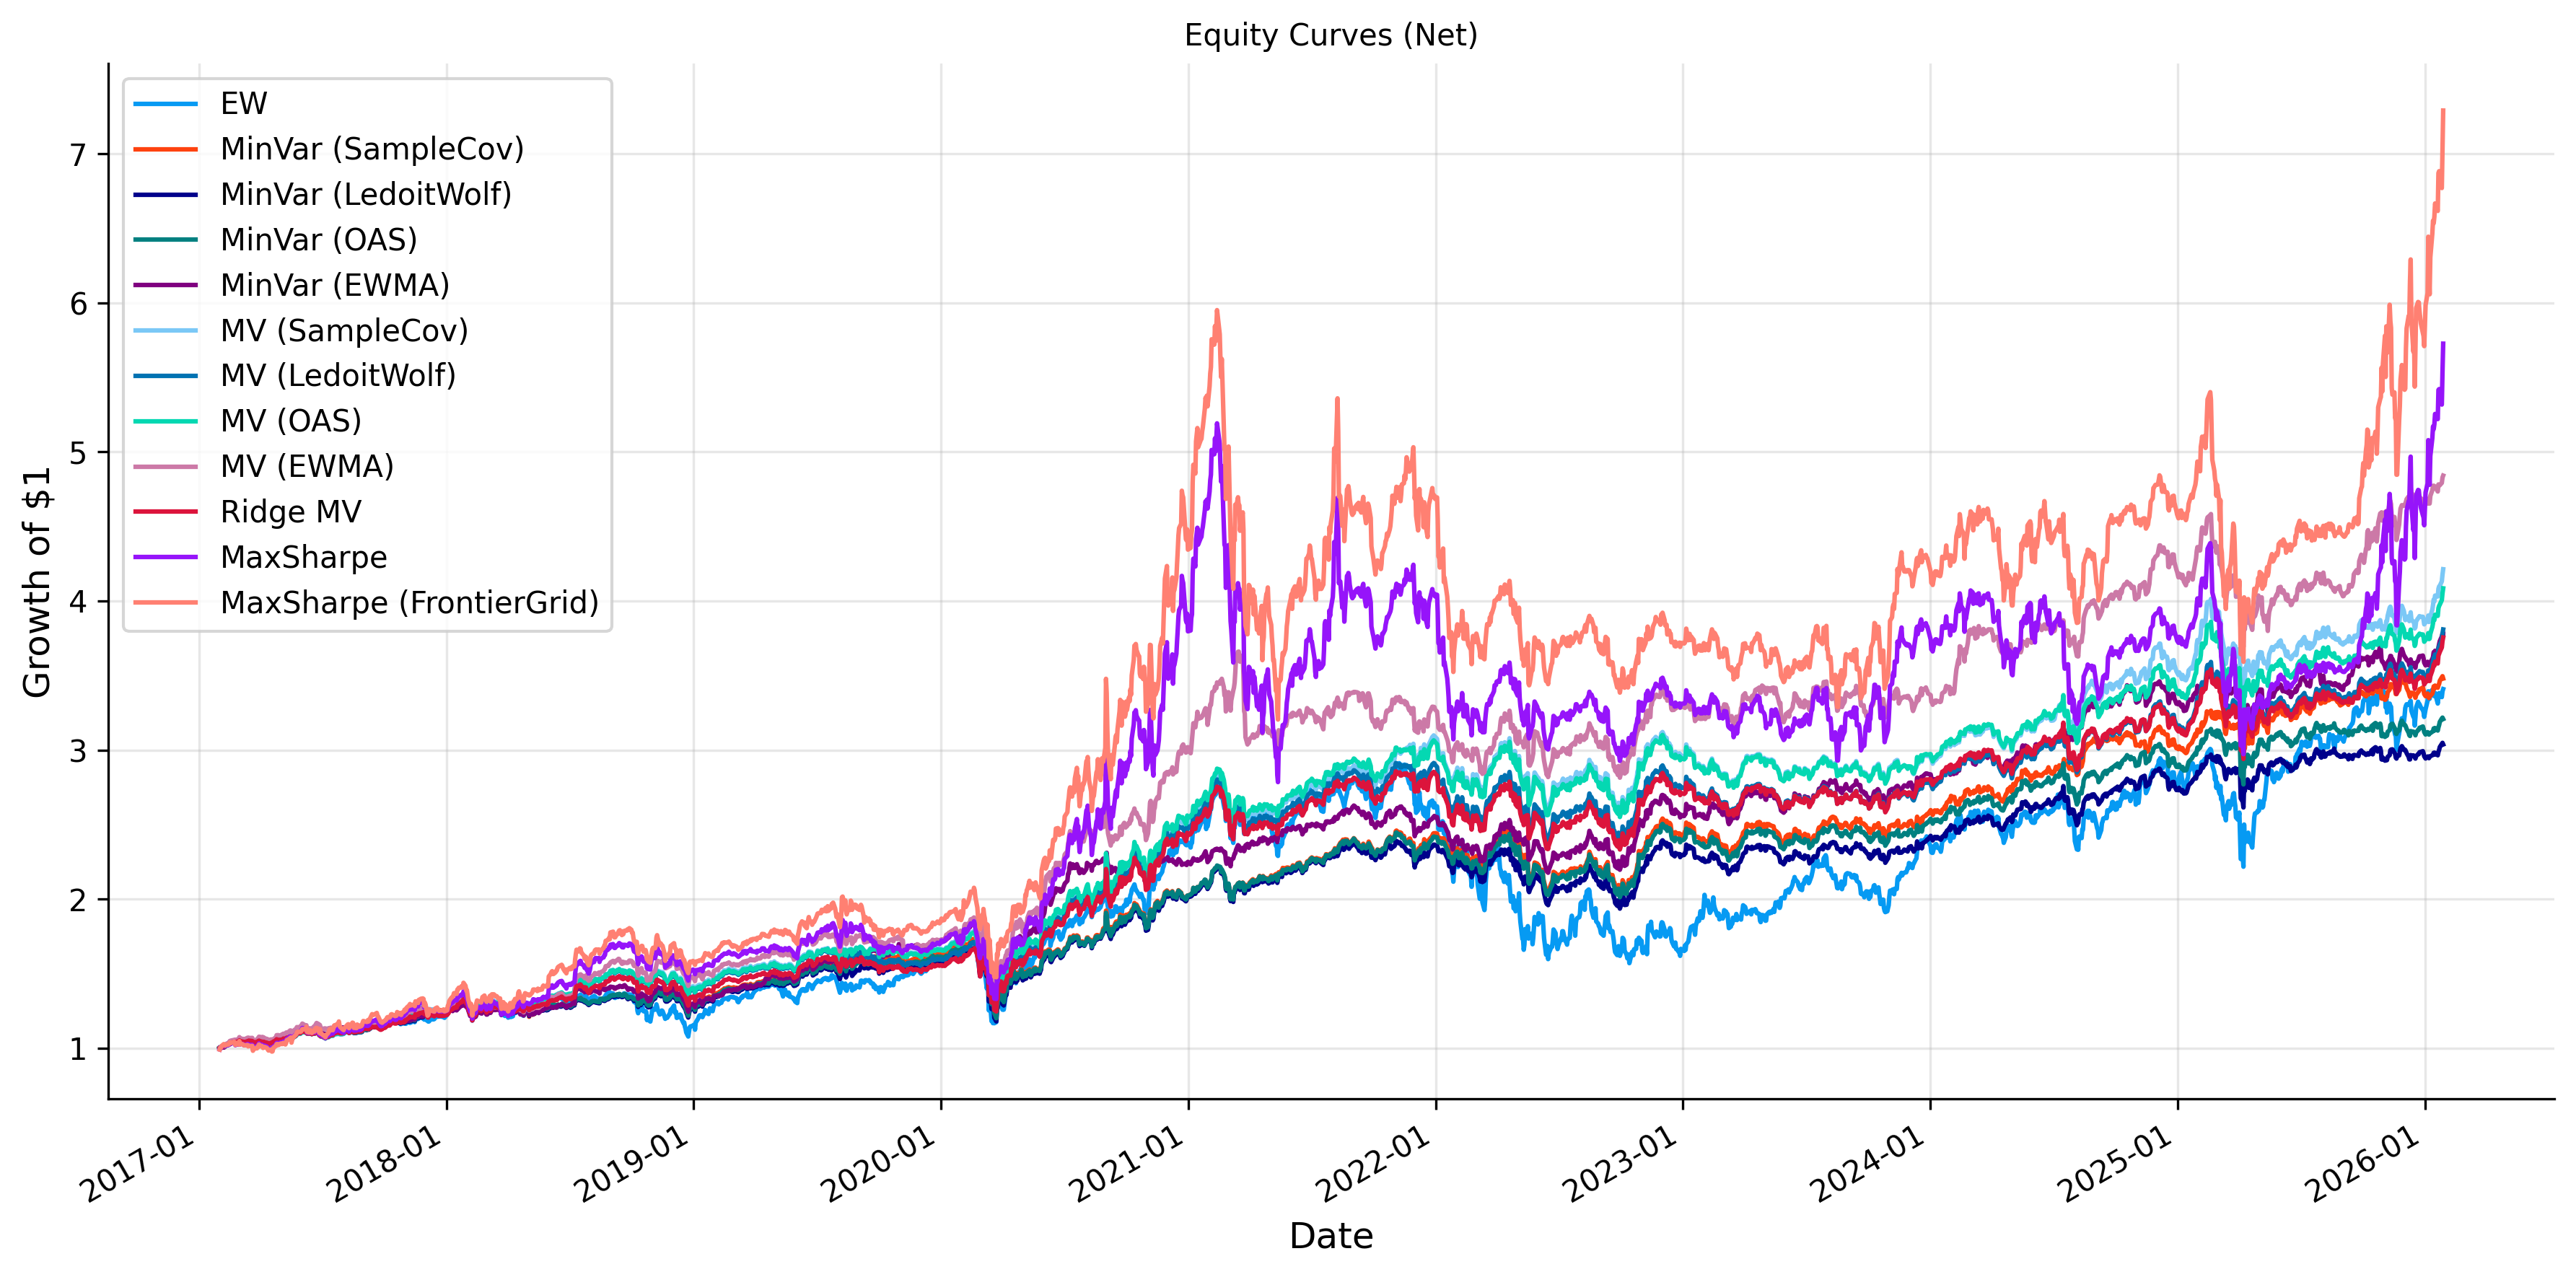

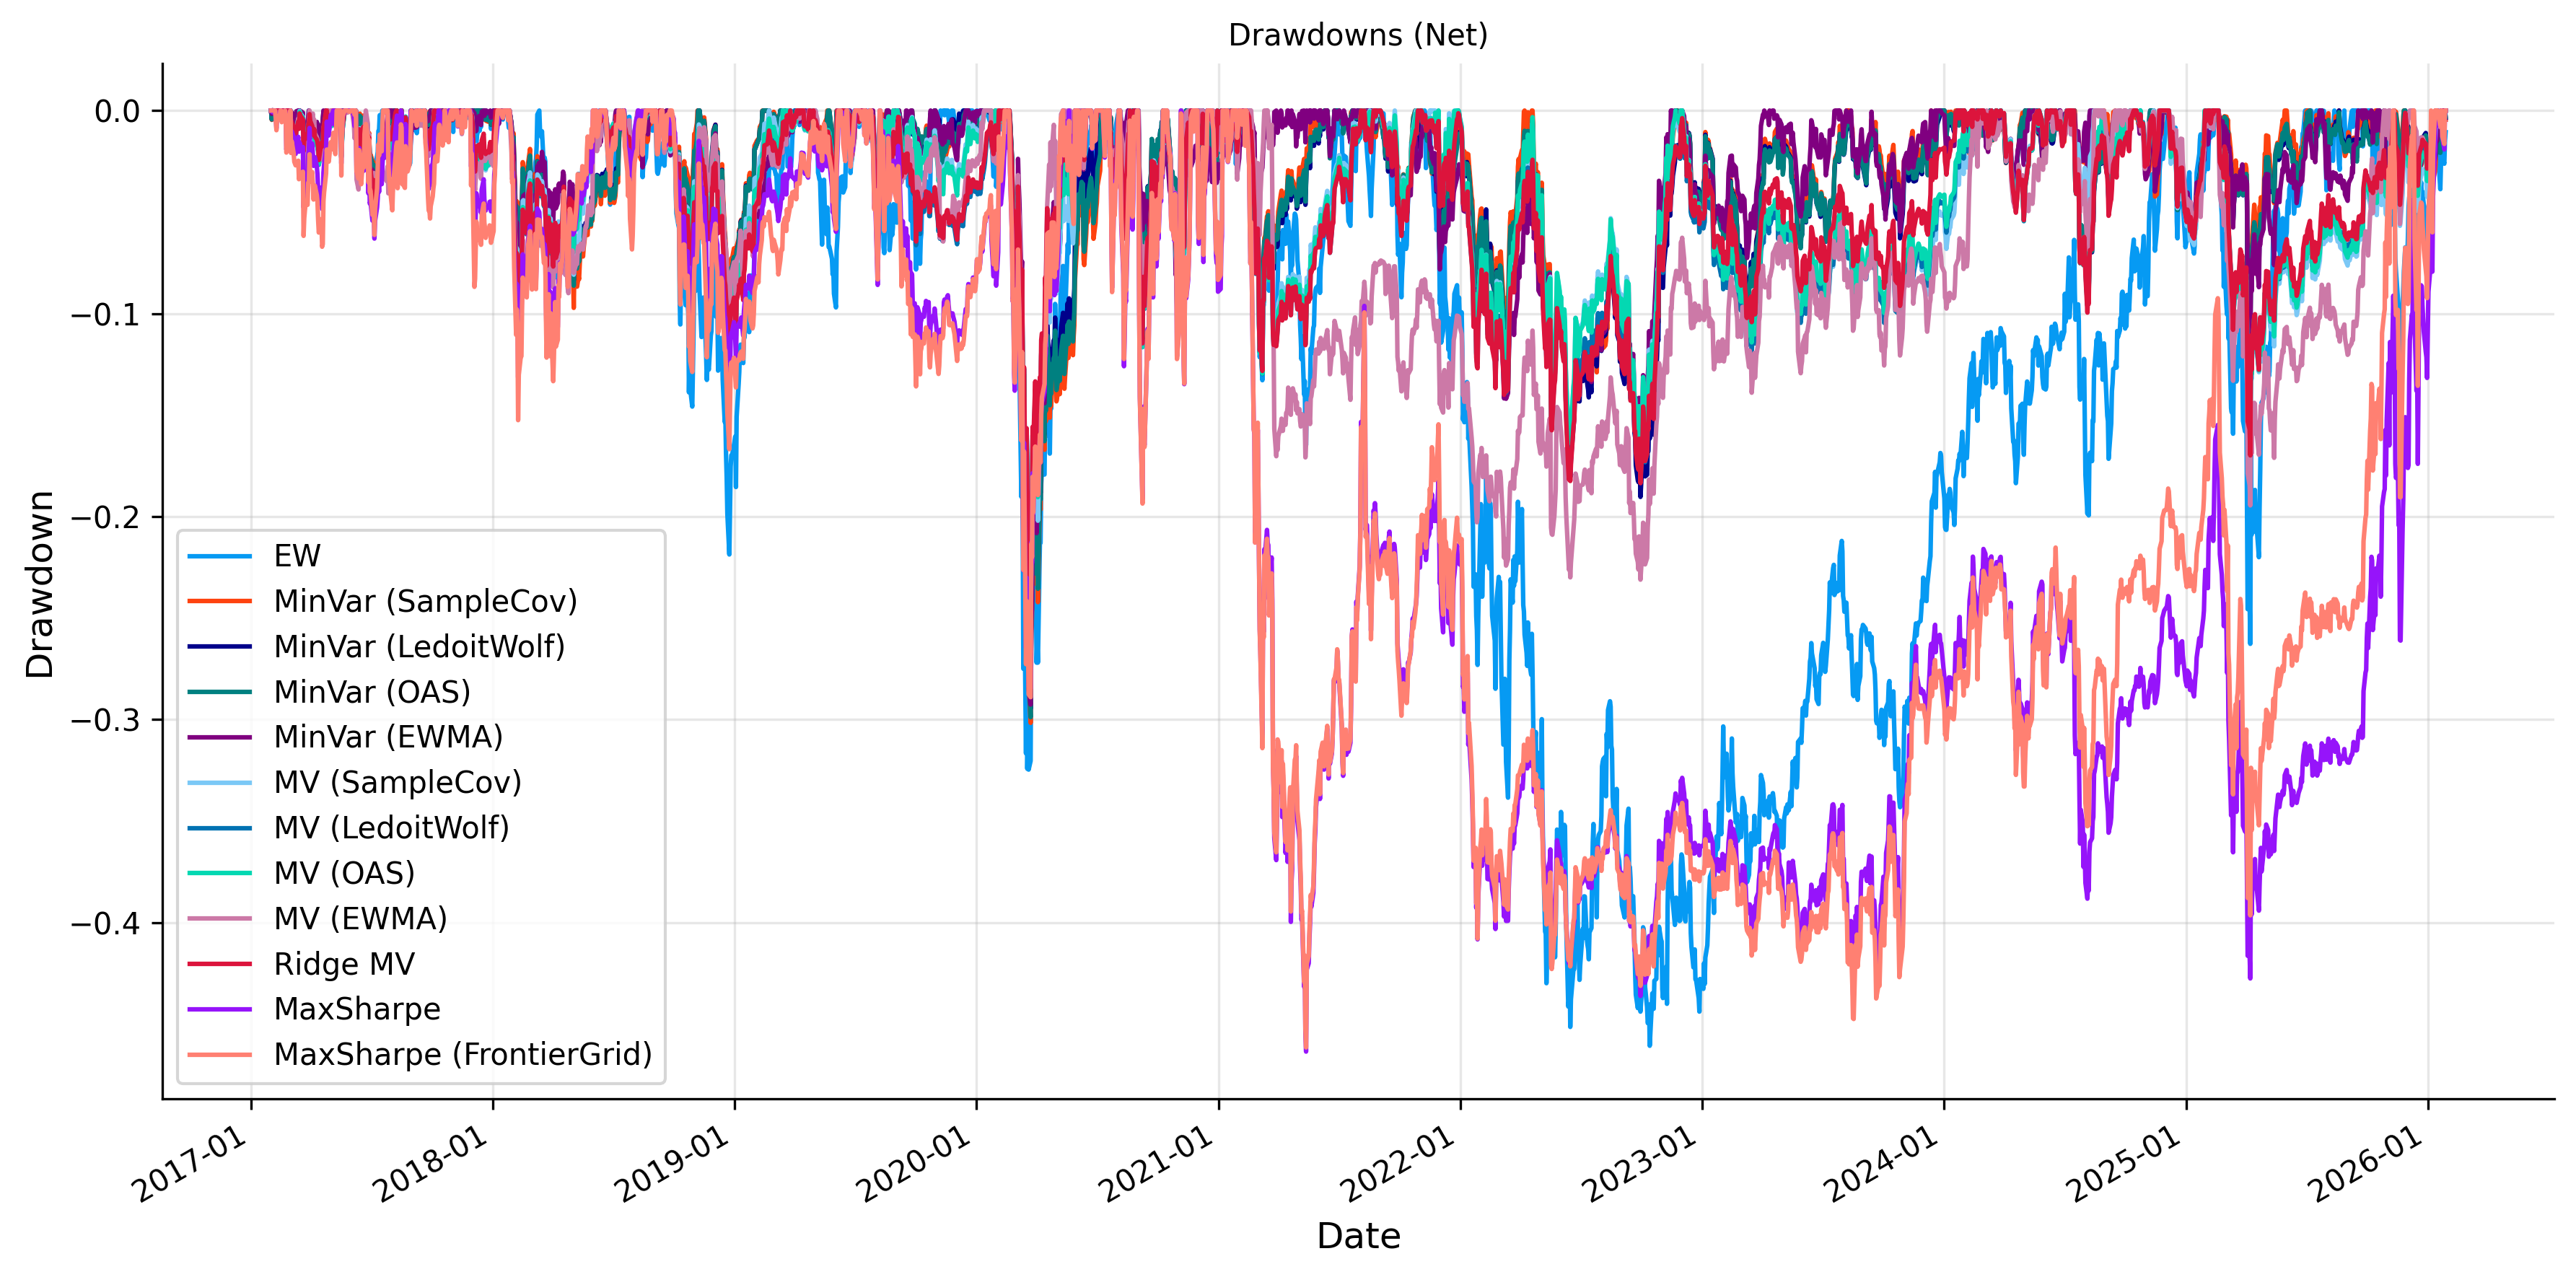

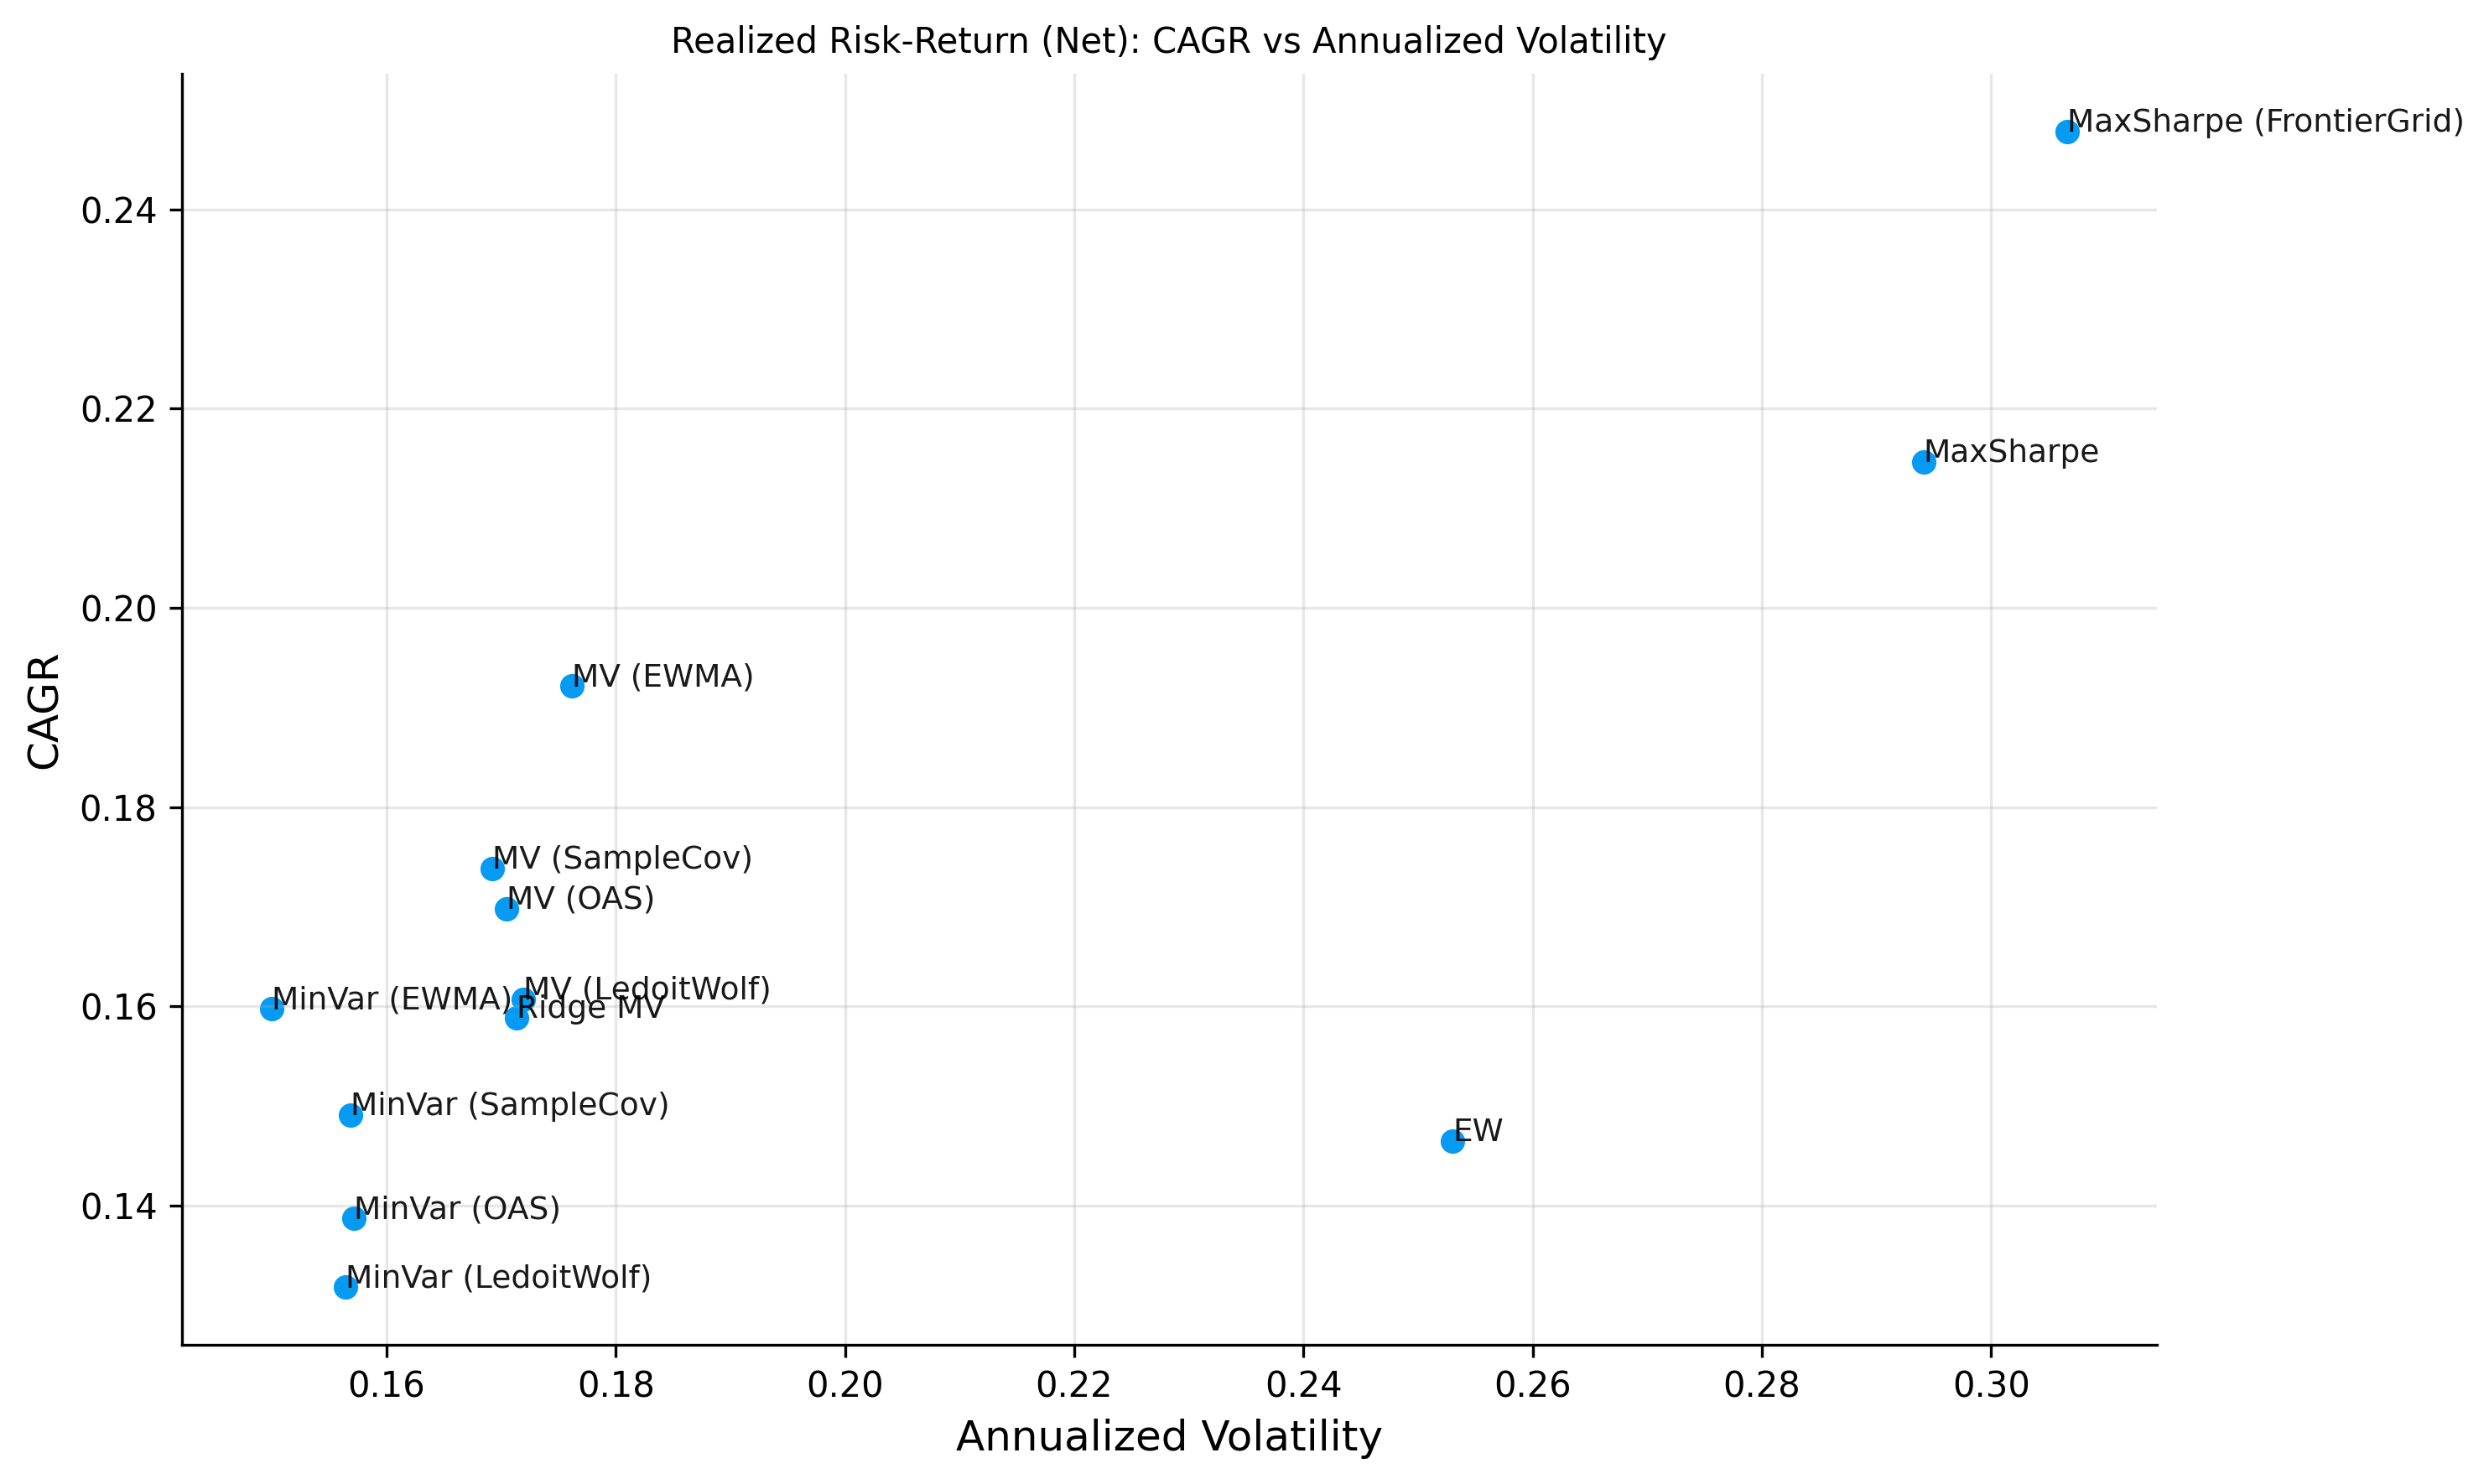

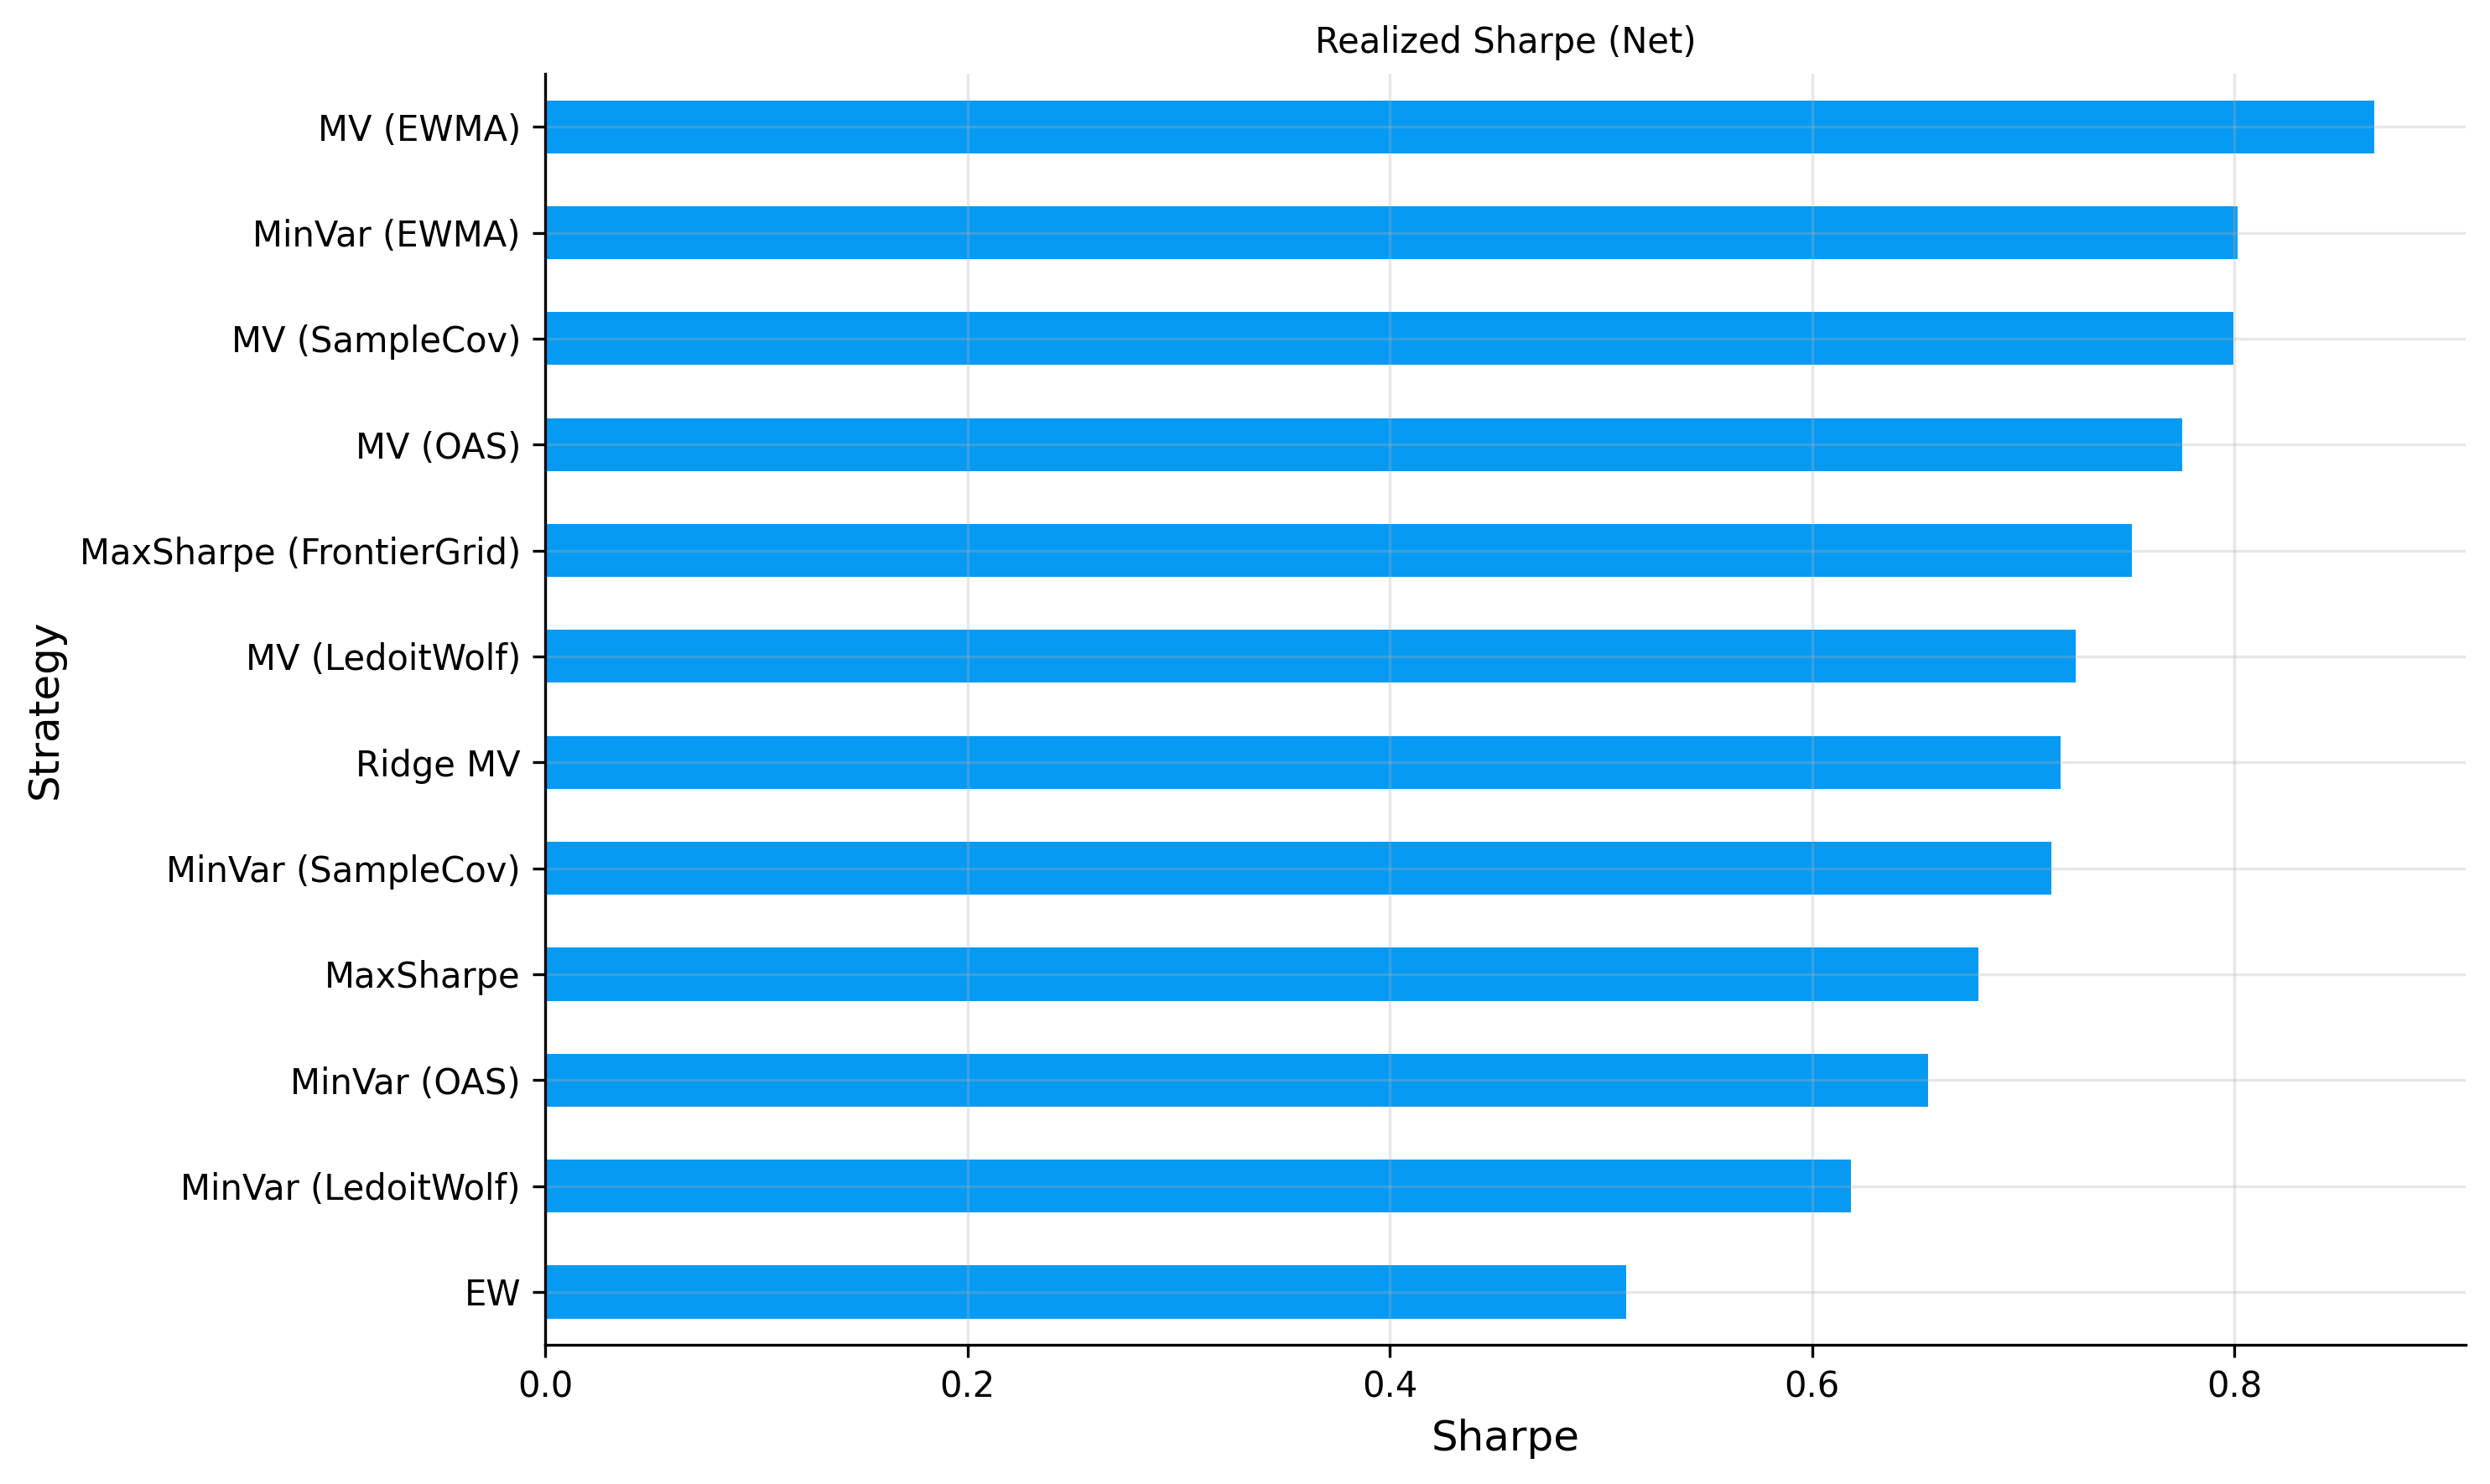

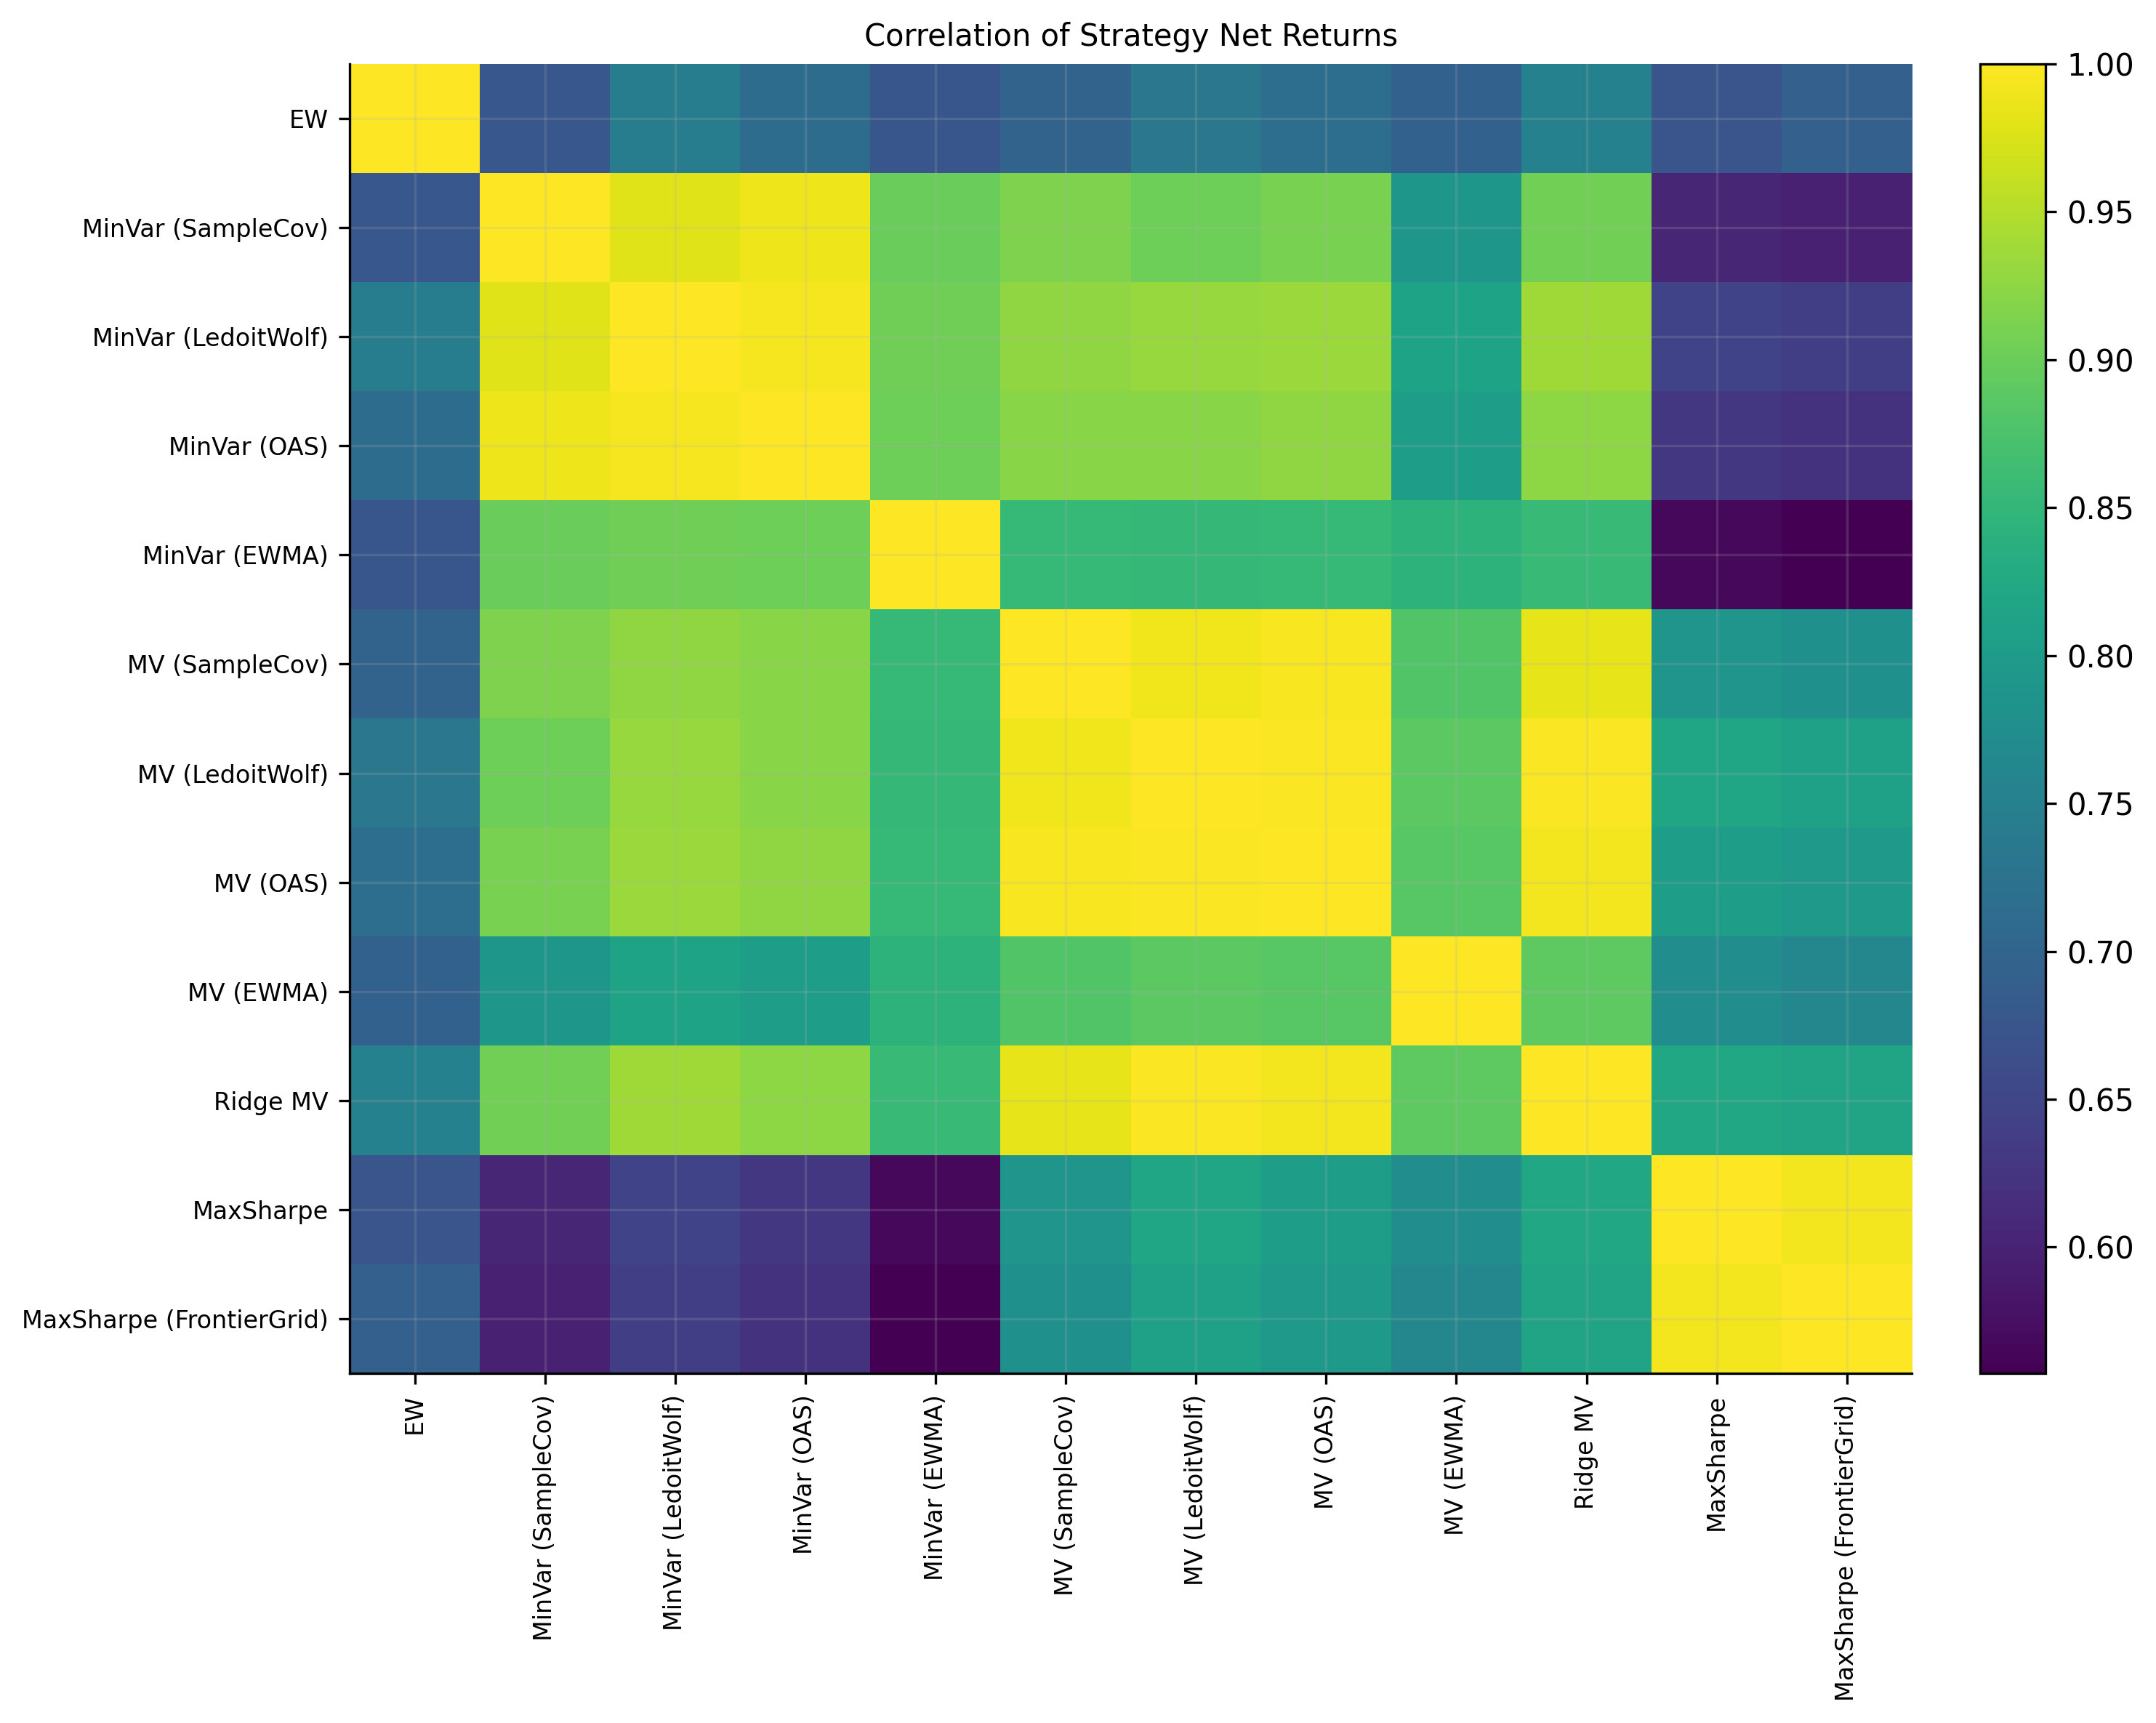

In [77]:
def calc_drawdown(series):
    return series / series.cummax() - 1.0

def performance_metrics(net_returns, net_values):
    years = len(net_returns) / 252.0
    cagr = (net_values.iloc[-1] ** (1.0 / years) - 1.0) if years > 0 else 0.0
    vol = net_returns.std() * np.sqrt(252.0)
    excess = net_returns - rf_daily
    sharpe = (excess.mean() / net_returns.std()) * np.sqrt(252.0) if net_returns.std() > 0 else np.nan
    dd = calc_drawdown(net_values)
    max_dd = dd.min()
    calmar = cagr / abs(max_dd) if max_dd < 0 else np.nan
    downside = net_returns[net_returns < 0]
    sortino = (excess.mean() / downside.std()) * np.sqrt(252.0) if downside.std() > 0 else np.nan
    return cagr, vol, sharpe, max_dd, calmar, sortino

metrics_rows = []
for name, res in results.items():
    metrics_rows.append([name, *performance_metrics(res["net_returns"], res["net_values"])])

metrics_df = pd.DataFrame(metrics_rows, columns=["Strategy", "CAGR", "AnnVol", "Sharpe", "MaxDD", "Calmar", "Sortino"]).set_index("Strategy")
print("Risk/Return Summary (Net)")
display(metrics_df)

trade_rows = []
for name, res in results.items():
    turnover, costs, wdf = res["turnover"], res["costs"], res["weights"]
    if len(wdf) > 0:
        hhi = (wdf ** 2).sum(axis=1)
        avg_hhi = float(hhi.mean())
        eff_n = 1.0 / avg_hhi if avg_hhi > 0 else np.nan
    else:
        avg_hhi, eff_n = np.nan, np.nan
    trade_rows.append([
        name,
        float(turnover.mean()) if len(turnover) else 0.0,
        float(turnover.sum()) if len(turnover) else 0.0,
        float(costs.sum()) if len(costs) else 0.0,
        float(costs.sum() / res["net_values"].iloc[-1]) if len(costs) else 0.0,
        avg_hhi,
        eff_n,
    ])

trade_df = pd.DataFrame(trade_rows, columns=["Strategy", "Avg Turnover", "Total Turnover", "Total Costs", "Cost % Final Value", "Avg HHI", "Effective N"]).set_index("Strategy")
print("Trading & Stability Summary")
display(trade_df)

print("Fallback counts per strategy:")
for name in strategy_names:
    print(f"{name}: {results[name]['fallbacks']}")

def plot_equity_curves(results_dict, key, title):
    plt.figure(figsize=(12, 6))
    for name, res in results_dict.items():
        s = res[key]
        plt.plot(s.index, s.values, label=name, color=strategy_colors[name])
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.grid(True, alpha=0.3)
    plt.legend()
    format_date_axis(plt.gca())
    plt.tight_layout()
    plt.show()

plot_equity_curves(results, "gross_values", "Equity Curves (Gross)")
plot_equity_curves(results, "net_values", "Equity Curves (Net)")

plt.figure(figsize=(12, 6))
for name, res in results.items():
    dd = calc_drawdown(res["net_values"])
    plt.plot(dd.index, dd.values, label=name, color=strategy_colors[name])
plt.title("Drawdowns (Net)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.grid(True, alpha=0.3)
plt.legend()
format_date_axis(plt.gca())
plt.tight_layout()
plt.show()



plt.figure(figsize=(10, 6))
plt.scatter(metrics_df["AnnVol"], metrics_df["CAGR"])
for s in metrics_df.index:
    plt.annotate(s, (metrics_df.loc[s, "AnnVol"], metrics_df.loc[s, "CAGR"]), fontsize=9, alpha=0.9)
plt.title("Realized Risk-Return (Net): CAGR vs Annualized Volatility")
plt.xlabel("Annualized Volatility")
plt.ylabel("CAGR")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
metrics_df["Sharpe"].sort_values().plot(kind="barh")
plt.title("Realized Sharpe (Net)")
plt.xlabel("Sharpe")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ret_mat = pd.concat({k: v["net_returns"] for k, v in results.items()}, axis=1).dropna(how="any")
corr = ret_mat.corr()

plt.figure(figsize=(10, 8))
im = plt.imshow(corr.values, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr.index)), corr.index, fontsize=8)
plt.title("Correlation of Strategy Net Returns")
plt.tight_layout()
plt.show()
